In [1]:
pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.manifold import TSNE
import time
from memory_profiler import profile
from sklearn.metrics import silhouette_score
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from surprise import Dataset, Reader, NormalPredictor
from surprise import accuracy
import pandasql as ps
import warnings
warnings.filterwarnings('ignore')

# Upload Data

In [5]:
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_category = pd.read_csv("product_category_name_translation.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")

In [6]:
#merging all df
data = orders.merge(order_items, on='order_id')
data = data.merge(order_payments, on='order_id')
data = data.merge(order_reviews, on='order_id')
data = data.merge(products, on='product_id')
data = data.merge(customers, on='customer_id')
data = data.merge(sellers, on='seller_id')
data = data.merge(product_category, on='product_category_name')
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
print(data.shape)
data.head(3)

(115609, 40)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-10-18 00:00:00              1   
2           2017-10-18 00:00:00              1   

                         product_id  ... product_height_cm product_width_cm  \
0  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
1  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
2  87285b34884572647811a353c7ac498a  ...               8.0             13.0   

                 customer_unique_id  customer_zip_code_prefix  customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   

  customer_state  seller_zip_code_prefix  seller_city seller_state  \
0             SP                    9350         maua           SP   
1             SP                    9350         maua           SP   
2             SP                    9350         maua           SP   

   product_category_name_english  
0                     housewares  
1                     housewares  
2                     housewares  

[3 rows x 40 columns]

In [7]:
# Specify the path where you want to save the CSV file
csv_file_path = 'raw_merge.csv'

# Use to_csv to write the DataFrame to a CSV file
data.to_csv(csv_file_path, index=False)

In [8]:
csv_options = {
    'sep': ';',         # Use semicolon as a delimiter
    'encoding': 'utf-8'  # Specify the encoding
}

# Use to_csv with additional options
data.to_csv(csv_file_path, index=False, **csv_options)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115609 non-null  object        
 1   customer_id                    115609 non-null  object        
 2   order_status                   115609 non-null  object        
 3   order_purchase_timestamp       115609 non-null  datetime64[ns]
 4   order_approved_at              115595 non-null  object        
 5   order_delivered_carrier_date   114414 non-null  object        
 6   order_delivered_customer_date  113209 non-null  object        
 7   order_estimated_delivery_date  115609 non-null  object        
 8   order_item_id                  115609 non-null  int64         
 9   product_id                     115609 non-null  object        
 10  seller_id                      115609 non-null  object        
 11  

In [95]:
data.head(5).to_csv('raw_data_merge.csv', index=False)

In [10]:
import datetime

present_day = data['order_purchase_timestamp'].max() + datetime.timedelta(days=2)

print("Present day: ",present_day)

Present day:  2018-09-05 09:06:57


In [11]:
recency = data.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (present_day - date.max()).days}).reset_index()
recency = recency.rename(columns={"order_purchase_timestamp": "recency"})
recency.head()

customer_unique_id  recency
0  0000366f3b9a7992bf8c76cfdf3221e2      117
1  0000b849f77a49e4a4ce2b2a4ca5be3f      120
2  0000f46a3911fa3c0805444483337064      543
3  0000f6ccb0745a6a4b88665a16c9f078      327
4  0004aac84e0df4da2b147fca70cf8255      294

In [12]:
def dataset():
    q='''
        select
            do.customer_unique_id,
            count(distinct order_item_id) as frequency,
            sum(payment_value) as monetary,
            count(distinct review_id) as total_review,
            avg(review_score) as avg_score,
            count(distinct product_id) as total_product_order,
            count(distinct product_category_name) as total_category_order
            
        from data do
        group by 1
        order by frequency desc
    '''
    return q

dataset = ps.sqldf(dataset())
dataset.head(3)

customer_unique_id  frequency  monetary  total_review  \
0  4546caea018ad8c692964e3382debd19         21   4118.31             1   
1  c402f431464c72e27330a67f7b94d4fb         20  44048.00             1   
2  11f97da02237a49c8e783dfda6f50e8e         15  11745.00             1   

   avg_score  total_product_order  total_category_order  
0        1.0                    3                     1  
1        1.0                    1                     1  
2        5.0                    1                     1

In [13]:
dataset = dataset.merge(recency, on='customer_unique_id', how='inner')
dataset.head(3)

customer_unique_id  frequency  monetary  total_review  \
0  4546caea018ad8c692964e3382debd19         21   4118.31             1   
1  c402f431464c72e27330a67f7b94d4fb         20  44048.00             1   
2  11f97da02237a49c8e783dfda6f50e8e         15  11745.00             1   

   avg_score  total_product_order  total_category_order  recency  
0        1.0                    3                     1      415  
1        1.0                    1                     1      194  
2        5.0                    1                     1      582

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 93395
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    93396 non-null  object 
 1   frequency             93396 non-null  int64  
 2   monetary              93396 non-null  float64
 3   total_review          93396 non-null  int64  
 4   avg_score             93396 non-null  float64
 5   total_product_order   93396 non-null  int64  
 6   total_category_order  93396 non-null  int64  
 7   recency               93396 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 6.4+ MB


In [15]:
# Specify the path where you want to save the CSV file
csv_file_path = 'dataset_clustering.csv'

# Use to_csv to write the DataFrame to a CSV file
dataset.to_csv(csv_file_path, index=False)

csv_options = {
    'sep': ';',         # Use semicolon as a delimiter
    'encoding': 'utf-8'  # Specify the encoding
}

# Use to_csv with additional options
dataset.to_csv(csv_file_path, index=False, **csv_options)

# Data Preprocessing

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 93395
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    93396 non-null  object 
 1   frequency             93396 non-null  int64  
 2   monetary              93396 non-null  float64
 3   total_review          93396 non-null  int64  
 4   avg_score             93396 non-null  float64
 5   total_product_order   93396 non-null  int64  
 6   total_category_order  93396 non-null  int64  
 7   recency               93396 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 6.4+ MB


In [17]:
dataset.duplicated().sum()

0

In [18]:
dataset.describe()

frequency       monetary  total_review     avg_score  \
count  93396.000000   93396.000000  93396.000000  93396.000000   
mean       1.143068     213.387431      1.031297      4.104413   
std        0.537718     631.534143      0.201858      1.324810   
min        1.000000       9.590000      1.000000      1.000000   
25%        1.000000      64.000000      1.000000      4.000000   
50%        1.000000     113.030000      1.000000      5.000000   
75%        1.000000     203.390000      1.000000      5.000000   
max       21.000000  109312.640000     15.000000      5.000000   

       total_product_order  total_category_order       recency  
count         93396.000000          93396.000000  93396.000000  
mean              1.067819              1.024990    243.744250  
std               0.313489              0.167607    153.164721  
min               1.000000              1.000000      2.000000  
25%               1.000000              1.000000    120.000000  
50%               1.000000              1.000000    224.000000  
75%               1.000000              1.000000    353.000000  
max              14.000000              5.000000    730.000000

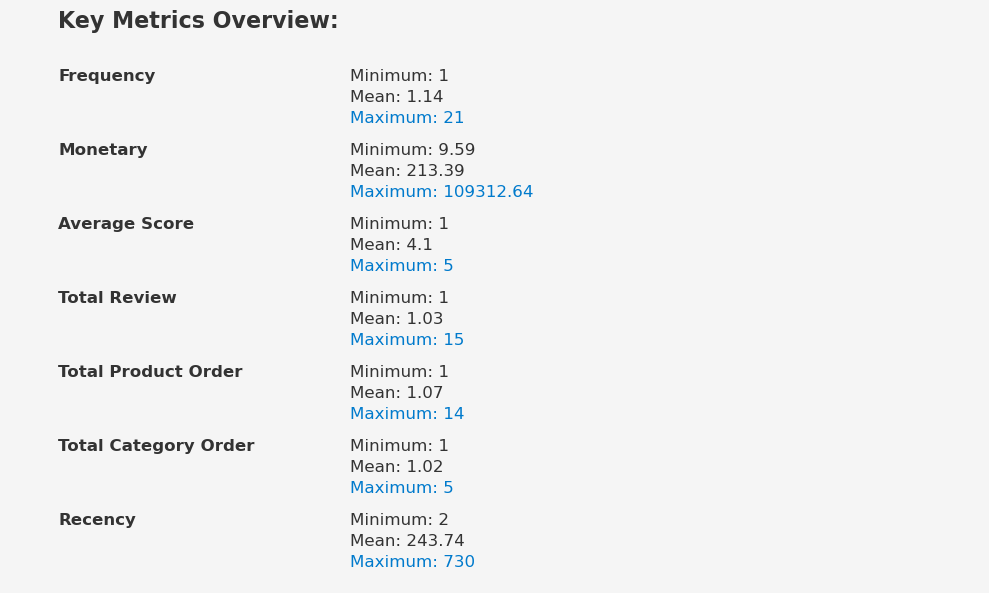

In [19]:
# Key metrics data
metrics = ['Frequency', 'Monetary', 'Average Score', 'Total Review', 'Total Product Order', 'Total Category Order', 'Recency']
count = [93396, 93396, 93396, 93396, 93396, 93396, 93396]
mean = [1.143068, 213.387431, 4.104413, 1.031297, 1.067819, 1.024990, 243.744250]
min_value = [1, 9.59, 1, 1, 1, 1, 2]
max_value = [21, 109312.64, 5, 15, 14, 5, 730]

# Create an infographic-style visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Customize appearance
background_color = '#f5f5f5'
box_color = '#d8d8d8'
text_color = '#333333'
highlight_color = '#007acc'

# Set background color
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Create text boxes with key metrics
for i, metric in enumerate(metrics):
    ax.text(0.05, 0.95 - (i * 0.14), metric, transform=ax.transAxes, color=text_color, fontsize=12, fontweight='bold')
    ax.text(0.35, 0.95 - (i * 0.14), f"Minimum: {round(min_value[i], 2)}", transform=ax.transAxes, color=text_color, fontsize=12)
    ax.text(0.35, 0.95 - (i * 0.14) - 0.04, f"Mean: {round(mean[i], 2)}", transform=ax.transAxes, color=text_color, fontsize=12)
    ax.text(0.35, 0.95 - (i * 0.14) - 0.08, f"Maximum: {round(max_value[i], 2)}", transform=ax.transAxes, color=highlight_color, fontsize=12)

# Remove axis ticks and spines
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add title and key metrics overview
ax.text(0.05, 1.05, 'Key Metrics Overview:', transform=ax.transAxes, color=text_color, fontsize=16, fontweight='bold')

# Display the visualization
plt.tight_layout()
plt.show()

In [20]:
missing_values_data = data.isnull().sum()
total_rows_data = len(data)
percentage_missing_values_data = (missing_values_data / total_rows_data) * 100
print(percentage_missing_values_data)

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.012110
order_delivered_carrier_date      1.033657
order_delivered_customer_date     2.075963
order_estimated_delivery_date     0.000000
order_item_id                     0.000000
product_id                        0.000000
seller_id                         0.000000
shipping_limit_date               0.000000
price                             0.000000
freight_value                     0.000000
payment_sequential                0.000000
payment_type                      0.000000
payment_installments              0.000000
payment_value                     0.000000
review_id                         0.000000
review_score                      0.000000
review_comment_title             88.062348
review_comment_message           57.697065
review_creation_date              0.000000
review_answ

In [21]:
columns_to_drop = ['review_comment_title', 'review_comment_message']
data = data.drop(columns=columns_to_drop)

In [22]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 115607
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  object        
 5   order_delivered_carrier_date   113193 non-null  object        
 6   order_delivered_customer_date  113193 non-null  object        
 7   order_estimated_delivery_date  113193 non-null  object        
 8   order_item_id                  113193 non-null  int64         
 9   product_id                     113193 non-null  object        
 10  seller_id                      113193 non-null  object        
 11  

In [23]:
# Specify the path where you want to save the CSV file
csv_file_path = 'clean_merge.csv'

# Use to_csv to write the DataFrame to a CSV file
data.to_csv(csv_file_path, index=False)

In [24]:
data.duplicated().sum()

0

In [25]:
missing_values_data = data.isnull().sum()
total_rows_data = len(data)
percentage_missing_values_data = (missing_values_data / total_rows_data) * 100
print(percentage_missing_values_data)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 115607
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  object        
 5   order_delivered_carrier_date   113193 non-null  object        
 6   order_delivered_customer_date  113193 non-null  object        
 7   order_estimated_delivery_date  113193 non-null  object        
 8   order_item_id                  113193 non-null  int64         
 9   product_id                     113193 non-null  object        
 10  seller_id                      113193 non-null  object        
 11  

In [27]:
new_data = data.copy()
new_data.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-10-18 00:00:00              1   
2           2017-10-18 00:00:00              1   

                         product_id  ... product_height_cm product_width_cm  \
0  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
1  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
2  87285b34884572647811a353c7ac498a  ...               8.0             13.0   

                 customer_unique_id  customer_zip_code_prefix  customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   

  customer_state  seller_zip_code_prefix  seller_city seller_state  \
0             SP                    9350         maua           SP   
1             SP                    9350         maua           SP   
2             SP                    9350         maua           SP   

   product_category_name_english  
0                     housewares  
1                     housewares  
2                     housewares  

[3 rows x 38 columns]

In [28]:
new_data.duplicated().sum()

0

In [29]:
new_data.head(100)

order_id                       customer_id  \
0   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3   128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4   0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
..                               ...                               ...   
95  8151a29068abf0cf775f916b52473877  6847fd0a396b6ba770e4bdf076e8712f   
96  52c19f029f1e4d22ee6cfa38451ab0fe  ade47ed1beab3126cad16dce9dd5b363   
97  2b2dd432bec6d33562a2dd8962ff1e61  bac77778ea54b998b5f374d5d36e229b   
98  2c4665e95f17505890c0f9b086f89754  1fd9c6fab4bffc74497e8fafd172dd6d   
99  72c6c412519423a1a046bd52a9db5560  becb0b270487c14db37a07a18278de85   

   order_status order_purchase_timestamp    order_approved_at  \
0     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3     delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4     delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
..          ...                      ...                  ...   
95    delivered      2017-11-14 17:46:59  2017-11-14 18:06:49   
96    delivered      2018-03-14 09:55:08  2018-03-15 03:15:44   
97    delivered      2017-06-01 09:01:29  2017-06-01 09:10:19   
98    delivered      2017-12-05 19:02:14  2017-12-05 19:15:27   
99    delivered      2018-01-06 10:59:43  2018-01-06 11:07:41   

   order_delivered_carrier_date order_delivered_customer_date  \
0           2017-10-04 19:55:00           2017-10-10 21:25:13   
1           2017-10-04 19:55:00           2017-10-10 21:25:13   
2           2017-10-04 19:55:00           2017-10-10 21:25:13   
3           2017-08-17 15:28:33           2017-08-18 14:44:43   
4           2017-08-04 17:35:43           2017-08-07 18:30:01   
..                          ...                           ...   
95          2017-11-16 16:08:53           2017-11-24 15:19:06   
96          2018-03-15 22:06:30           2018-03-29 07:07:47   
97          2017-06-01 13:06:16           2017-06-12 10:27:36   
98          2017-12-06 21:51:41           2017-12-22 19:35:07   
99          2018-01-08 20:06:28           2018-01-23 19:29:11   

   order_estimated_delivery_date  order_item_id  \
0            2017-10-18 00:00:00              1   
1            2017-10-18 00:00:00              1   
2            2017-10-18 00:00:00              1   
3            2017-08-28 00:00:00              1   
4            2017-08-15 00:00:00              1   
..                           ...            ...   
95           2017-12-05 00:00:00              1   
96           2018-04-11 00:00:00              1   
97           2017-06-30 00:00:00              1   
98           2018-01-02 00:00:00              1   
99           2018-02-07 00:00:00              1   

                          product_id  ... product_height_cm product_width_cm  \
0   87285b34884572647811a353c7ac498a  ...               8.0             13.0   
1   87285b34884572647811a353c7ac498a  ...               8.0             13.0   
2   87285b34884572647811a353c7ac498a  ...               8.0             13.0   
3   87285b34884572647811a353c7ac498a  ...               8.0             13.0   
4   87285b34884572647811a353c7ac498a  ...               8.0             13.0   
..                               ...  ...               ...              ...   
95  451f60a1af05c5bef8d9e93fe847f6bc  ...              17.0             19.0   
96  451f60a1af05c5bef8d9e93fe847f6bc  ...              17.0             19.0   
97  f7f7214af35d79cb0baa6038fdc65e2c  ...              14.0             28.0   
98  03137dc3af3dc8138e070c4536407618  ...              12.0             25.0   
99  03137dc3af3dc8138e070c4536407618  ...              12.0             25.0   

   

In [30]:
numerical_columns = new_data.select_dtypes(include=['int64', 'float64'])

In [31]:
numerical_columns.drop(columns=['customer_zip_code_prefix','seller_zip_code_prefix'])

order_item_id   price  freight_value  payment_sequential  \
0                   1   29.99           8.72                   1   
1                   1   29.99           8.72                   3   
2                   1   29.99           8.72                   2   
3                   1   29.99           7.78                   1   
4                   1   29.99           7.78                   1   
...               ...     ...            ...                 ...   
115602              2   64.99          19.37                   1   
115603              1   44.99          18.42                   1   
115605              1   58.99           7.39                   1   
115606              1   23.99           7.43                   1   
115607              1  749.00          55.96                   1   

        payment_installments  payment_value  review_score  \
0                          1          18.12             4   
1                          1           2.00             4   
2                          1          18.59             4   
3                          3          37.77             4   
4                          1          37.77             5   
...                      ...            ...           ...   
115602                     1         168.72             5   
115603                     1          63.41             1   
115605                     1          66.38             5   
115606                     1          31.42             5   
115607                    10         804.96             5   

        product_name_lenght  product_description_lenght  product_photos_qty  \
0                      40.0                       268.0                 4.0   
1                      40.0                       268.0                 4.0   
2                      40.0                       268.0                 4.0   
3                      40.0                       268.0                 4.0   
4                      40.0                       268.0                 4.0   
...                     ...                         ...                 ...   
115602                 56.0                       345.0                 1.0   
115603                 53.0                       568.0                 1.0   
115605                 48.0                       459.0                 1.0   
115606                 59.0                       706.0                 1.0   
115607                 57.0                      3694.0                 1.0   

        product_weight_g  product_length_cm  product_height_cm  \
0                  500.0               19.0                8.0   
1                  500.0               19.0                8.0   
2                  500.0               19.0                8.0   
3                  500.0               19.0                8.0   
4                  500.0               19.0                8.0   
...                  ...                ...                ...   
115602             300.0               33.0                2.0   
115603             300.0               25.0                2.0   
115605             300.0               33.0                2.0   
115606             150.0               33.0                2.0   
115607             300.0               16.0               14.0   

        product_width_cm  
0                   13.0  
1                   13.0  
2                   13.0  
3                   13.0  
4                   13.0  
...                  ...  
115602              23.0  
115603              30.0  
115605              23.0  
115606              23.0  
115607              16.0  

[113193 rows x 14 columns]

In [32]:
numerical_columns_fix = numerical_columns.drop(columns=['customer_zip_code_prefix','seller_zip_code_prefix','product_length_cm','product_height_cm','product_width_cm'])

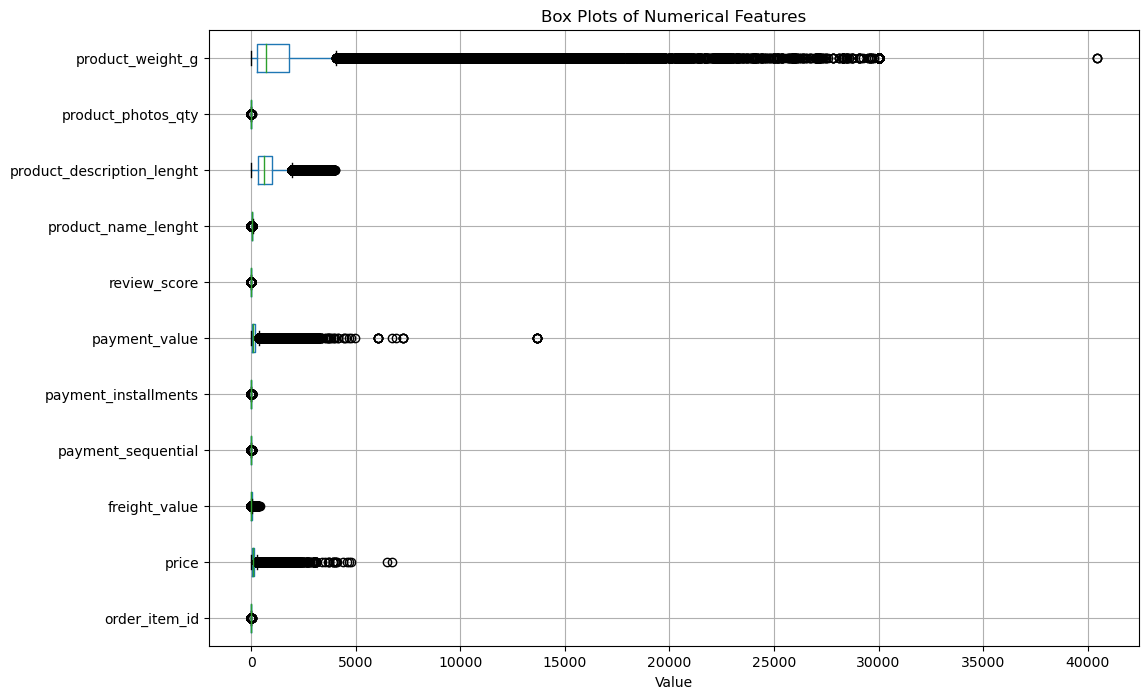

In [33]:
# Create box plots for each numerical feature
plt.figure(figsize=(12, 8))
numerical_columns_fix.boxplot(vert=False)
plt.title("Box Plots of Numerical Features")
plt.xlabel("Value")
plt.show()

# EDA

1. How many days/ lead time need to be take to ship the product average per order

In [34]:
date_columns = ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date']
new_data[date_columns] = new_data[date_columns].apply(pd.to_datetime)

In [35]:
#calculate shipping duration
new_data['shipping_duration'] = new_data['order_delivered_customer_date'] - new_data['order_purchase_timestamp']

In [36]:
print(new_data[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'shipping_duration']].head())

                           order_id order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
2  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
3  128e10d95713541c87cd1a2e48201934      2017-08-15 18:29:31   
4  0e7e841ddf8f8f2de2bad69267ecfbcf      2017-08-02 18:24:47   

  order_delivered_customer_date shipping_duration  
0           2017-10-10 21:25:13   8 days 10:28:40  
1           2017-10-10 21:25:13   8 days 10:28:40  
2           2017-10-10 21:25:13   8 days 10:28:40  
3           2017-08-18 14:44:43   2 days 20:15:12  
4           2017-08-07 18:30:01   5 days 00:05:14  


In [37]:
shipping_duration_df = new_data[['order_id', 'shipping_duration']].copy()

In [38]:
shipping_duration_df.head()

order_id shipping_duration
0  e481f51cbdc54678b7cc49136f2d6af7   8 days 10:28:40
1  e481f51cbdc54678b7cc49136f2d6af7   8 days 10:28:40
2  e481f51cbdc54678b7cc49136f2d6af7   8 days 10:28:40
3  128e10d95713541c87cd1a2e48201934   2 days 20:15:12
4  0e7e841ddf8f8f2de2bad69267ecfbcf   5 days 00:05:14

In [39]:
# Calculate the average shipping duration per order
average_shipping_duration = new_data.groupby('order_id')['shipping_duration'].mean()

# Display the average shipping duration per order
print(average_shipping_duration)

order_id
00010242fe8c5a6d1ba2dd792cb16214    7 days 14:44:46
00018f77f2f0320c557190d7a144bdd3   16 days 05:11:18
000229ec398224ef6ca0657da4fc703e    7 days 22:45:45
00024acbcdf0a6daa1e931b038114c75    6 days 03:32:04
00042b26cf59d7ce69dfabb4e55b4fd9   25 days 02:44:40
                                         ...       
fffc94f6ce00a00581880bf54a75a037   17 days 08:59:34
fffcd46ef2263f404302a634eb57f7eb    9 days 10:05:09
fffce4705a9662cd70adb13d4a31832d    4 days 19:14:26
fffe18544ffabc95dfada21779c9644f    1 days 22:56:41
fffe41c64501cc87c801fd61db3f6244    5 days 00:56:08
Name: shipping_duration, Length: 94471, dtype: timedelta64[ns]


In [40]:
# Calculate the total shipping duration per order
total_shipping_duration = new_data.groupby('order_id')['shipping_duration'].sum()

# Display the total shipping duration per order
print(total_shipping_duration)

order_id
00010242fe8c5a6d1ba2dd792cb16214    7 days 14:44:46
00018f77f2f0320c557190d7a144bdd3   16 days 05:11:18
000229ec398224ef6ca0657da4fc703e    7 days 22:45:45
00024acbcdf0a6daa1e931b038114c75    6 days 03:32:04
00042b26cf59d7ce69dfabb4e55b4fd9   25 days 02:44:40
                                         ...       
fffc94f6ce00a00581880bf54a75a037   17 days 08:59:34
fffcd46ef2263f404302a634eb57f7eb    9 days 10:05:09
fffce4705a9662cd70adb13d4a31832d    4 days 19:14:26
fffe18544ffabc95dfada21779c9644f    1 days 22:56:41
fffe41c64501cc87c801fd61db3f6244    5 days 00:56:08
Name: shipping_duration, Length: 94471, dtype: timedelta64[ns]


In [41]:
# Calculate the average shipping days for all order_id
average_shipping_days = new_data['shipping_duration'].mean()

# Display the average shipping days
print("Average Shipping Days:", average_shipping_days)

Average Shipping Days: 12 days 10:36:04.031600894


2. Which month is the most purchase amount of customer (have more purchase power/ willing to purchase)?

In [42]:
order_date = ['order_purchase_timestamp']
new_data[order_date] = new_data[order_date].apply(pd.to_datetime)

In [43]:
# Extract year and month from the 'order_purchase_timestamp' column
new_data['order_year'] = new_data['order_purchase_timestamp'].dt.year
new_data['order_month'] = new_data['order_purchase_timestamp'].dt.month

In [44]:
# Group the data by year and month, and calculate the total purchase amount
# monthly_purchase = new_data.groupby(['order_year', 'order_month', 'product_category_name_english'])['payment_value'].sum().reset_index()

In [45]:
# Group the data by year and month, and calculate the total purchase amount
monthly_purchase = new_data.groupby(['order_year', 'order_month'])['payment_value'].sum().reset_index()

In [46]:
monthly_purchase.head(3)

order_year  order_month  payment_value
0        2016           10       61593.19
1        2016           12          19.62
2        2017            1      172882.76

In [47]:
# Specify the path where you want to save the CSV file
# csv_file_path = 'monthly_purchase.csv'

# Use to_csv to write the DataFrame to a CSV file
# monthly_purchase.to_csv(csv_file_path, index=False)

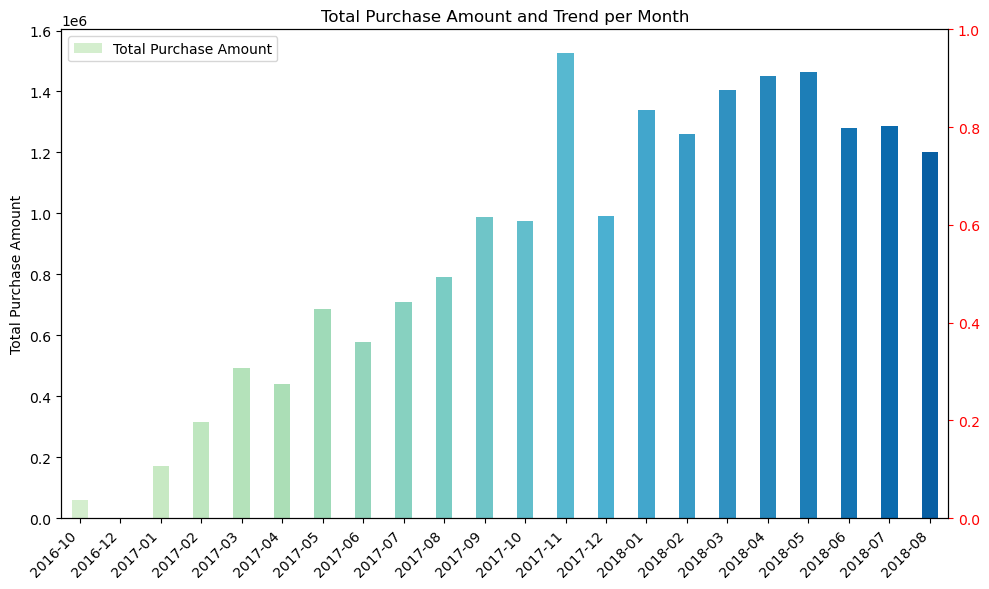

In [48]:
# Create a figure and adjust figure size
plt.figure(figsize=(10, 6))

# Generate a range of colors from green to yellow
colors = plt.cm.GnBu(np.linspace(0.2, 0.9, len(monthly_purchase)))

# Plot the bar chart for total purchase amount
ax = monthly_purchase['payment_value'].plot(kind='bar', width=0.4, color=colors, label='Total Purchase Amount')

# Plot the trend line on secondary y-axis
ax2 = ax.twinx()

# Set x-axis labels
labels = [f"{int(year)}-{int(month):02d}" for year, month in zip(monthly_purchase['order_year'], monthly_purchase['order_month'])]
ax.set_xticklabels(labels, rotation=45, ha='right')

# Set y-axis labels and titles
ax.set_ylabel('Total Purchase Amount', color='00000')

# Remove gridlines and x-axis gridlines
ax.grid(False)
ax.xaxis.grid(False)

# Combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Set title and labels
plt.title('Total Purchase Amount and Trend per Month')
plt.xlabel('Month')
plt.tight_layout()

# Customize tick parameters for better visibility
ax.tick_params(axis='y', colors='00000')
ax2.tick_params(axis='y', colors='red')

# Display the plot
plt.show()

3. What time the behavior of customers have the most purchase?

In [49]:
# Extract hour from the 'order_purchase_timestamp' column
new_data['order_hour'] = data['order_purchase_timestamp'].dt.hour

In [50]:
new_data.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-10-18 00:00:00              1   
2           2017-10-18 00:00:00              1   

                         product_id  ... customer_city customer_state  \
0  87285b34884572647811a353c7ac498a  ...     sao paulo             SP   
1  87285b34884572647811a353c7ac498a  ...     sao paulo             SP   
2  87285b34884572647811a353c7ac498a  ...     sao paulo             SP   

   seller_zip_code_prefix  seller_city  seller_state  \
0                    9350         maua            SP   
1                    9350         maua            SP   
2                    9350         maua            SP   

  product_category_name_english  shipping_duration  order_year order_month  \
0                    housewares    8 days 10:28:40        2017          10   
1                    housewares    8 days 10:28:40        2017          10   
2                    housewares    8 days 10:28:40        2017          10   

   order_hour  
0          10  
1          10  
2          10  

[3 rows x 42 columns]

In [51]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 115607
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       113193 non-null  object         
 1   customer_id                    113193 non-null  object         
 2   order_status                   113193 non-null  object         
 3   order_purchase_timestamp       113193 non-null  datetime64[ns] 
 4   order_approved_at              113193 non-null  object         
 5   order_delivered_carrier_date   113193 non-null  datetime64[ns] 
 6   order_delivered_customer_date  113193 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  113193 non-null  object         
 8   order_item_id                  113193 non-null  int64          
 9   product_id                     113193 non-null  object         
 10  seller_id                      113193 non-null  object  

In [52]:
# Count the number of purchases for each hour and product category
# hourly_purchase_count = new_data.groupby(['order_hour', 'product_category_name_english'])['order_id'].count().reset_index()

In [53]:
# Count the number of purchases for each hour and product category
hourly_purchase_count = new_data.groupby(['order_hour'])['order_id'].count().reset_index()

In [54]:
hourly_purchase_count.head()

order_hour  order_id
0           0      2780
1           1      1284
2           2       586
3           3       302
4           4       249

In [55]:
# Specify the path where you want to save the CSV file
# csv_file_path = 'hourly_purchase_count.csv'

# Use to_csv to write the DataFrame to a CSV file
# hourly_purchase_count.to_csv(csv_file_path, index=False)

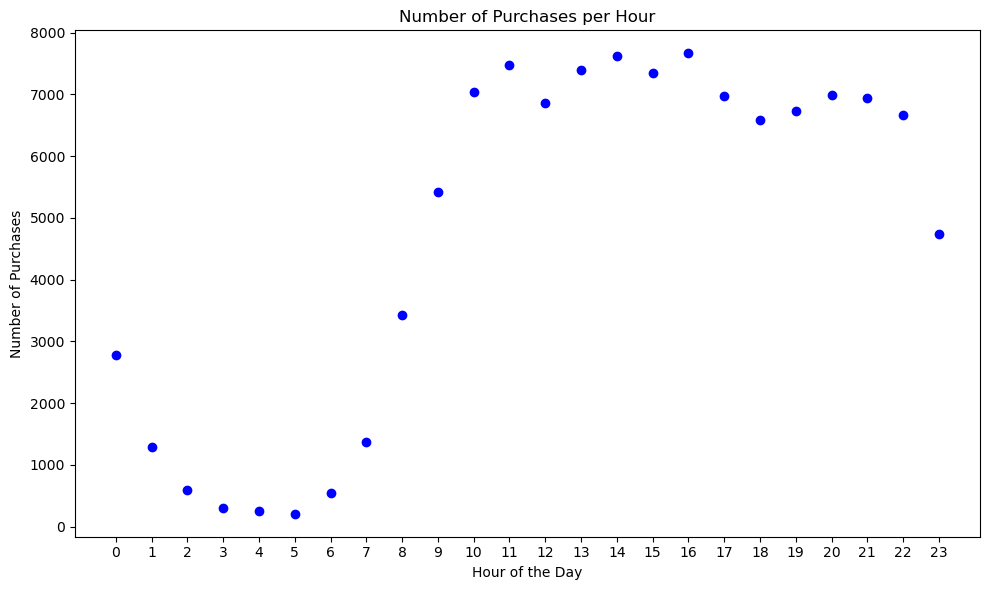

In [56]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(hourly_purchase_count['order_hour'], hourly_purchase_count['order_id'], color='blue')
plt.title('Number of Purchases per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Purchases')
plt.xticks(range(24))
plt.tight_layout()

# Display the plot
plt.show()

4. Which product category that is our top sales?

In [57]:
# Group the data by 'product_category_name' and calculate the total number of purchases
category_sales = new_data.groupby('product_category_name_english')['order_id'].count()

In [58]:
# Find the category with the highest number of purchases
most_purchased_category = category_sales.idxmax()
max_purchases = category_sales.max()

In [59]:
# Display the result
print(f"The most purchased category is '{most_purchased_category}' with {max_purchases} order sales.")

The most purchased category is 'bed_bath_table' with 11684 order sales.


4. Please show top 10 sales the graph by product category

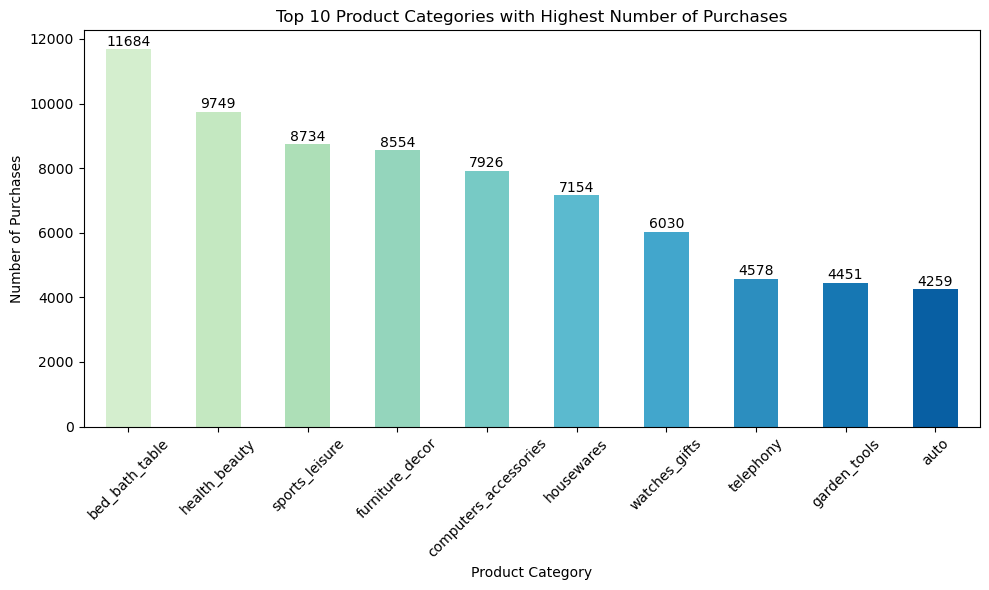

In [60]:
# Find the top 10 categories with the highest number of purchases
top_10_categories = category_sales.nlargest(10)

# Generate a range of colors from green to yellow
colors = plt.cm.GnBu(np.linspace(0.2, 0.9, len(top_10_categories)))

# Plotting
plt.figure(figsize=(10, 6))

# Create the bar plot with colored bars
bars = top_10_categories.sort_values(ascending=False).plot(kind='bar', color=colors)

# Add text labels for the purchase counts on top of each bar
for bar, count in zip(bars.patches, top_10_categories):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center', va='bottom')

plt.title('Top 10 Product Categories with Highest Number of Purchases')
plt.xlabel('Product Category')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

5. Which product category that is make the most sales amount?

In [61]:
# Group the data by 'product_category_name' and calculate the total sales amount
category_sales_amount = data.groupby('product_category_name_english')['payment_value'].sum()

In [62]:
# Find the category with the highest sales amount
most_sales_category = category_sales_amount.idxmax()
max_sales_amount = category_sales_amount.max()

# Display the result
print(f"The product category with the most sales amount is '{most_sales_category}' with total sales of ${max_sales_amount:.2f}.")

The product category with the most sales amount is 'bed_bath_table' with total sales of $1706872.26.


6. Please show top 10 sales the graph by product category

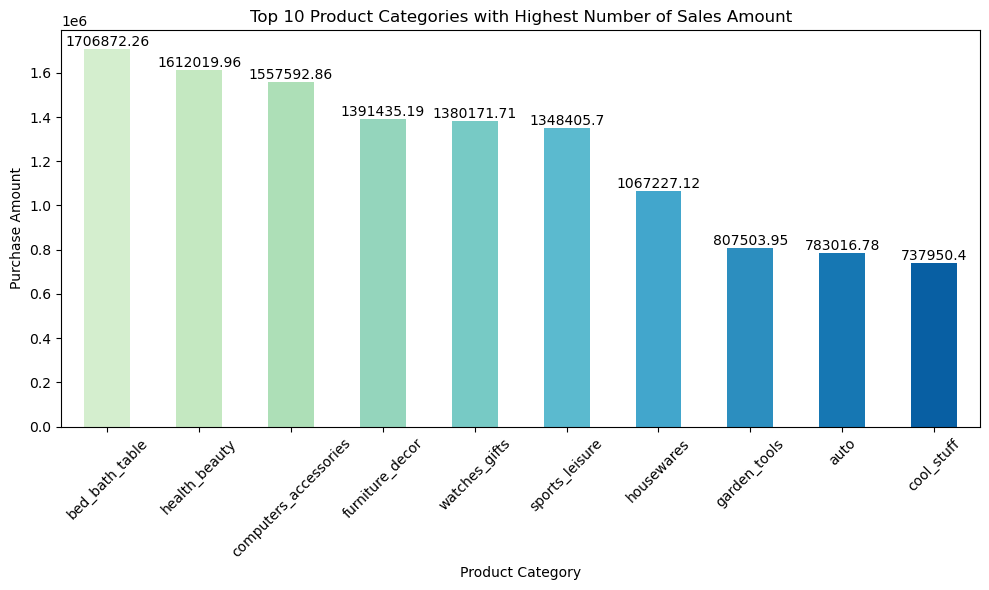

In [63]:
# Find the top 10 categories with the highest sales amount
top_10_categories_salesamount = category_sales_amount.nlargest(10)

# Generate a range of colors from green to yellow
colors = plt.cm.GnBu(np.linspace(0.2, 0.9, len(top_10_categories_salesamount)))

# Plotting
plt.figure(figsize=(10, 6))

# Create the bar plot with colored bars
bars = top_10_categories_salesamount.sort_values(ascending=False).plot(kind='bar', color=colors)

# Add text labels for the purchase counts on top of each bar
for bar, count in zip(bars.patches, top_10_categories_salesamount):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center', va='bottom')

plt.title('Top 10 Product Categories with Highest Number of Sales Amount')
plt.xlabel('Product Category')
plt.ylabel('Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

7. How many average transaction customer buy in our e-commerce? How much average of amount value / customer? how many days customers need in average to repurchase in our e-commerce?

In [64]:
dataset.describe()

frequency       monetary  total_review     avg_score  \
count  93396.000000   93396.000000  93396.000000  93396.000000   
mean       1.143068     213.387431      1.031297      4.104413   
std        0.537718     631.534143      0.201858      1.324810   
min        1.000000       9.590000      1.000000      1.000000   
25%        1.000000      64.000000      1.000000      4.000000   
50%        1.000000     113.030000      1.000000      5.000000   
75%        1.000000     203.390000      1.000000      5.000000   
max       21.000000  109312.640000     15.000000      5.000000   

       total_product_order  total_category_order       recency  
count         93396.000000          93396.000000  93396.000000  
mean              1.067819              1.024990    243.744250  
std               0.313489              0.167607    153.164721  
min               1.000000              1.000000      2.000000  
25%               1.000000              1.000000    120.000000  
50%               1.000000              1.000000    224.000000  
75%               1.000000              1.000000    353.000000  
max              14.000000              5.000000    730.000000

Average transaction: 1.14 (1 transaction)

Average of amount value / customer: 213 Brazillian Real

average days of recency customers: 243 days

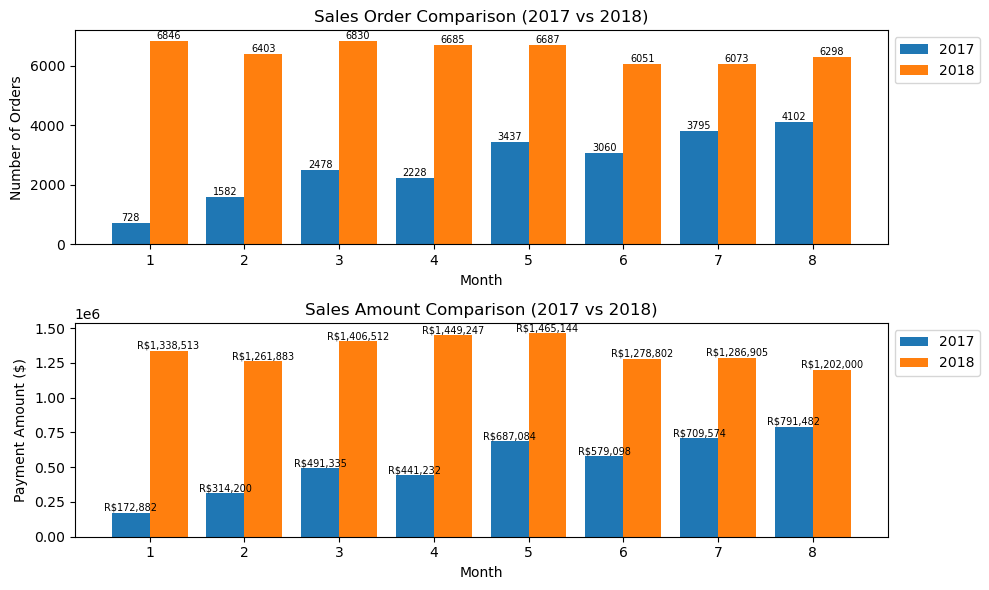

In [65]:
# Convert 'order_purchase_timestamp' to datetime
new_data['order_purchase_timestamp'] = pd.to_datetime(new_data['order_purchase_timestamp'])

# Extract year and month from 'order_purchase_timestamp'
new_data['order_year'] = new_data['order_purchase_timestamp'].dt.year
new_data['order_month'] = new_data['order_purchase_timestamp'].dt.month

# Filter data for the specified periods
period_2017 = (new_data['order_year'] == 2017) & (new_data['order_month'] >= 1) & (new_data['order_month'] <= 8)
period_2018 = (new_data['order_year'] == 2018) & (new_data['order_month'] >= 1) & (new_data['order_month'] <= 8)

# Group data by year, month, and count the number of orders and sum of payment_value
grouped_2017 = new_data[period_2017].groupby(['order_year', 'order_month']).agg({'order_id': 'nunique', 'payment_value': 'sum'}).reset_index()
grouped_2018 = new_data[period_2018].groupby(['order_year', 'order_month']).agg({'order_id': 'nunique', 'payment_value': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot sales order
plt.subplot(2, 1, 1)
bars_2017 = plt.bar(grouped_2017['order_month'] - 0.2, grouped_2017['order_id'], width=0.4, label='2017')
bars_2018 = plt.bar(grouped_2018['order_month'] + 0.2, grouped_2018['order_id'], width=0.4, label='2018')

# Annotate bars with the number of orders
for bar in bars_2017:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom', fontsize=7)
for bar in bars_2018:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom', fontsize=7)

plt.title('Sales Order Comparison (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(grouped_2017['order_month'])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position

# Plot sales amount
plt.subplot(2, 1, 2)
bars_2017 = plt.bar(grouped_2017['order_month'] - 0.2, grouped_2017['payment_value'], width=0.4, label='2017')
bars_2018 = plt.bar(grouped_2018['order_month'] + 0.2, grouped_2018['payment_value'], width=0.4, label='2018')

# Annotate bars with the payment amount (formatted as integer)
for bar in bars_2017:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"R${int(bar.get_height()):,}", ha='center', va='bottom', fontsize=7)
for bar in bars_2018:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"R${int(bar.get_height()):,}", ha='center', va='bottom', fontsize=7)

plt.title('Sales Amount Comparison (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Payment Amount ($)')
plt.xticks(grouped_2017['order_month'])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position

plt.tight_layout()
plt.show()

In [66]:
# Calculate total order count and payment amount for 2017 and 2018
total_orders_2017 = grouped_2017['order_id'].sum()
total_orders_2018 = grouped_2018['order_id'].sum()

total_payment_2017 = grouped_2017['payment_value'].sum()
total_payment_2018 = grouped_2018['payment_value'].sum()

# Print the totals
print("Total Orders in 2017:", total_orders_2017)
print("Total Orders in 2018:", total_orders_2018)

print("Total Payment Amount in 2017:", total_payment_2017)
print("Total Payment Amount in 2018:", total_payment_2018)

Total Orders in 2017: 21410
Total Orders in 2018: 51873
Total Payment Amount in 2017: 4186890.87
Total Payment Amount in 2018: 10689010.0


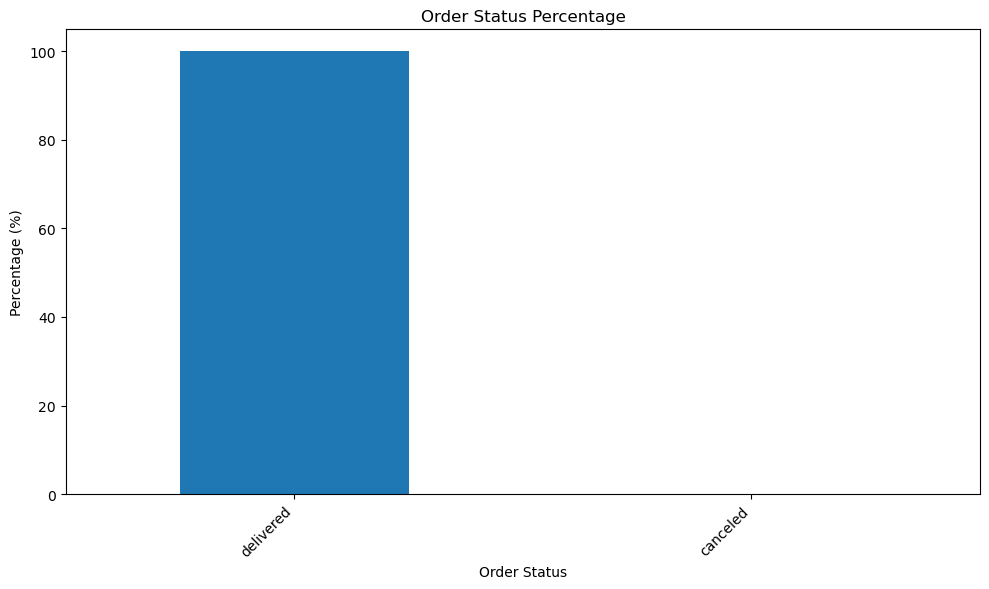

delivered    99.993816
canceled      0.006184
Name: order_status, dtype: float64


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the percentage of each unique order status
order_status_percentage = new_data['order_status'].value_counts(normalize=True) * 100

# Plotting
plt.figure(figsize=(10, 6))
order_status_percentage.plot(kind='bar')
plt.title('Order Status Percentage')
plt.xlabel('Order Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the percentage for each unique order status
print(order_status_percentage)

# Feature Selection

In [68]:
selected_features = ['frequency', 'recency', 'monetary']
data_rfm = dataset[selected_features].copy()
data_rfm.head(3)

frequency  recency  monetary
0         21      415   4118.31
1         20      194  44048.00
2         15      582  11745.00

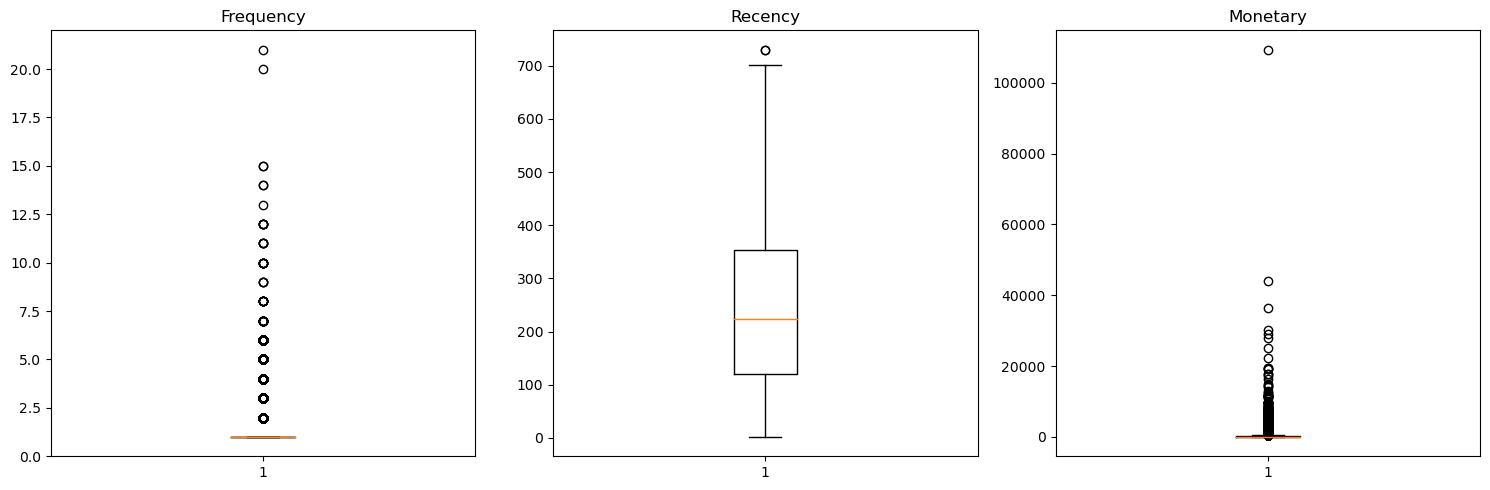

In [69]:
# Create subplots for each column
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for frequency
axs[0].boxplot(data_rfm['frequency'])
axs[0].set_title('Frequency')

# Box plot for recency
axs[1].boxplot(data_rfm['recency'])
axs[1].set_title('Recency')

# Box plot for monetary
axs[2].boxplot(data_rfm['monetary'])
axs[2].set_title('Monetary')

# Adjust layout
plt.tight_layout()

# Show the box plots
plt.show()

# Scaling

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_std = MinMaxScaler().fit_transform(data_rfm)

In [71]:
list_features = list(data_rfm)
new_dataset = pd.DataFrame(data = X_std, columns = list_features)
new_dataset.head()

frequency   recency  monetary
0       1.00  0.567308  0.037590
1       0.95  0.263736  0.402902
2       0.70  0.796703  0.107366
3       0.70  0.383242  0.176872
4       0.65  0.265110  0.067641

# Reduction

In [72]:
X_tsne = TSNE(n_components=2).fit_transform(X_std)
df_tsne = pd.DataFrame(X_tsne)
df_tsne.columns = ['x1', 'x2']
df_tsne.head()

x1          x2
0  10.054447  130.122726
1   9.672864  130.235123
2  10.339241  130.032928
3   9.773689  130.071289
4   9.409034  130.245056

# Best K

<Axes: >

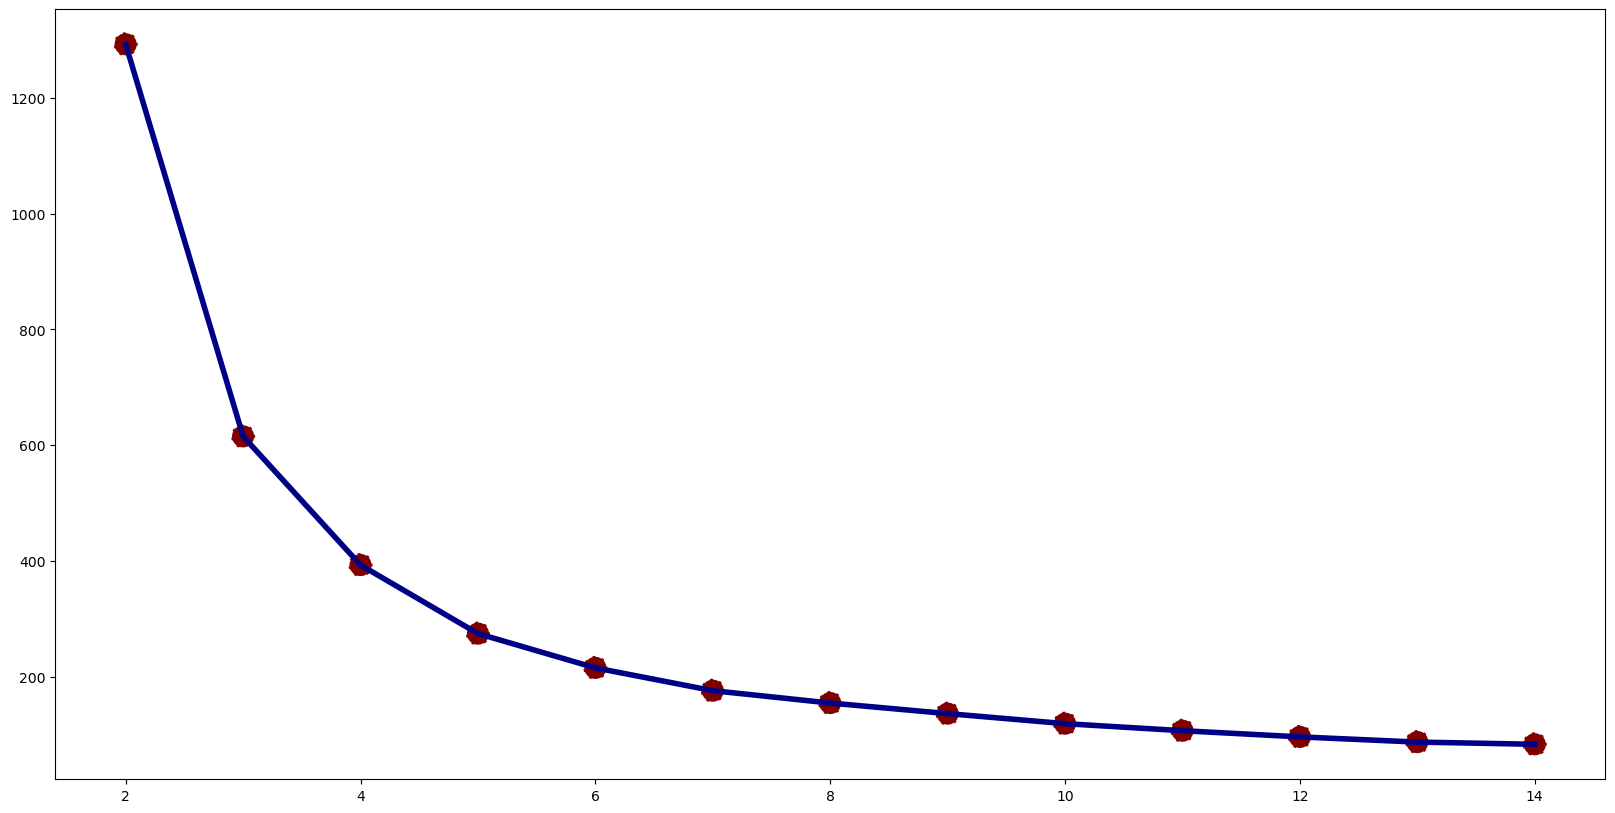

In [73]:
from sklearn.cluster import KMeans
inertia = []

for i in range (2,15):
    kmeans = KMeans (n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20,10))

sns.lineplot(x=range(2,15), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,15), y=inertia, s=300, color='#800000', linestyle='--')

In [74]:
# track sum of squared error
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_tsne)
    sse.append(kmeans.inertia_)

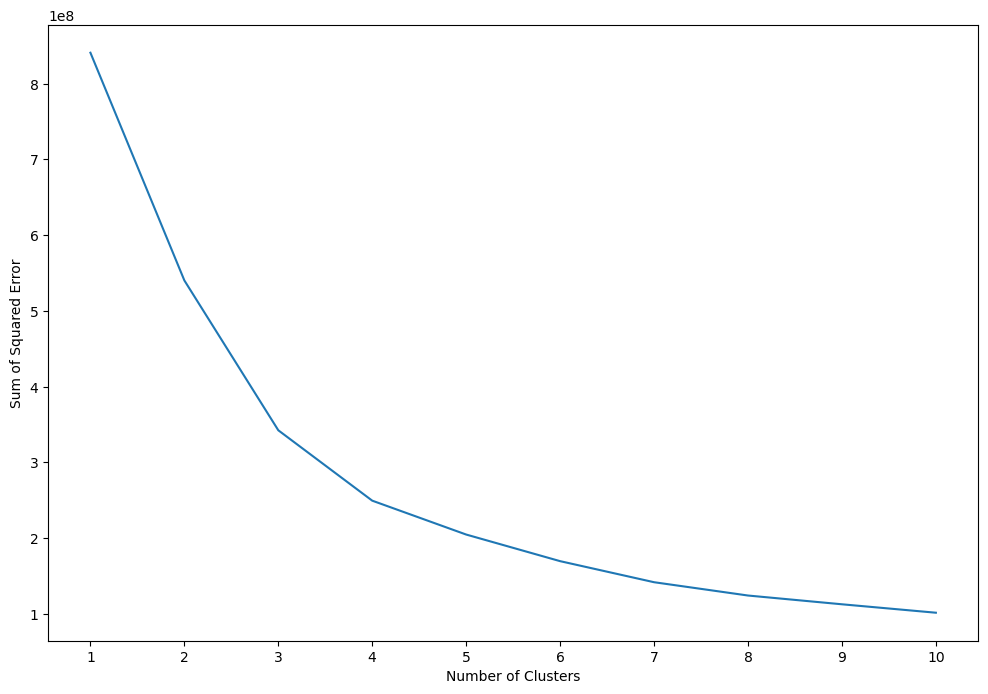

In [75]:
# draw the SSE decline progression
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

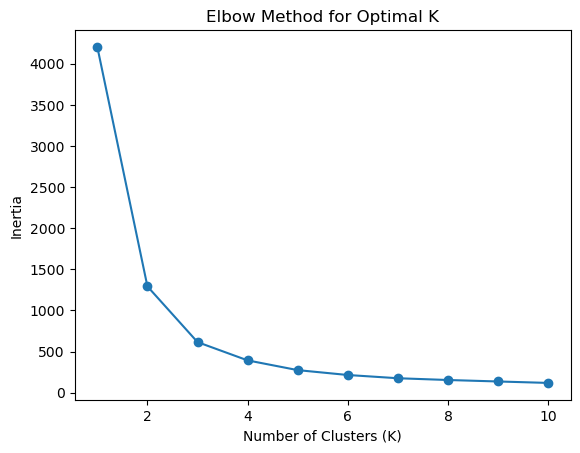

In [76]:
from sklearn.cluster import KMeans
# Define a range of k values to test
k_values = range(1, 11)  # You can adjust the range as needed

# Run KMeans for each k and store inertia values
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_std)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [77]:
range_n_clusters = list(range(2,15))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [78]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_tsne)

KMeans(n_clusters=3, random_state=0)

In [79]:
dataset['clusters'] = kmeans.labels_
df_tsne['clusters'] = kmeans.labels_
dataset.head()

customer_unique_id  frequency  monetary  total_review  \
0  4546caea018ad8c692964e3382debd19         21   4118.31             1   
1  c402f431464c72e27330a67f7b94d4fb         20  44048.00             1   
2  11f97da02237a49c8e783dfda6f50e8e         15  11745.00             1   
3  0f5ac8d5c31de21d2f25e24be15bbffb         15  19342.26             2   
4  f7ea4eef770a388bd5b225acfc546604         14   7402.92             1   

   avg_score  total_product_order  total_category_order  recency  clusters  
0        1.0                    3                     1      415         1  
1        1.0                    1                     1      194         1  
2        5.0                    1                     1      582         1  
3        5.0                    2                     1      281         1  
4        1.0                    1                     1      195         1

In [80]:
df_tsne.head()

x1          x2  clusters
0  10.054447  130.122726         1
1   9.672864  130.235123         1
2  10.339241  130.032928         1
3   9.773689  130.071289         1
4   9.409034  130.245056         1

In [81]:
new_dataset['clusters'] = kmeans.labels_
new_dataset.head()

frequency   recency  monetary  clusters
0       1.00  0.567308  0.037590         1
1       0.95  0.263736  0.402902         1
2       0.70  0.796703  0.107366         1
3       0.70  0.383242  0.176872         1
4       0.65  0.265110  0.067641         1

In [82]:
data_rfm['clusters'] = kmeans.labels_
data_rfm.head()

frequency  recency  monetary  clusters
0         21      415   4118.31         1
1         20      194  44048.00         1
2         15      582  11745.00         1
3         15      281  19342.26         1
4         14      195   7402.92         1

In [83]:
# Specify the path where you want to save the CSV file
csv_file_path = 'data_rfm.csv'

# Use to_csv to write the DataFrame to a CSV file
data_rfm.to_csv(csv_file_path, index=False)

In [84]:
from sklearn.preprocessing import MinMaxScaler

data_rfm_scaled = data_rfm.copy()

# Extract columns for scaling
columns_to_scale = ['frequency', 'recency', 'monetary']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
data_rfm_scaled[columns_to_scale] = scaler.fit_transform(data_rfm[columns_to_scale])

# Retrieve the 'clusters' column
data_rfm_scaled['clusters'] = data_rfm['clusters']
data_rfm_scaled.head()

frequency   recency  monetary  clusters
0       1.00  0.567308  0.037590         1
1       0.95  0.263736  0.402902         1
2       0.70  0.796703  0.107366         1
3       0.70  0.383242  0.176872         1
4       0.65  0.265110  0.067641         1

In [85]:
data_rfm_scaled.describe()

frequency       recency      monetary      clusters
count  93396.000000  93396.000000  93396.000000  93396.000000
mean       0.007153      0.332066      0.001865      0.996831
std        0.026886      0.210391      0.005778      0.820511
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.162088      0.000498      0.000000
50%        0.000000      0.304945      0.000946      1.000000
75%        0.000000      0.482143      0.001773      2.000000
max        1.000000      1.000000      1.000000      2.000000

In [86]:
# Specify the path where you want to save the CSV file
csv_file_path = 'data_rfm_scaled.csv'

# Use to_csv to write the DataFrame to a CSV file
data_rfm_scaled.to_csv(csv_file_path, index=False)

In [87]:
# Calculate mean for each cluster
cluster_means = data_rfm_scaled.groupby('clusters').mean().reset_index()

# Display the calculated means
cluster_means.head()

clusters  frequency   recency  monetary
0         0   0.000000  0.464290  0.001270
1         1   0.021892  0.402026  0.002983
2         2   0.000000  0.130361  0.001374

In [88]:
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
data_rfm.describe(percentiles=perc)

frequency       recency       monetary      clusters
count  93396.000000  93396.000000   93396.000000  93396.000000
mean       1.143068    243.744250     213.387431      0.996831
std        0.537718    153.164721     631.534143      0.820511
min        1.000000      2.000000       9.590000      0.000000
10%        1.000000     47.000000      40.190000      0.000000
20%        1.000000     97.000000      56.080000      0.000000
30%        1.000000    139.000000      71.430000      0.000000
40%        1.000000    182.000000      89.880000      1.000000
50%        1.000000    224.000000     113.030000      1.000000
60%        1.000000    274.000000     140.320000      1.000000
70%        1.000000    319.000000     176.965000      2.000000
80%        1.000000    389.000000     239.320000      2.000000
90%        2.000000    472.000000     406.510000      2.000000
max       21.000000    730.000000  109312.640000      2.000000

In [89]:
cluster_analysis = data_rfm.groupby('clusters').agg({'recency': ['mean'], 'frequency': ['mean'], 'monetary': ['mean', 'median']})
cluster_analysis.head()

recency frequency    monetary         
                mean      mean        mean   median
clusters                                           
0         340.003103   1.00000  148.421443   98.440
1         294.674651   1.43784  335.591358  148.185
2          96.902592   1.00000  159.782919  104.610

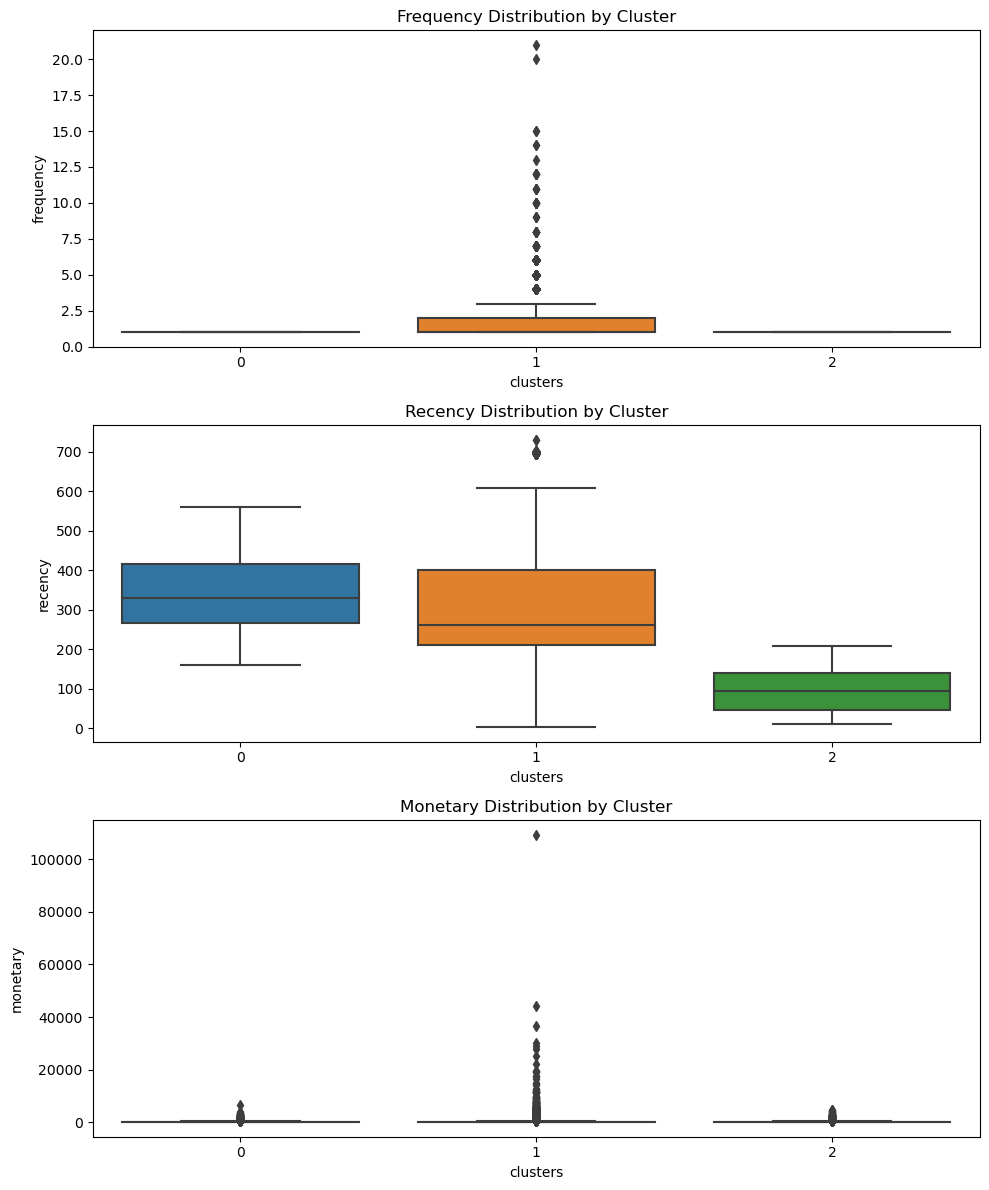

In [90]:
# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Frequency
sns.boxplot(x='clusters', y='frequency', data=data_rfm, ax=axes[0])
axes[0].set_title('Frequency Distribution by Cluster')

# Recency
sns.boxplot(x='clusters', y='recency', data=data_rfm, ax=axes[1])
axes[1].set_title('Recency Distribution by Cluster')

# Monetary
sns.boxplot(x='clusters', y='monetary', data=data_rfm, ax=axes[2])
axes[2].set_title('Monetary Distribution by Cluster')

plt.tight_layout()
plt.show()

In [92]:
# Specify the path where you want to save the CSV file
csv_file_path = 'data_rfm_fix.csv'

# Use to_csv to write the DataFrame to a CSV file
data_rfm.to_csv(csv_file_path, index=False)

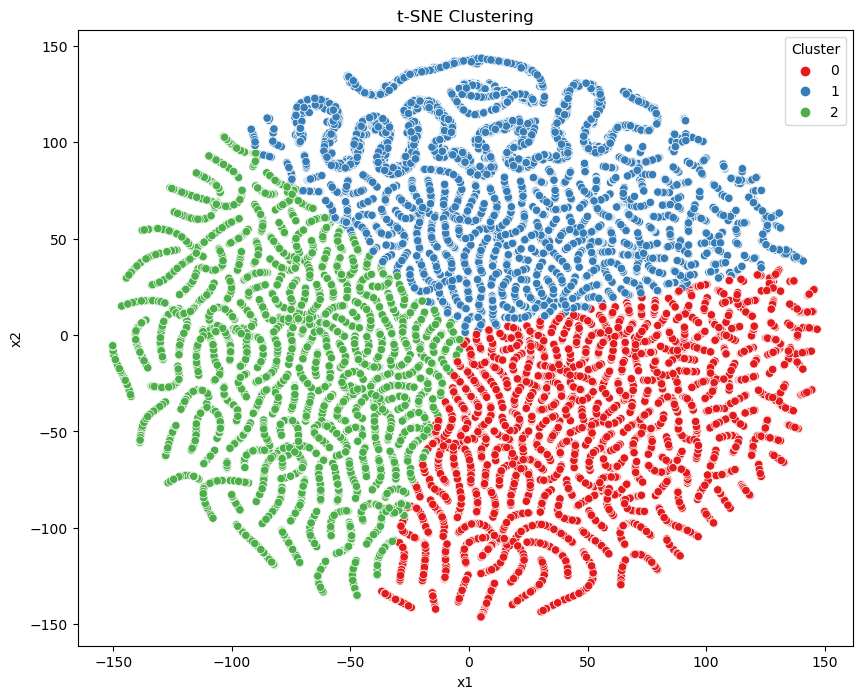

In [93]:
# Plot t-SNE scatter plot with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x1', y='x2', hue='clusters', data=df_tsne, palette='Set1')
plt.title('t-SNE Clustering')
plt.legend(title='Cluster')
plt.show()

In [94]:
merged_data = pd.merge(new_data, dataset, on='customer_unique_id', how='left')
merged_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-10-18 00:00:00              1   
2           2017-10-18 00:00:00              1   
3           2017-08-28 00:00:00              1   
4           2017-08-15 00:00:00              1   

                         product_id  ... order_month order_hour  frequency  \
0  87285b34884572647811a353c7ac498a  ...          10         10          1   
1  87285b34884572647811a353c7ac498a  ...          10         10          1   
2  87285b34884572647811a353c7ac498a  ...          10         10          1   
3  87285b34884572647811a353c7ac498a  ...           8         18          1   
4  87285b34884572647811a353c7ac498a  ...           8         18          1   

   monetary  total_review avg_score  total_product_order  \
0     82.82             2      4.25                    2   
1     82.82             2      4.25                    2   
2     82.82             2      4.25                    2   
3     37.77             1      4.00                    1   
4     37.77             1      5.00                    1   

   total_category_order recency  clusters  
0                     2     337         0  
1                     2     337         0  
2                     2     337         0  
3                     1     385         0  
4                     1     398         0  

[5 rows x 50 columns]

In [96]:
# Group by clusters and product_category_name_english, then calculate the frequency
category_frequency = merged_data.groupby(['clusters', 'product_category_name_english'])['order_id'].count()

# Reset the index and sort by clusters and frequency
category_frequency = category_frequency.reset_index().sort_values(by=['clusters', 'order_id'], ascending=[True, False])

# Create a dictionary to store the top 5 categories for each cluster
top_categories_by_cluster = {}

# Iterate through each cluster and get the top 5 categories
for cluster, group in category_frequency.groupby('clusters'):
    top_categories_by_cluster[cluster] = group.head(5)

# Print the top categories for each cluster
for cluster, categories in top_categories_by_cluster.items():
    print(f"Cluster {cluster}:")
    print(categories)
    print()

Cluster 0:
    clusters product_category_name_english  order_id
6          0                bed_bath_table      3220
63         0                sports_leisure      2827
41         0                 health_beauty      2760
14         0         computers_accessories      2225
37         0               furniture_decor      1911

Cluster 1:
     clusters product_category_name_english  order_id
76          1                bed_bath_table      5667
108         1               furniture_decor      4911
134         1                sports_leisure      3541
84          1         computers_accessories      3486
112         1                 health_beauty      3425

Cluster 2:
     clusters product_category_name_english  order_id
183         2                 health_beauty      3564
147         2                bed_bath_table      2797
208         2                 watches_gifts      2481
203         2                sports_leisure      2366
189         2                    housewares      2218

In [99]:
# Group by clusters and product_category_name_english, then calculate the frequency
category_frequency = merged_data.groupby(['clusters', 'product_category_name_english'])['order_id'].count()

# Reset the index and sort by clusters and frequency
category_frequency = category_frequency.reset_index().sort_values(by=['clusters', 'order_id'], ascending=[True, False])

# Create a dictionary to store the top 5 categories for each cluster
top_categories_by_cluster = {}

# Iterate through each cluster and get the top 5 categories
for cluster, group in category_frequency.groupby('clusters'):
    top_categories_by_cluster[cluster] = group.head(5)

# Create a DataFrame to store the top 5 categories per cluster
top_categories_df = pd.concat(top_categories_by_cluster.values())

# Reset the index for the final DataFrame
top_categories_df = top_categories_df.reset_index(drop=True)

# Display the resulting DataFrame
print(top_categories_df)

    clusters product_category_name_english  order_id
0          0                bed_bath_table      3220
1          0                sports_leisure      2827
2          0                 health_beauty      2760
3          0         computers_accessories      2225
4          0               furniture_decor      1911
5          1                bed_bath_table      5667
6          1               furniture_decor      4911
7          1                sports_leisure      3541
8          1         computers_accessories      3486
9          1                 health_beauty      3425
10         2                 health_beauty      3564
11         2                bed_bath_table      2797
12         2                 watches_gifts      2481
13         2                sports_leisure      2366
14         2                    housewares      2218


In [100]:
# Specify the path where you want to save the CSV file
csv_file_path = 'top_categories_df.csv'

# Use to_csv to write the DataFrame to a CSV file
top_categories_df.to_csv(csv_file_path, index=False)

In [101]:
top_categories_df.head(15)

clusters product_category_name_english  order_id
0          0                bed_bath_table      3220
1          0                sports_leisure      2827
2          0                 health_beauty      2760
3          0         computers_accessories      2225
4          0               furniture_decor      1911
5          1                bed_bath_table      5667
6          1               furniture_decor      4911
7          1                sports_leisure      3541
8          1         computers_accessories      3486
9          1                 health_beauty      3425
10         2                 health_beauty      3564
11         2                bed_bath_table      2797
12         2                 watches_gifts      2481
13         2                sports_leisure      2366
14         2                    housewares      2218

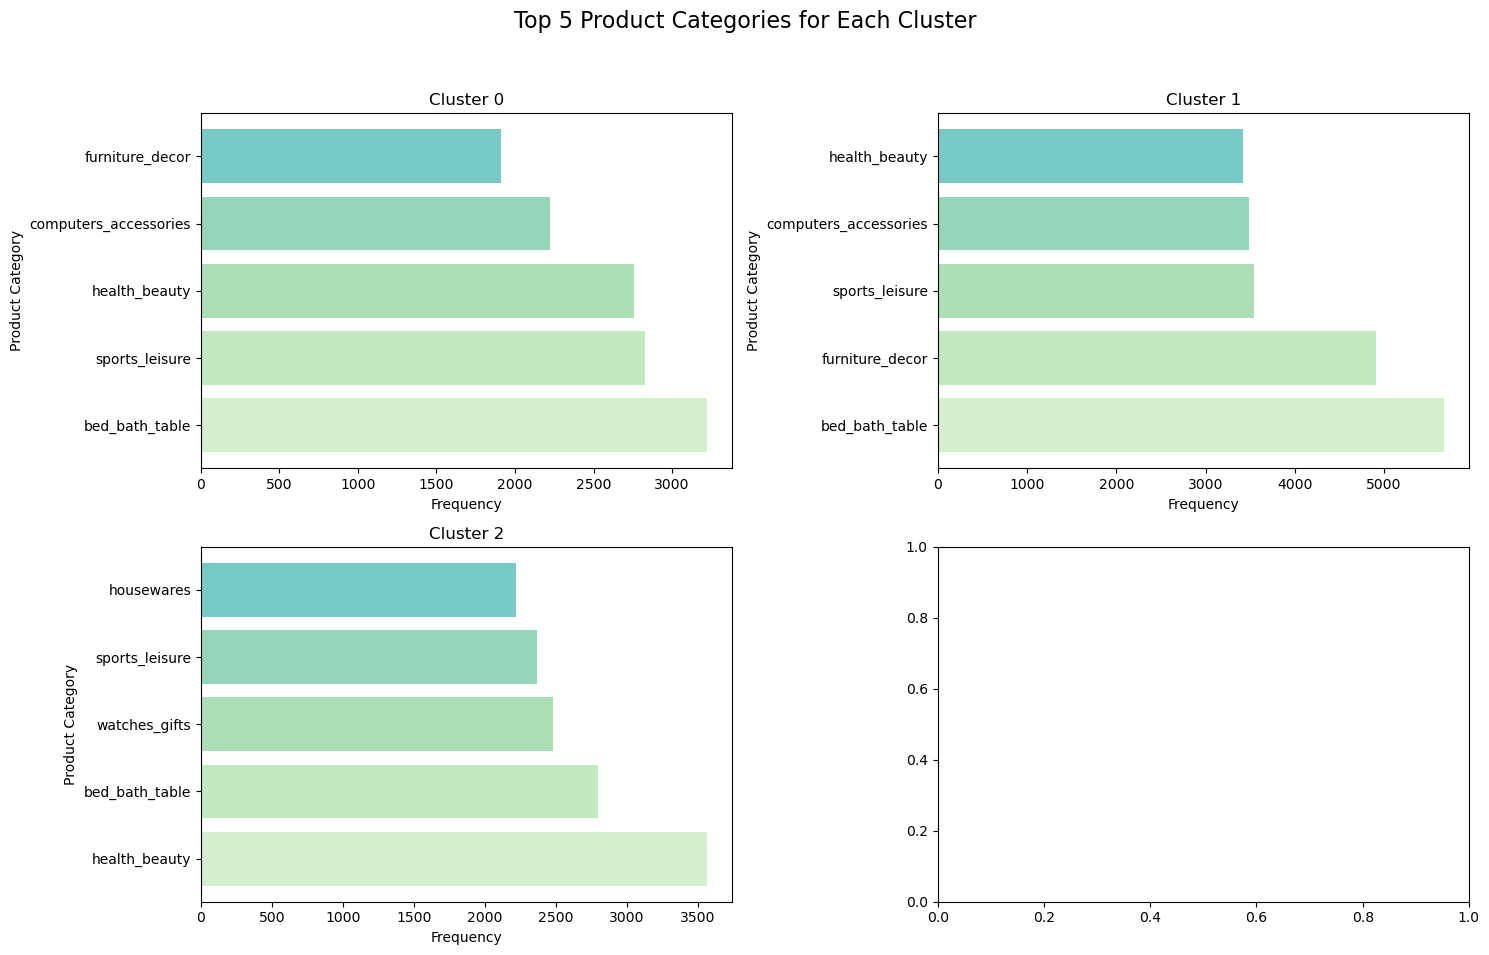

In [102]:
# Determine the number of rows and columns for subplots
num_clusters = len(top_categories_by_cluster)
num_cols = 2  # Number of columns of subplots
num_rows = (num_clusters + 1) // num_cols  # Add 1 to handle odd number of clusters

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle('Top 5 Product Categories for Each Cluster', fontsize=16)

# Flatten the axs array if there's only one row of subplots
if num_rows == 1:
    axs = [axs]

# Create bar plots for each cluster
for i, (cluster, categories) in enumerate(top_categories_by_cluster.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row][col]

    ax.barh(categories['product_category_name_english'], categories['order_id'], color=colors)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Product Category')
    ax.set_title(f'Cluster {cluster}')

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

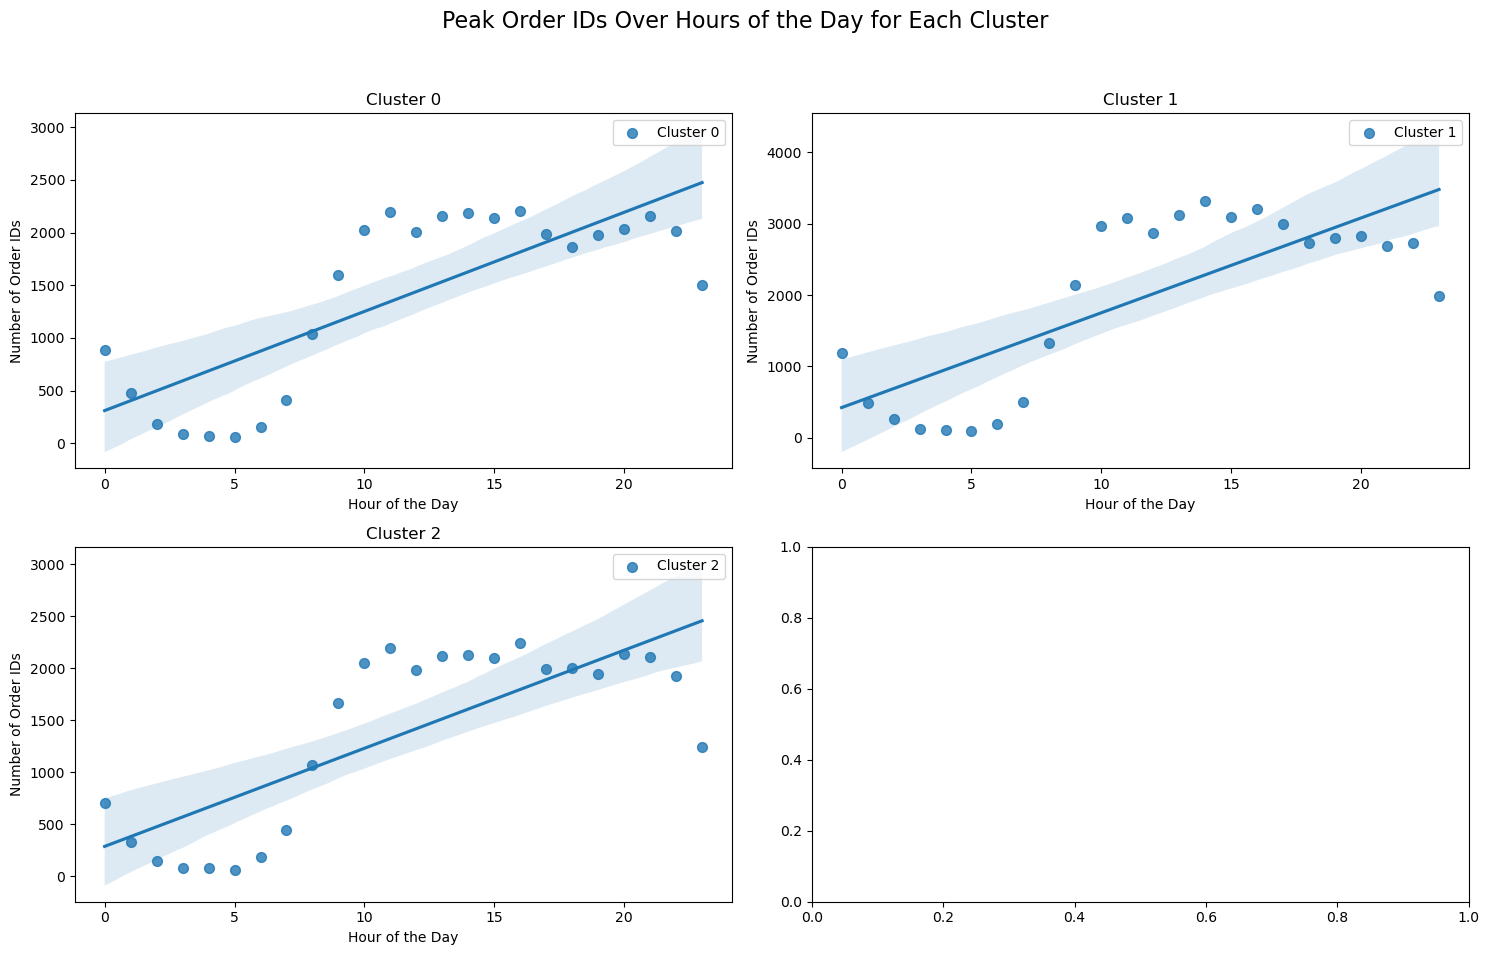

In [103]:
# Group by clusters and order_hour, then calculate the count of order IDs
cluster_order_counts = merged_data.groupby(['clusters', 'order_hour'])['order_id'].count()

# Reset the index and sort by clusters and order_hour
cluster_order_counts = cluster_order_counts.reset_index().sort_values(by=['clusters', 'order_hour'])

# Determine the number of rows and columns for subplots
num_clusters = merged_data['clusters'].nunique()
num_cols = 2  # Number of columns of subplots
num_rows = (num_clusters + 1) // num_cols  # Add 1 to handle odd number of clusters

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle('Peak Order IDs Over Hours of the Day for Each Cluster', fontsize=16)

# Flatten the axs array if there's only one row of subplots
if num_rows == 1:
    axs = [axs]

# Create line plots with trend lines for each cluster
for i in range(num_clusters):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row][col]

    cluster_data = cluster_order_counts[cluster_order_counts['clusters'] == i]
    sns.regplot(data=cluster_data, x='order_hour', y='order_id', ax=ax, scatter_kws={'s': 50}, label=f'Cluster {i}')
    
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Number of Order IDs')
    ax.set_title(f'Cluster {i}')
    ax.legend()

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

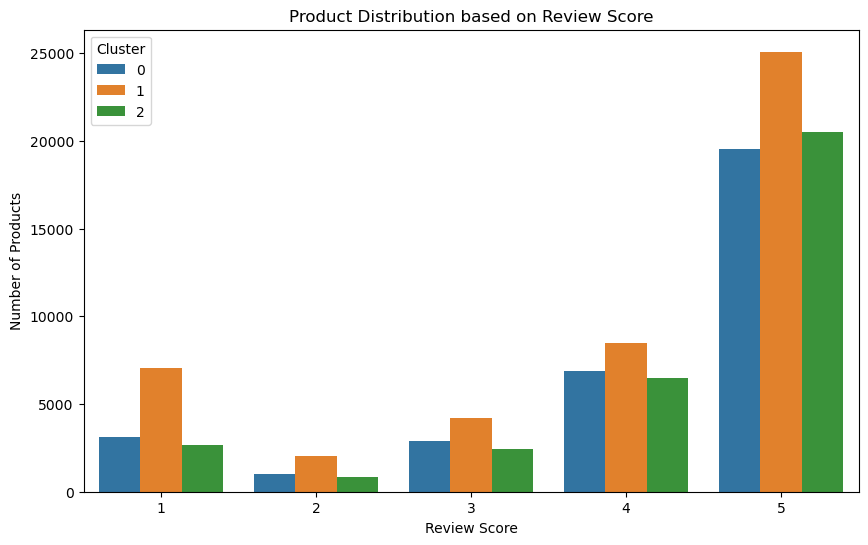

In [104]:
# Create a bar plot of product distribution based on review score
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='review_score', hue='clusters')
plt.title('Product Distribution based on Review Score')
plt.xlabel('Review Score')
plt.ylabel('Number of Products')
plt.legend(title='Cluster')
plt.show()

In [105]:
silhouette_avg = silhouette_score(X_tsne, kmeans.labels_)
print("Average Silhouette Score:", silhouette_avg)

Average Silhouette Score: 0.3627944


In [106]:
# Check for duplicate order_id values in shipping_duration_df
duplicate_orders = shipping_duration_df['order_id'].duplicated(keep='first')
print(shipping_duration_df[duplicate_orders])

                                order_id shipping_duration
1       e481f51cbdc54678b7cc49136f2d6af7   8 days 10:28:40
2       e481f51cbdc54678b7cc49136f2d6af7   8 days 10:28:40
10      a60241fca336b3f14485dff30a172cab   5 days 15:39:35
19      aab7b04f45546e03e7c86b9e8f12368e  47 days 18:38:29
44      2b20baf94a095e002981091891209751   7 days 11:49:56
...                                  ...               ...
115569  ed241a40fbcff0bd9429886e4b20f142  13 days 20:48:39
115573  161f105f25baba98c7604aad9b99d9a6   1 days 03:29:33
115575  fb044859ae3cc0721c694443c343aed4   3 days 21:39:19
115584  9ea64f21920bb6b6972cadb024eabee6  13 days 22:26:06
115602  872b07190c0c9c0f13475d2141c4036a   7 days 07:08:37

[18722 rows x 2 columns]


In [107]:
# If there are duplicate order_id values, you can consider keeping the first occurrence and dropping duplicates
shipping_duration_df = shipping_duration_df.drop_duplicates(subset='order_id', keep='first')

In [108]:
merged_data['shipping_duration'] = merged_data['order_id'].map(shipping_duration_df.set_index('order_id')['shipping_duration'])
merged_data['shipping_duration'] = merged_data['shipping_duration'].dt.days

# Group by order_id, customer_unique_id, and clustersx
grouped = merged_data.groupby(['order_id', 'customer_unique_id', 'clusters', 'avg_score', 'frequency', 'recency', 'monetary'], as_index=False).agg({'shipping_duration': 'mean', 'payment_value': 'mean'})

In [109]:
grouped.head(30)

order_id                customer_unique_id  \
0   00010242fe8c5a6d1ba2dd792cb16214  871766c5855e863f6eccc05f988b23cb   
1   00018f77f2f0320c557190d7a144bdd3  eb28e67c4c0b83846050ddfb8a35d051   
2   000229ec398224ef6ca0657da4fc703e  3818d81c6709e39d06b2738a8d3a2474   
3   00024acbcdf0a6daa1e931b038114c75  af861d436cfc08b2c2ddefd0ba074622   
4   00042b26cf59d7ce69dfabb4e55b4fd9  64b576fb70d441e8f1b2d7d446e483c5   
5   00048cc3ae777c65dbb7d2a0634bc1ea  85c835d128beae5b4ce8602c491bf385   
6   00054e8431b9d7675808bcb819fb4a32  635d9ac1680f03288e72ada3a1035803   
7   000576fe39319847cbb9d288c5617fa6  fda4476abb6307ab3c415b7e6d026526   
8   0005a1a1728c9d785b8e2b08b904576c  639d23421f5517f69d0c3d6e6564cf0e   
9   0005f50442cb953dcd1d21e1fb923495  0782c41380992a5a533489063df0eef6   
10  00061f2a7bc09da83e415a52dc8a4af1  107e6259485efac66428a56f10801f4f   
11  00063b381e2406b52ad429470734ebd5  3fb97204945ca0c01bcf3eee6031c5f1   
12  0006ec9db01a64e59a68b2c340bf65a7  7ed0ea20347f67fe61d1c99fdf8556ae   
13  0008288aa423d2a3f00fcb17cd7d8719  9e4159995424971423b98c4a8bc11529   
14  0009792311464db532ff765bf7b182ae  4987996ddcd0ddb20740fdce7c2bfbb1   
15  0009c9a17f916a706d71784483a5d643  6062db572f3ef38b7a8ff4307abbfad3   
16  000aed2e25dbad2f9ddb70584c5a2ded  6457be0b331148fb5454efc88d1e03d9   
17  000c3e6612759851cc3cbb4b83257986  f5f088001070650f9e9a8cd773621f35   
18  000e562887b1f2006d75e0be9558292e  b2c72d1e9f6430603b8337d8f1394a99   
19  000e63d38ae8c00bbcb5a30573b99628  860fc00d3154ce2346c43ebe47b9b6ce   
20  000e906b789b55f64edcb1f84030f90d  3588484a539617d91500764822230fb6   
21  000f25f4d72195062c040b12dce9a18a  1a6cbc34ea404cb0af7ed74df0999354   
22  001021efaa8636c29475e7734483457d  2193383c470dc9cec894ce78afd0ebd6   
23  0010b2e5201cc5f1ae7e9c6cc8f5bd00  e883f26917e2095c439f70c2cf8c914b   
24  00119ff934e539cf26f92b9ef0cdfed8  13df7b623839b4edc579ee40279d57c8   
25  0011d82c4b53e22e84023405fb467e57  02daaa0e021d624d1784c4ea5cc84ace   
26  00125cb692d04887809806618a2a145f  7ac26eac431c6848694a2de6f0327524   
27  00130c0eee84a3d909e75bc08c5c3ca1  b5910f24d2483d697b37e3857b621061   
28  0013503b13da1eac686219390b7d641b  1544f85dff3797491b60f2a5241d14c1   
29  00137e170939bba5a3134e2386413108  38c3bc2d6df03905e3e8d3d5b079acf4   

    clusters  avg_score  frequency  recency  monetary  shipping_duration  \
0          0        5.0          1      357     72.19                7.0   
1          0        4.5          1      351    284.56               16.0   
2          1        5.0          1      233    216.87                7.0   
3          2        4.0          1       27     25.78                6.0   
4          1        5.0          1      577    218.04               25.0   
5          0        4.0          1      477     34.59                6.0   
6          0        4.0          1      268     31.75                8.0   
7          2        5.0          1       62    880.75                5.0   
8          0        1.0          1      169    157.60                9.0   
9          2        4.0          1       64     65.39                2.0   
10         2        5.0          1      164     68.87                4.0   
11         2        5.0          1       39     57.98               10.0   
12         2        5.0          1       42     97.32                6.0   
13         1        5.0          2      203    253.08               12.0   
14         2        5.0          1       21    127.55                7.0   
15         2        4.0          1      132    650.34                5.0   
16         2        1.0          1      116    152.77                6.0   
17         0        5.0          1      388    112.71                7.0   
18         2        3.0          1      194     41.11               18.0   
19         1        3.0          1      165     56.78                3.0   
20         1        3.0          1      287     33.84               17.0   
21         2        4.0          1      181    164.39        

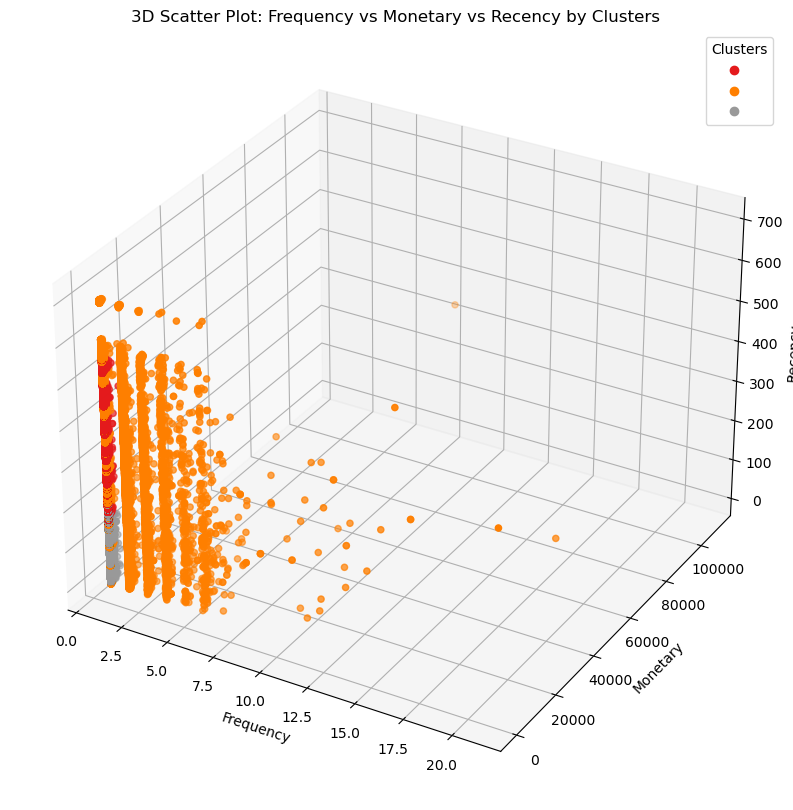

In [110]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assume 'grouped' is your DataFrame with columns 'frequency', 'monetary', 'recency', and 'clusters'

# Create a 3D scatter plot for 'frequency' vs 'monetary' vs 'recency' with hue='clusters'
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    grouped['frequency'],
    grouped['monetary'],
    grouped['recency'],
    c=grouped['clusters'],
    cmap='Set1'
)

# Customize labels and legend
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot: Frequency vs Monetary vs Recency by Clusters')
ax.legend(handles=scatter.legend_elements()[0], title='Clusters')

# Show the plot
plt.show()


# Recommender System

In [111]:
merged_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-10-18 00:00:00              1   
2           2017-10-18 00:00:00              1   
3           2017-08-28 00:00:00              1   
4           2017-08-15 00:00:00              1   

                         product_id  ... order_month order_hour  frequency  \
0  87285b34884572647811a353c7ac498a  ...          10         10          1   
1  87285b34884572647811a353c7ac498a  ...          10         10          1   
2  87285b34884572647811a353c7ac498a  ...          10         10          1   
3  87285b34884572647811a353c7ac498a  ...           8         18          1   
4  87285b34884572647811a353c7ac498a  ...           8         18          1   

   monetary  total_review avg_score  total_product_order  \
0     82.82             2      4.25                    2   
1     82.82             2      4.25                    2   
2     82.82             2      4.25                    2   
3     37.77             1      4.00                    1   
4     37.77             1      5.00                    1   

   total_category_order recency  clusters  
0                     2     337         0  
1                     2     337         0  
2                     2     337         0  
3                     1     385         0  
4                     1     398         0  

[5 rows x 50 columns]

In [112]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 113192
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  object        
 5   order_delivered_carrier_date   113193 non-null  datetime64[ns]
 6   order_delivered_customer_date  113193 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113193 non-null  object        
 8   order_item_id                  113193 non-null  int64         
 9   product_id                     113193 non-null  object        
 10  seller_id                      113193 non-null  object        
 11  

In [113]:
df = merged_data[['customer_unique_id', 'product_id', 'review_score', 'order_purchase_timestamp']]
df.head()

customer_unique_id                        product_id  \
0  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
1  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
2  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
3  3a51803cc0d012c3b5dc8b7528cb05f7  87285b34884572647811a353c7ac498a   
4  ef0996a1a279c26e7ecbd737be23d235  87285b34884572647811a353c7ac498a   

   review_score order_purchase_timestamp  
0             4      2017-10-02 10:56:33  
1             4      2017-10-02 10:56:33  
2             4      2017-10-02 10:56:33  
3             4      2017-08-15 18:29:31  
4             5      2017-08-02 18:24:47

In [114]:
grouped_data = merged_data.groupby('product_id').agg(
    number_of_ratings=('customer_unique_id', 'nunique'),
    mean_rating=('review_score', 'mean')
).reset_index()

In [115]:
grouped_data.head()

product_id  number_of_ratings  mean_rating
0  00066f42aeeb9f3007548bb9d3f33c38                  1          5.0
1  00088930e925c41fd95ebfe695fd2655                  1          4.0
2  0009406fd7479715e4bef61dd91f2462                  1          1.0
3  000b8f95fcb9e0096488278317764d19                  2          5.0
4  000d9be29b5207b54e86aa1b1ac54872                  1          5.0

In [116]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31474 entries, 0 to 31473
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         31474 non-null  object 
 1   number_of_ratings  31474 non-null  int64  
 2   mean_rating        31474 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 737.8+ KB


In [117]:
# Specify the path where you want to save the CSV file
csv_file_path = 'dataset_recommendation_system.csv'

# Use to_csv to write the DataFrame to a CSV file
grouped_data.to_csv(csv_file_path, index=False)

csv_options = {
    'sep': ';',         # Use semicolon as a delimiter
    'encoding': 'utf-8'  # Specify the encoding
}

# Use to_csv with additional options
grouped_data.to_csv(csv_file_path, index=False, **csv_options)

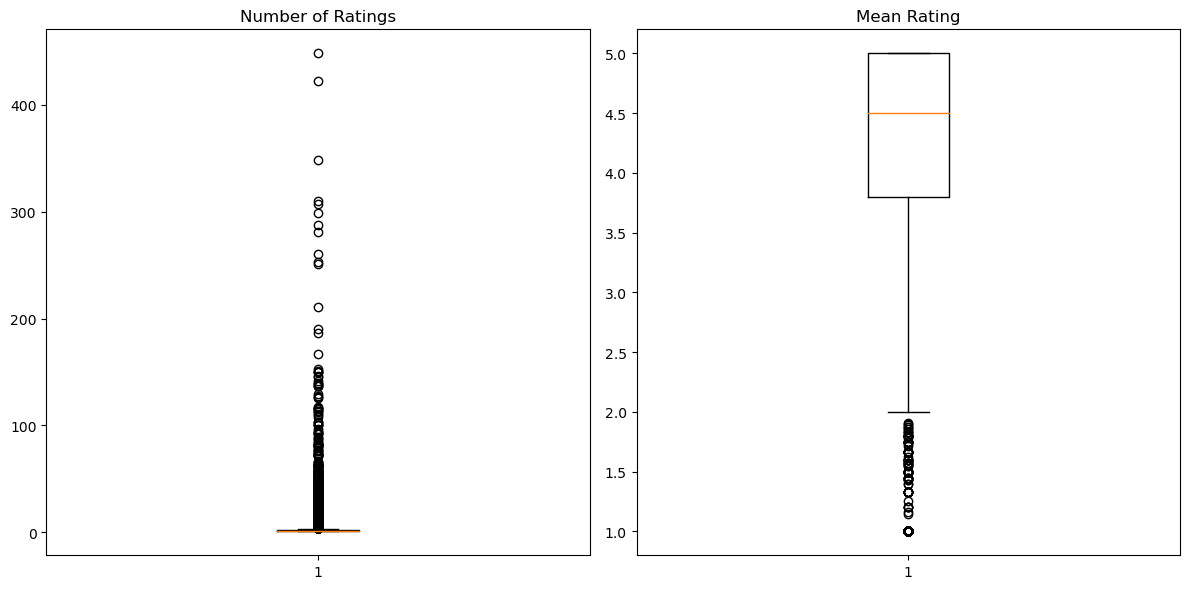

In [118]:
# Create subplots for each column
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Box plot for number_of_ratings
axs[0].boxplot(grouped_data['number_of_ratings'])
axs[0].set_title('Number of Ratings')

# Box plot for mean_rating
axs[1].boxplot(grouped_data['mean_rating'])
axs[1].set_title('Mean Rating')

# Adjust layout
plt.tight_layout()

# Show the box plots
plt.show()

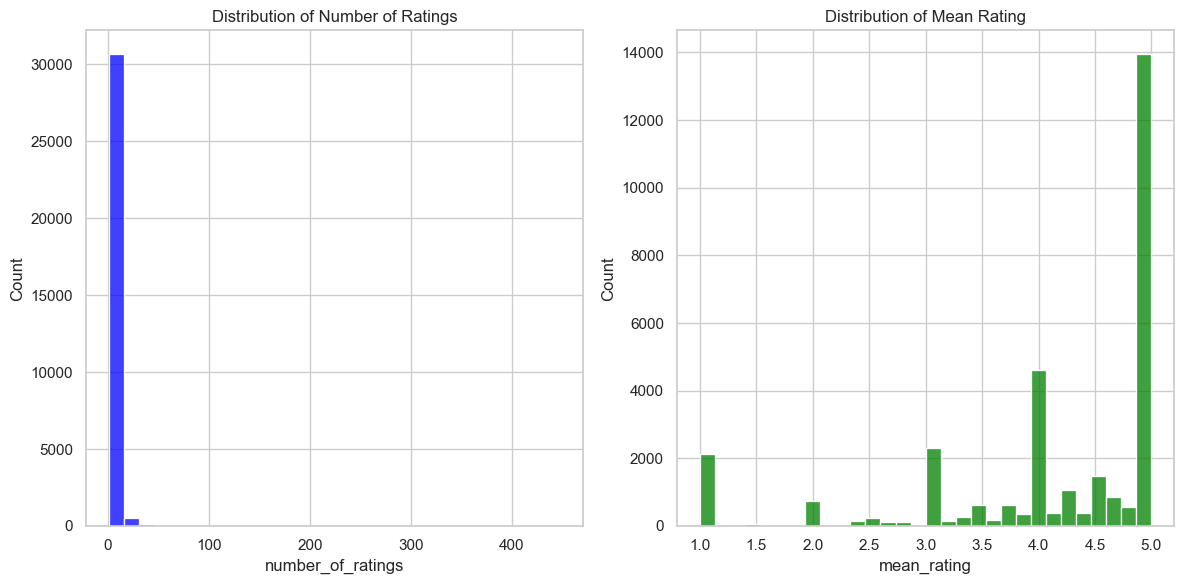

In [119]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Plot the distribution of number_of_ratings
sns.histplot(data=grouped_data, x='number_of_ratings', bins=30, color='blue')
plt.title('Distribution of Number of Ratings')

plt.subplot(1, 2, 2)

# Plot the distribution of mean_rating
sns.histplot(data=grouped_data, x='mean_rating', bins=30, color='green')
plt.title('Distribution of Mean Rating')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

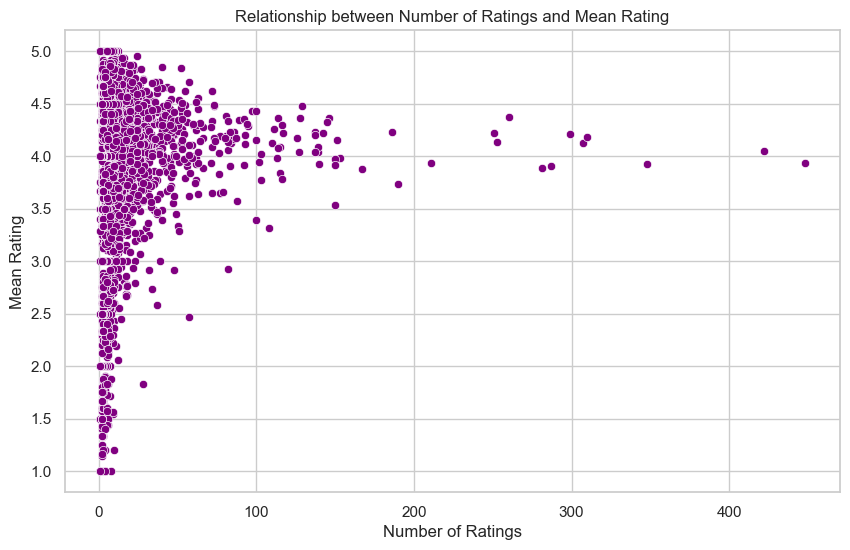

In [120]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='number_of_ratings', y='mean_rating', color='purple')
plt.title('Relationship between Number of Ratings and Mean Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Mean Rating')

# Display the scatterplot
plt.show()

In [121]:
print("Total number of users   :", merged_data.customer_unique_id.nunique())
print("Total number of products  :", merged_data.product_id.nunique())

Total number of users   : 91465
Total number of products  : 31474


In [122]:
# Group the data by product_id and count the number of ratings
ratings_sum = df.groupby('product_id')['review_score'].sum()

# Print the number of ratings for each product
print(ratings_sum)

product_id
00066f42aeeb9f3007548bb9d3f33c38     5
00088930e925c41fd95ebfe695fd2655     4
0009406fd7479715e4bef61dd91f2462     1
000b8f95fcb9e0096488278317764d19    10
000d9be29b5207b54e86aa1b1ac54872     5
                                    ..
fff6177642830a9a94a0f2cba5e476d1     9
fff81cc3158d2725c0655ab9ba0f712c     4
fff9553ac224cec9d15d49f5a263411f     5
fffdb2d0ec8d6a61f0a0a0db3f25b441    25
fffe9eeff12fcbd74a2f2b007dde0c58     4
Name: review_score, Length: 31474, dtype: int64


In [123]:
merged_data.describe()['review_score']

count    113193.000000
mean          4.082505
std           1.345924
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

<Axes: xlabel='product_id'>

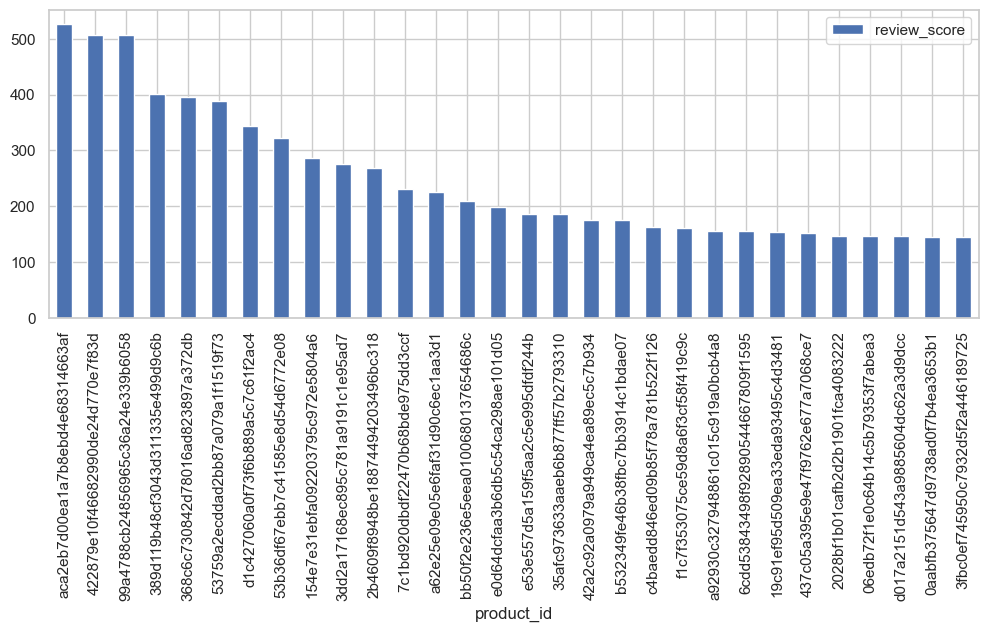

In [124]:
# Most top 30 products
popular_products = pd.DataFrame(merged_data.groupby('product_id')['review_score'].count())
most_popular = popular_products.sort_values('review_score', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

<Axes: xlabel='product_id'>

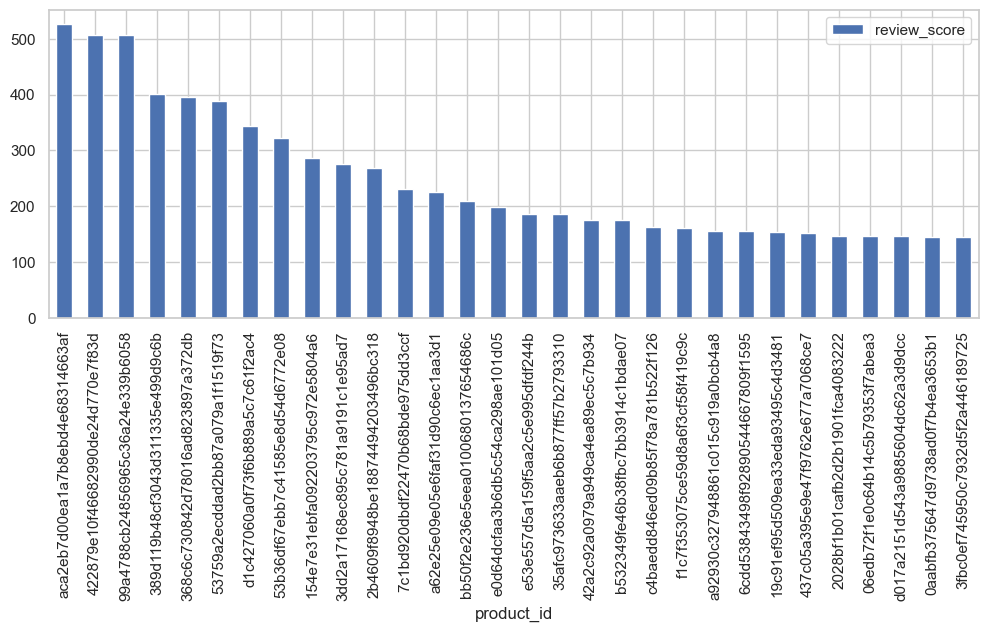

In [125]:
# Most top 30 products
popular_products = pd.DataFrame(merged_data.groupby('product_id')['review_score'].count())
most_popular = popular_products.sort_values('review_score', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

In [126]:
no_of_rated_products_per_user = merged_data.groupby(by='product_id')['review_score'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    526
422879e10f46682990de24d770e7f83d    507
99a4788cb24856965c36a24e339b6058    507
389d119b48cf3043d311335e499d9c6b    402
368c6c730842d78016ad823897a372db    395
Name: review_score, dtype: int64

# SVD

In [128]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

In [129]:
reader = Reader(rating_scale=(1, 5))

# Load the data into the Surprise Dataset
data = Dataset.load_from_df(df[['customer_unique_id', 'product_id', 'review_score']], reader)

In [130]:
df.head()

customer_unique_id                        product_id  \
0  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
1  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
2  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
3  3a51803cc0d012c3b5dc8b7528cb05f7  87285b34884572647811a353c7ac498a   
4  ef0996a1a279c26e7ecbd737be23d235  87285b34884572647811a353c7ac498a   

   review_score order_purchase_timestamp  
0             4      2017-10-02 10:56:33  
1             4      2017-10-02 10:56:33  
2             4      2017-10-02 10:56:33  
3             4      2017-08-15 18:29:31  
4             5      2017-08-02 18:24:47

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 113192
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        113193 non-null  object        
 1   product_id                113193 non-null  object        
 2   review_score              113193 non-null  int64         
 3   order_purchase_timestamp  113193 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.3+ MB


In [127]:
# Specify the path where you want to save the CSV file
csv_file_path = 'df.csv'

# Use to_csv to write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [132]:
trainset, testset = train_test_split(data, test_size=0.3)

In [133]:
algo = SVD()
algo.fit(trainset)

In [134]:
from surprise import accuracy

# Predict ratings on the trainset and testset
train_predictions = algo.test(trainset.build_testset())
test_predictions = algo.test(testset)

# Calculate RMSE, MAE, and MAPE for train set
rmse_train = accuracy.rmse(train_predictions)
mae_train = accuracy.mae(train_predictions)

print("SVD RMSE (Train):", rmse_train)
print("SVD MAE (Train):", mae_train)

# Calculate RMSE, MAE, and MAPE for test set
rmse_test = accuracy.rmse(test_predictions)
mae_test = accuracy.mae(test_predictions)

print("SVD RMSE (Test):", rmse_test)
print("SVD MAE (Test):", mae_test)

RMSE: 0.8046
MAE:  0.6234
SVD RMSE (Train): 0.8046087009049463
SVD MAE (Train): 0.6234141277780808
RMSE: 1.2192
MAE:  0.9440
SVD RMSE (Test): 1.2191923382520384
SVD MAE (Test): 0.9440396580657674


In [135]:
user_id = "7c396fd4830fd04220f754e42b4e5bff"
product_id = "87285b34884572647811a353c7ac498a"

predicted_rating = algo.predict(user_id, product_id)
print("Predicted Rating:", predicted_rating.est)

Predicted Rating: 3.990704461909637


In [136]:
# Find the actual review_score for the user_id and product_id
actual_rating = merged_data[(merged_data['customer_unique_id'] == "7c396fd4830fd04220f754e42b4e5bff") & (merged_data['product_id'] == "87285b34884572647811a353c7ac498a")]['review_score'].values[0]

print("Actual Review Score:", actual_rating)

Actual Review Score: 4


# Normal Predictor

In [137]:
from surprise import Dataset, Reader, NormalPredictor
from surprise import accuracy

# Initialize NormalPredictor algorithm (a random predictor)
algo_normal = NormalPredictor()

# Train the algorithm on the trainset
algo_normal.fit(trainset)

# Predict ratings on the trainset and testset
train_predictions_normal = algo_normal.test(trainset.build_testset())
test_predictions_normal = algo_normal.test(testset)

# Calculate RMSE for train and test sets
rmse_train_normal = accuracy.rmse(train_predictions_normal)
mae_train_normal = accuracy.mae(train_predictions_normal)
rmse_test_normal = accuracy.rmse(test_predictions_normal)
mae_test_normal = accuracy.mae(test_predictions_normal)

print("NormalPredictor RMSE (Train):", rmse_train_normal)
print("NormalPredictor RMSE (Test):", rmse_test_normal)
print("Normal MAE (Train):", mae_train_normal)
print("Normal MAE (Test):", mae_test_normal)

RMSE: 1.7163
MAE:  1.2978
RMSE: 1.7185
MAE:  1.3028
NormalPredictor RMSE (Train): 1.716310638035047
NormalPredictor RMSE (Test): 1.7184987434060357
Normal MAE (Train): 1.2978369515169441
Normal MAE (Test): 1.3028328954301818


Comparing the results:

SVD vs Normal Predictor on Training Set:
SVD has significantly lower RMSE (0.8017 vs. 1.7229) and lower MAE (0.6257 vs. 1.3057) on the training set. This indicates that SVD performs much better in terms of accuracy.

SVD vs Normal Predictor on Test Set:
SVD still has lower RMSE (1.2083 vs. 1.7217) and lower MAE (0.9411 vs. 1.3027) on the test set. Again, SVD is providing better accuracy.

# Hyperparameter SVD

In [138]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import accuracy

# Define the parameter grid for hyperparameter tuning
param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [10, 20, 30],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.1, 0.2]}

# Create an instance of the SVD algorithm
svd = SVD()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
grid_search.fit(data)

In [139]:
# Print the best RMSE and MAE scores
print("Best RMSE Score:", grid_search.best_score['rmse'])
print("Best MAE Score:", grid_search.best_score['mae'])

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params)

# Train the algorithm on the full training set with the best hyperparameters
best_svd = grid_search.best_estimator['rmse']
best_svd.fit(trainset)

# Predict ratings on the trainset and testset
train_predictions_bestsvd = best_svd.test(trainset.build_testset())
test_predictions_bestsvd = best_svd.test(testset)

# Calculate RMSE, MAE, and MAPE for train set
rmse_train = accuracy.rmse(train_predictions_bestsvd)
mae_train = accuracy.mae(train_predictions_bestsvd)

print("Hyper SVD RMSE (Train):", rmse_train)
print("Hyper SVD MAE (Train):", mae_train)

# Calculate RMSE, MAE, and MAPE for test set
rmse_test = accuracy.rmse(test_predictions_bestsvd)
mae_test = accuracy.mae(test_predictions_bestsvd)

print("Hyper SVD RMSE (Test):", rmse_test)
print("Hyper SVD MAE (Test):", mae_test)

Best RMSE Score: 1.181705059054712
Best MAE Score: 0.8952028381295932
Best Hyperparameters: {'rmse': {'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}}
RMSE: 0.5621
MAE:  0.4144
Hyper SVD RMSE (Train): 0.562147744465837
Hyper SVD MAE (Train): 0.41435269862534757
RMSE: 1.1831
MAE:  0.8921
Hyper SVD RMSE (Test): 1.183059414757848
Hyper SVD MAE (Test): 0.8921109740301121


In [142]:
results = {
    'SVD': {'RMSE (Train)': 0.8046087009049463, 'MAE (Train)': 0.6234141277780808, 'RMSE (Test)': 1.2191923382520384, 'MAE (Test)': 0.9440396580657674},
    'NormalPredictor': {'RMSE (Train)': 1.716310638035047, 'RMSE (Test)': 1.7184987434060357, 'MAE (Train)': 1.2978369515169441, 'MAE (Test)': 1.3028328954301818},
    'Hyper SVD': {'RMSE (Train)': 0.562147744465837, 'MAE (Train)': 0.41435269862534757, 'RMSE (Test)': 1.183059414757848, 'MAE (Test)': 0.8921109740301121}
}

# Create a DataFrame
results_df = pd.DataFrame(results).T

results_df.head()

RMSE (Train)  MAE (Train)  RMSE (Test)  MAE (Test)
SVD                  0.804609     0.623414     1.219192    0.944040
NormalPredictor      1.716311     1.297837     1.718499    1.302833
Hyper SVD            0.562148     0.414353     1.183059    0.892111

In [143]:
# Specify the path where you want to save the CSV file
csv_file_path = 'results_df.csv'

# Use to_csv to write the DataFrame to a CSV file
results_df.to_csv(csv_file_path, index=False)

# Use SVD to determine each clusters based on T-SNE clustering

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 113192
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        113193 non-null  object        
 1   product_id                113193 non-null  object        
 2   review_score              113193 non-null  int64         
 3   order_purchase_timestamp  113193 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.3+ MB


In [145]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 113192
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  object        
 5   order_delivered_carrier_date   113193 non-null  datetime64[ns]
 6   order_delivered_customer_date  113193 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113193 non-null  object        
 8   order_item_id                  113193 non-null  int64         
 9   product_id                     113193 non-null  object        
 10  seller_id                      113193 non-null  object        
 11  

In [146]:
# Merge df with merged_data on 'customer_unique_id' and 'product_id'
merged_df = df.merge(merged_data[['customer_unique_id', 'product_id', 'clusters', 'product_category_name_english', 'seller_city', 'price']], on=['customer_unique_id', 'product_id'], how='left')
merged_df.head()

customer_unique_id                        product_id  \
0  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
1  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
2  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
3  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   
4  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a   

   review_score order_purchase_timestamp  clusters  \
0             4      2017-10-02 10:56:33         0   
1             4      2017-10-02 10:56:33         0   
2             4      2017-10-02 10:56:33         0   
3             4      2017-10-02 10:56:33         0   
4             4      2017-10-02 10:56:33         0   

  product_category_name_english seller_city  price  
0                    housewares        maua  29.99  
1                    housewares        maua  29.99  
2                    housewares        maua  29.99  
3                    housewares        maua  29.99  
4                    housewares        maua  29.99

In [147]:
# Specify the path where you want to save the CSV file
csv_file_path = 'merged_df.csv'

# Use to_csv to write the DataFrame to a CSV file
merged_df.to_csv(csv_file_path, index=False)

In [148]:
for cluster_id in merged_df['clusters'].unique():
    cluster_data = merged_df[merged_df['clusters'] == cluster_id]
    product_ids = cluster_data['product_id'].unique()
    
    print(f"Top 5 Product Names (Cluster {cluster_id}):")
    
    for product_id in product_ids:
        estimated_rating = best_svd.predict(cluster_data.iloc[0]['customer_unique_id'], product_id).est
        product_name = cluster_data[cluster_data['product_id'] == product_id]['product_category_name_english'].iloc[0]
        print(f"{product_name} (Estimated Rating: {estimated_rating:.2f})")
    
    print("\n")

Top 5 Product Names (Cluster 0):
housewares (Estimated Rating: 3.97)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.35)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.51)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 4.48)
housewares (Estimated Rating: 4.71)
housewares (Estimated Rating: 4.21)
housewares (Estimated Rating: 4.21)
housewares (Estimated Rating: 4.26)
housewares (Estimated Rating: 4.55)
housewares (Estimated Rating: 4.51)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 3.81)
housewares (Estimated Rating: 4.23)
housewares (Estimated Rating: 4.50)
housewares (Estimated Rating: 4.63)
housewares (Estimated Rating: 3.86)
housewares (Estimated Rating: 4.80)
housewares (Estimated Rating: 4.74)
housewares (Estimated Rating: 3.85)
housewares (Estimated Rating: 3.15)
housewares (Estimated Rating: 4.54)
housewares (Estimated Rating: 4

housewares (Estimated Rating: 3.65)
housewares (Estimated Rating: 4.39)
housewares (Estimated Rating: 3.16)
housewares (Estimated Rating: 4.65)
housewares (Estimated Rating: 3.52)
housewares (Estimated Rating: 4.38)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 3.61)
housewares (Estimated Rating: 3.67)
housewares (Estimated Rating: 4.04)
housewares (Estimated Rating: 4.38)
housewares (Estimated Rating: 4.23)
housewares (Estimated Rating: 4.66)
housewares (Estimated Rating: 4.36)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.50)
housewares (Estimated Rating: 4.48)
housewares (Estimated Rating: 4.58)
housewares (Estimated Rating: 4.59)
housewares (Estimated Rating: 4.45)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 2.77)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 4.47)
housewares (Estimated Rating: 4.21)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating

housewares (Estimated Rating: 4.42)
housewares (Estimated Rating: 4.60)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 3.89)
housewares (Estimated Rating: 4.22)
housewares (Estimated Rating: 3.54)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 3.98)
housewares (Estimated Rating: 3.22)
housewares (Estimated Rating: 4.01)
housewares (Estimated Rating: 4.36)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 3.89)
housewares (Estimated Rating: 4.67)
housewares (Estimated Rating: 4.55)
housewares (Estimated Rating: 4.49)
housewares (Estimated Rating: 4.23)
housewares (Estimated Rating: 4.16)
housewares (Estimated Rating: 4.33)
housewares (Estimated Rating: 3.16)
housewares (Estimated Rating: 3.95)
housewares (Estimated Rating: 4.47)
housewares (Estimated Rating: 4.07)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.67)
housewares (Estimated Rating: 3.79)
housewares (Estimated Rating

baby (Estimated Rating: 4.16)
baby (Estimated Rating: 3.90)
baby (Estimated Rating: 4.51)
baby (Estimated Rating: 3.24)
baby (Estimated Rating: 4.42)
baby (Estimated Rating: 3.62)
baby (Estimated Rating: 4.40)
baby (Estimated Rating: 4.51)
baby (Estimated Rating: 3.90)
baby (Estimated Rating: 4.52)
baby (Estimated Rating: 4.32)
baby (Estimated Rating: 4.24)
baby (Estimated Rating: 3.70)
baby (Estimated Rating: 4.41)
baby (Estimated Rating: 4.52)
baby (Estimated Rating: 4.26)
baby (Estimated Rating: 4.46)
baby (Estimated Rating: 3.62)
baby (Estimated Rating: 3.93)
baby (Estimated Rating: 4.46)
baby (Estimated Rating: 4.20)
baby (Estimated Rating: 3.64)
baby (Estimated Rating: 4.36)
baby (Estimated Rating: 4.69)
baby (Estimated Rating: 4.44)
baby (Estimated Rating: 3.68)
baby (Estimated Rating: 4.24)
baby (Estimated Rating: 4.24)
baby (Estimated Rating: 4.44)
baby (Estimated Rating: 3.25)
baby (Estimated Rating: 4.50)
baby (Estimated Rating: 4.20)
baby (Estimated Rating: 4.32)
baby (Esti

cool_stuff (Estimated Rating: 4.39)
cool_stuff (Estimated Rating: 4.49)
cool_stuff (Estimated Rating: 4.86)
cool_stuff (Estimated Rating: 3.89)
cool_stuff (Estimated Rating: 4.61)
cool_stuff (Estimated Rating: 4.11)
cool_stuff (Estimated Rating: 4.06)
cool_stuff (Estimated Rating: 4.54)
cool_stuff (Estimated Rating: 4.41)
cool_stuff (Estimated Rating: 3.85)
cool_stuff (Estimated Rating: 3.93)
cool_stuff (Estimated Rating: 4.51)
cool_stuff (Estimated Rating: 3.87)
cool_stuff (Estimated Rating: 4.60)
cool_stuff (Estimated Rating: 4.60)
cool_stuff (Estimated Rating: 4.57)
cool_stuff (Estimated Rating: 4.61)
cool_stuff (Estimated Rating: 4.50)
cool_stuff (Estimated Rating: 4.59)
cool_stuff (Estimated Rating: 4.81)
cool_stuff (Estimated Rating: 4.40)
cool_stuff (Estimated Rating: 4.04)
cool_stuff (Estimated Rating: 4.36)
cool_stuff (Estimated Rating: 4.25)
cool_stuff (Estimated Rating: 4.59)
cool_stuff (Estimated Rating: 4.19)
cool_stuff (Estimated Rating: 4.60)
cool_stuff (Estimated Rating

sports_leisure (Estimated Rating: 4.33)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.41)
sports_leisure (Estimated Rating: 4.05)
sports_leisure (Estimated Rating: 4.51)
sports_leisure (Estimated Rating: 3.91)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.52)
sports_leisure (Estimated Rating: 4.43)
sports_leisure (Estimated Rating: 4.56)
sports_leisure (Estimated Rating: 4.04)
sports_leisure (Estimated Rating: 4.80)
sports_leisure (Estimated Rating: 4.71)
sports_leisure (Estimated Rating: 4.39)
sports_leisure (Estimated Rating: 3.16)
sports_leisure (Estimated Rating: 4.22)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 3.52)
sports_leisure (Estimated Rating: 4.47)
sports_leisure (Estimated Rating: 3.86)
sports_leisure (Estimated Rating: 4.83)
sports_leisure (Estimated Rating: 4.54)
sports_leisure (Estimated Rating: 4.49)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.62)


sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.37)
sports_leisure (Estimated Rating: 4.46)
sports_leisure (Estimated Rating: 4.65)
sports_leisure (Estimated Rating: 4.50)
sports_leisure (Estimated Rating: 4.39)
sports_leisure (Estimated Rating: 4.48)
sports_leisure (Estimated Rating: 4.40)
sports_leisure (Estimated Rating: 4.40)
sports_leisure (Estimated Rating: 4.23)
sports_leisure (Estimated Rating: 3.85)
sports_leisure (Estimated Rating: 4.42)
sports_leisure (Estimated Rating: 3.95)
sports_leisure (Estimated Rating: 4.71)
sports_leisure (Estimated Rating: 3.81)
sports_leisure (Estimated Rating: 3.70)
sports_leisure (Estimated Rating: 4.76)
sports_leisure (Estimated Rating: 4.66)
sports_leisure (Estimated Rating: 4.31)
sports_leisure (Estimated Rating: 4.21)
sports_leisure (Estimated Rating: 4.26)
sports_leisure (Estimated Rating: 4.69)
sports_leisure (Estimated Rating: 4.47)
sports_leisure (Estimated Rating: 4.16)
sports_leisure (Estimated Rating: 4.08)


sports_leisure (Estimated Rating: 4.38)
sports_leisure (Estimated Rating: 4.60)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.48)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.40)
sports_leisure (Estimated Rating: 4.57)
sports_leisure (Estimated Rating: 4.50)
sports_leisure (Estimated Rating: 4.61)
sports_leisure (Estimated Rating: 4.59)
sports_leisure (Estimated Rating: 4.00)
sports_leisure (Estimated Rating: 4.48)
sports_leisure (Estimated Rating: 3.76)
sports_leisure (Estimated Rating: 4.62)
sports_leisure (Estimated Rating: 4.21)
sports_leisure (Estimated Rating: 4.33)
sports_leisure (Estimated Rating: 3.47)
sports_leisure (Estimated Rating: 4.54)
sports_leisure (Estimated Rating: 4.71)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.37)
sports_leisure (Estimated Rating: 4.58)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.46)
sports_leisure (Estimated Rating: 4.48)


sports_leisure (Estimated Rating: 4.13)
sports_leisure (Estimated Rating: 4.19)
sports_leisure (Estimated Rating: 3.46)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.38)
sports_leisure (Estimated Rating: 3.54)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.01)
sports_leisure (Estimated Rating: 4.19)
sports_leisure (Estimated Rating: 4.54)
sports_leisure (Estimated Rating: 4.52)
sports_leisure (Estimated Rating: 4.68)
sports_leisure (Estimated Rating: 3.55)
sports_leisure (Estimated Rating: 4.83)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.06)
sports_leisure (Estimated Rating: 3.86)
sports_leisure (Estimated Rating: 4.70)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.35)
sports_leisure (Estimated Rating: 4.02)
sports_leisure (Estimated Rating: 3.83)
sports_leisure (Estimated Rating: 4.29)
sports_leisure (Estimated Rating: 4.18)
sports_leisure (Estimated Rating: 4.08)


toys (Estimated Rating: 3.59)
toys (Estimated Rating: 4.43)
toys (Estimated Rating: 4.27)
toys (Estimated Rating: 4.53)
toys (Estimated Rating: 4.04)
toys (Estimated Rating: 4.55)
toys (Estimated Rating: 4.47)
toys (Estimated Rating: 4.44)
toys (Estimated Rating: 4.41)
toys (Estimated Rating: 4.38)
toys (Estimated Rating: 3.48)
toys (Estimated Rating: 4.37)
toys (Estimated Rating: 4.40)
toys (Estimated Rating: 4.42)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.31)
toys (Estimated Rating: 4.47)
toys (Estimated Rating: 4.40)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.44)
toys (Estimated Rating: 4.40)
toys (Estimated Rating: 4.34)
toys (Estimated Rating: 4.44)
toys (Estimated Rating: 4.44)
toys (Estimated Rating: 4.43)
toys (Estimated Rating: 4.46)
toys (Estimated Rating: 4.43)
toys (Estimated Rating: 4.45)
toys (Estimated Rating: 3.58)
toys (Estimated Rating: 4.18)
toys (Estimated Rating: 4.41)
toys (Esti

toys (Estimated Rating: 4.26)
toys (Estimated Rating: 4.43)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.05)
toys (Estimated Rating: 4.37)
toys (Estimated Rating: 3.87)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.02)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.42)
toys (Estimated Rating: 4.31)
toys (Estimated Rating: 4.44)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.39)
toys (Estimated Rating: 4.49)
toys (Estimated Rating: 4.21)
toys (Estimated Rating: 4.21)
toys (Estimated Rating: 4.76)
toys (Estimated Rating: 4.51)
toys (Estimated Rating: 3.88)
toys (Estimated Rating: 4.03)
toys (Estimated Rating: 4.20)
toys (Estimated Rating: 4.66)
toys (Estimated Rating: 4.71)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.14)
toys (Estimated Rating: 4.48)
toys (Estimated Rating: 4.24)
toys (Estimated Rating: 4.53)
toys (Estimated Rating: 4.49)
toys (Estimated Rating: 4.07)
toys (Estimated Rating: 3.98)
toys (Estimated Rating: 4.47)
toys (Esti

furniture_decor (Estimated Rating: 3.98)
furniture_decor (Estimated Rating: 4.42)
furniture_decor (Estimated Rating: 4.37)
furniture_decor (Estimated Rating: 4.14)
furniture_decor (Estimated Rating: 3.60)
furniture_decor (Estimated Rating: 3.91)
furniture_decor (Estimated Rating: 4.04)
furniture_decor (Estimated Rating: 4.63)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 3.35)
furniture_decor (Estimated Rating: 3.96)
furniture_decor (Estimated Rating: 3.74)
furniture_decor (Estimated Rating: 3.68)
furniture_decor (Estimated Rating: 4.46)
furniture_decor (Estimated Rating: 4.56)
furniture_decor (Estimated Rating: 3.85)
furniture_decor (Estimated Rating: 4.15)
furniture_decor (Estimated Rating: 3.53)
furniture_decor (Estimated Rating: 4.42)
furniture_decor (Estimated Rating: 3.24)
furniture_decor (Estimated Rating: 4.73)
furniture_decor (Estimated Rating: 4.62)
furniture_decor (Estimated Rating: 4.22)
furniture_decor (Estimated Rating: 4.24)
furniture_decor 

furniture_decor (Estimated Rating: 4.48)
furniture_decor (Estimated Rating: 3.44)
furniture_decor (Estimated Rating: 4.16)
furniture_decor (Estimated Rating: 3.92)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.70)
furniture_decor (Estimated Rating: 3.59)
furniture_decor (Estimated Rating: 4.42)
furniture_decor (Estimated Rating: 4.24)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.07)
furniture_decor (Estimated Rating: 4.51)
furniture_decor (Estimated Rating: 4.31)
furniture_decor (Estimated Rating: 4.43)
furniture_decor (Estimated Rating: 3.94)
furniture_decor (Estimated Rating: 4.24)
furniture_decor (Estimated Rating: 4.24)
furniture_decor (Estimated Rating: 4.50)
furniture_decor (Estimated Rating: 4.54)
furniture_decor (Estimated Rating: 3.95)
furniture_decor (Estimated Rating: 3.80)
furniture_decor (Estimated Rating: 4.27)
furniture_decor (Estimated Rating: 4.24)
furniture_decor (Estimated Rating: 4.24)
furniture_decor 

perfumery (Estimated Rating: 3.48)
perfumery (Estimated Rating: 4.24)
perfumery (Estimated Rating: 4.16)
perfumery (Estimated Rating: 4.42)
perfumery (Estimated Rating: 4.24)
perfumery (Estimated Rating: 4.68)
perfumery (Estimated Rating: 3.91)
perfumery (Estimated Rating: 4.15)
perfumery (Estimated Rating: 3.66)
perfumery (Estimated Rating: 4.21)
perfumery (Estimated Rating: 4.51)
perfumery (Estimated Rating: 3.77)
perfumery (Estimated Rating: 3.61)
perfumery (Estimated Rating: 3.78)
perfumery (Estimated Rating: 4.43)
perfumery (Estimated Rating: 4.36)
perfumery (Estimated Rating: 4.56)
perfumery (Estimated Rating: 4.88)
perfumery (Estimated Rating: 4.49)
perfumery (Estimated Rating: 4.24)
perfumery (Estimated Rating: 3.70)
perfumery (Estimated Rating: 4.86)
perfumery (Estimated Rating: 3.97)
perfumery (Estimated Rating: 4.01)
perfumery (Estimated Rating: 4.49)
perfumery (Estimated Rating: 4.42)
perfumery (Estimated Rating: 4.49)
perfumery (Estimated Rating: 4.72)
perfumery (Estimated

health_beauty (Estimated Rating: 3.93)
health_beauty (Estimated Rating: 3.97)
health_beauty (Estimated Rating: 4.29)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 3.85)
health_beauty (Estimated Rating: 4.48)
health_beauty (Estimated Rating: 4.45)
health_beauty (Estimated Rating: 4.34)
health_beauty (Estimated Rating: 4.81)
health_beauty (Estimated Rating: 4.41)
health_beauty (Estimated Rating: 4.74)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 4.36)
health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated Rating: 4.42)
health_beauty (Estimated Rating: 3.66)
health_beauty (Estimated Rating: 3.94)
health_beauty (Estimated Rating: 4.61)
health_beauty (Estimated Rating: 4.49)
health_beauty (Estimated Rating: 4.47)
health_beauty (Estimated Rating: 4.48)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 4.48)
health_beauty (Estimated 

health_beauty (Estimated Rating: 4.17)
health_beauty (Estimated Rating: 4.35)
health_beauty (Estimated Rating: 4.66)
health_beauty (Estimated Rating: 4.37)
health_beauty (Estimated Rating: 4.44)
health_beauty (Estimated Rating: 4.76)
health_beauty (Estimated Rating: 4.44)
health_beauty (Estimated Rating: 4.47)
health_beauty (Estimated Rating: 4.44)
health_beauty (Estimated Rating: 4.48)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 4.45)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.47)
health_beauty (Estimated Rating: 4.43)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.45)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 4.43)
health_beauty (Estimated Rating: 4.24)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.49)
health_beauty (Estimated Rating: 3.65)
health_beauty (Estimated Rating: 4.52)
health_beauty (Estimated Rating: 4.20)
health_beauty (Estimated 

auto (Estimated Rating: 4.55)
auto (Estimated Rating: 4.33)
auto (Estimated Rating: 3.88)
auto (Estimated Rating: 3.98)
auto (Estimated Rating: 4.50)
auto (Estimated Rating: 4.50)
auto (Estimated Rating: 4.44)
auto (Estimated Rating: 4.51)
auto (Estimated Rating: 4.44)
auto (Estimated Rating: 4.59)
auto (Estimated Rating: 3.72)
auto (Estimated Rating: 4.67)
auto (Estimated Rating: 4.20)
auto (Estimated Rating: 4.65)
auto (Estimated Rating: 4.66)
auto (Estimated Rating: 4.20)
auto (Estimated Rating: 4.53)
auto (Estimated Rating: 3.96)
auto (Estimated Rating: 4.61)
auto (Estimated Rating: 4.12)
auto (Estimated Rating: 4.17)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.53)
auto (Estimated Rating: 4.38)
auto (Estimated Rating: 4.37)
auto (Estimated Rating: 4.52)
auto (Estimated Rating: 4.18)
auto (Estimated Rating: 3.96)
auto (Estimated Rating: 4.48)
auto (Estimated Rating: 4.50)
auto (Estimated Rating: 3.46)
auto (Estimated Rating: 4.63)
auto (Estimated Rating: 4.28)
auto (Esti

auto (Estimated Rating: 3.95)
auto (Estimated Rating: 3.51)
auto (Estimated Rating: 4.00)
auto (Estimated Rating: 3.12)
auto (Estimated Rating: 4.37)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.12)
auto (Estimated Rating: 4.41)
auto (Estimated Rating: 4.36)
auto (Estimated Rating: 3.53)
auto (Estimated Rating: 4.16)
auto (Estimated Rating: 4.47)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.50)
auto (Estimated Rating: 4.43)
auto (Estimated Rating: 3.61)
auto (Estimated Rating: 4.23)
auto (Estimated Rating: 4.50)
auto (Estimated Rating: 4.47)
auto (Estimated Rating: 4.35)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.37)
auto (Estimated Rating: 4.01)
auto (Estimated Rating: 4.22)
auto (Estimated Rating: 4.59)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 3.78)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.64)
auto (Estimated Rating: 4.24)
auto (Estimated Rating: 4.21)
auto (Estimated Rating: 4.51)
auto (Esti

computers_accessories (Estimated Rating: 4.40)
computers_accessories (Estimated Rating: 4.47)
computers_accessories (Estimated Rating: 3.72)
computers_accessories (Estimated Rating: 3.81)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 4.73)
computers_accessories (Estimated Rating: 3.55)
computers_accessories (Estimated Rating: 4.24)
computers_accessories (Estimated Rating: 4.40)
computers_accessories (Estimated Rating: 4.65)
computers_accessories (Estimated Rating: 4.41)
computers_accessories (Estimated Rating: 4.74)
computers_accessories (Estimated Rating: 4.44)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 4.43)
computers_accessories (Estimated Rating: 4.36)
computers_accessories (Estimated Rating: 4.28)
computers_accessories (Estimated Rating: 4.46)
computers_accessories (Estimated Rating: 4.24)
computers_accessories (Estimated Rating: 4.42)
computers_accessories (Estimated Rating: 4.25)
computers_acc

computers_accessories (Estimated Rating: 2.83)
computers_accessories (Estimated Rating: 4.04)
computers_accessories (Estimated Rating: 3.96)
computers_accessories (Estimated Rating: 4.31)
computers_accessories (Estimated Rating: 4.78)
computers_accessories (Estimated Rating: 4.08)
computers_accessories (Estimated Rating: 4.64)
computers_accessories (Estimated Rating: 4.38)
computers_accessories (Estimated Rating: 4.18)
computers_accessories (Estimated Rating: 4.87)
computers_accessories (Estimated Rating: 4.58)
computers_accessories (Estimated Rating: 4.59)
computers_accessories (Estimated Rating: 4.83)
computers_accessories (Estimated Rating: 4.24)
computers_accessories (Estimated Rating: 4.01)
computers_accessories (Estimated Rating: 4.59)
computers_accessories (Estimated Rating: 4.34)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 4.37)
computers_accessories (Estimated Rating: 3.75)
computers_accessories (Estimated Rating: 4.40)
computers_acc

computers_accessories (Estimated Rating: 4.42)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 4.33)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 4.04)
computers_accessories (Estimated Rating: 4.54)
computers_accessories (Estimated Rating: 4.73)
computers_accessories (Estimated Rating: 4.35)
computers_accessories (Estimated Rating: 4.59)
computers_accessories (Estimated Rating: 3.82)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 4.24)
computers_accessories (Estimated Rating: 3.94)
computers_accessories (Estimated Rating: 4.05)
computers_accessories (Estimated Rating: 3.53)
computers_accessories (Estimated Rating: 4.73)
computers_accessories (Estimated Rating: 4.07)
computers_accessories (Estimated Rating: 3.97)
computers_accessories (Estimated Rating: 4.24)
computers_accessories (Estimated Rating: 3.80)
computers_accessories (Estimated Rating: 3.59)
computers_acc

telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 3.63)
telephony (Estimated Rating: 4.38)
telephony (Estimated Rating: 4.19)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 4.44)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 3.69)
telephony (Estimated Rating: 4.37)
telephony (Estimated Rating: 3.49)
telephony (Estimated Rating: 3.80)
telephony (Estimated Rating: 3.54)
telephony (Estimated Rating: 4.14)
telephony (Estimated Rating: 3.55)
telephony (Estimated Rating: 4.62)
telephony (Estimated Rating: 3.51)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 3.91)
telephony (Estimated Rating: 4.11)
telephony (Estimated Rating: 3.55)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 4.21)
telephony (Estimated Rating: 3.97)
telephony (Estimated Rating: 4.32)
telephony (Estimated Rating: 4.43)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 4.21)
telephony (Estimated

telephony (Estimated Rating: 4.37)
telephony (Estimated Rating: 4.51)
telephony (Estimated Rating: 4.23)
telephony (Estimated Rating: 4.53)
telephony (Estimated Rating: 4.20)
telephony (Estimated Rating: 4.60)
telephony (Estimated Rating: 3.64)
telephony (Estimated Rating: 4.22)
telephony (Estimated Rating: 4.47)
telephony (Estimated Rating: 4.24)
telephony (Estimated Rating: 4.45)
telephony (Estimated Rating: 4.55)
telephony (Estimated Rating: 4.22)
telephony (Estimated Rating: 4.53)
telephony (Estimated Rating: 4.43)
telephony (Estimated Rating: 4.47)
telephony (Estimated Rating: 3.61)
telephony (Estimated Rating: 3.78)
telephony (Estimated Rating: 4.37)
telephony (Estimated Rating: 4.41)
telephony (Estimated Rating: 3.14)
telephony (Estimated Rating: 4.23)
telephony (Estimated Rating: 4.58)
telephony (Estimated Rating: 4.47)
telephony (Estimated Rating: 4.48)
telephony (Estimated Rating: 4.32)
telephony (Estimated Rating: 4.46)
telephony (Estimated Rating: 4.24)
telephony (Estimated

consoles_games (Estimated Rating: 3.68)
consoles_games (Estimated Rating: 4.44)
consoles_games (Estimated Rating: 4.58)
consoles_games (Estimated Rating: 4.27)
consoles_games (Estimated Rating: 3.61)
consoles_games (Estimated Rating: 4.74)
consoles_games (Estimated Rating: 4.73)
consoles_games (Estimated Rating: 4.57)
consoles_games (Estimated Rating: 4.24)
consoles_games (Estimated Rating: 4.65)
consoles_games (Estimated Rating: 3.99)
consoles_games (Estimated Rating: 4.08)
consoles_games (Estimated Rating: 4.33)
consoles_games (Estimated Rating: 4.44)
consoles_games (Estimated Rating: 4.35)
consoles_games (Estimated Rating: 4.24)
consoles_games (Estimated Rating: 4.24)
consoles_games (Estimated Rating: 4.24)
consoles_games (Estimated Rating: 4.47)
consoles_games (Estimated Rating: 4.42)
consoles_games (Estimated Rating: 3.96)
consoles_games (Estimated Rating: 4.50)
consoles_games (Estimated Rating: 4.59)
consoles_games (Estimated Rating: 4.33)
consoles_games (Estimated Rating: 4.48)


stationery (Estimated Rating: 4.74)
stationery (Estimated Rating: 4.24)
stationery (Estimated Rating: 4.43)
stationery (Estimated Rating: 4.24)
stationery (Estimated Rating: 4.48)
stationery (Estimated Rating: 4.24)
stationery (Estimated Rating: 4.29)
stationery (Estimated Rating: 4.67)
stationery (Estimated Rating: 4.24)
stationery (Estimated Rating: 4.24)
stationery (Estimated Rating: 4.24)
stationery (Estimated Rating: 4.54)
stationery (Estimated Rating: 4.41)
stationery (Estimated Rating: 3.75)
stationery (Estimated Rating: 4.67)
stationery (Estimated Rating: 4.57)
stationery (Estimated Rating: 4.00)
stationery (Estimated Rating: 4.43)
stationery (Estimated Rating: 3.76)
stationery (Estimated Rating: 3.75)
stationery (Estimated Rating: 4.55)
stationery (Estimated Rating: 4.46)
stationery (Estimated Rating: 4.58)
stationery (Estimated Rating: 4.40)
stationery (Estimated Rating: 4.17)
stationery (Estimated Rating: 4.07)
stationery (Estimated Rating: 3.61)
stationery (Estimated Rating

fashion_bags_accessories (Estimated Rating: 4.47)
fashion_bags_accessories (Estimated Rating: 4.35)
fashion_bags_accessories (Estimated Rating: 4.24)
fashion_bags_accessories (Estimated Rating: 4.03)
fashion_bags_accessories (Estimated Rating: 4.24)
fashion_bags_accessories (Estimated Rating: 4.04)
fashion_bags_accessories (Estimated Rating: 4.49)
fashion_bags_accessories (Estimated Rating: 3.59)
fashion_bags_accessories (Estimated Rating: 4.52)
fashion_bags_accessories (Estimated Rating: 4.37)
fashion_bags_accessories (Estimated Rating: 4.07)
fashion_bags_accessories (Estimated Rating: 4.40)
fashion_bags_accessories (Estimated Rating: 4.38)
fashion_bags_accessories (Estimated Rating: 4.36)
fashion_bags_accessories (Estimated Rating: 4.49)
fashion_bags_accessories (Estimated Rating: 4.25)
fashion_bags_accessories (Estimated Rating: 4.24)
fashion_bags_accessories (Estimated Rating: 3.98)
fashion_bags_accessories (Estimated Rating: 4.21)
fashion_bags_accessories (Estimated Rating: 4.24)


garden_tools (Estimated Rating: 3.35)
garden_tools (Estimated Rating: 3.39)
garden_tools (Estimated Rating: 4.54)
garden_tools (Estimated Rating: 4.40)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 4.02)
garden_tools (Estimated Rating: 4.50)
garden_tools (Estimated Rating: 4.72)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 4.47)
garden_tools (Estimated Rating: 4.49)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 4.50)
garden_tools (Estimated Rating: 4.35)
garden_tools (Estimated Rating: 3.60)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 3.81)
garden_tools (Estimated Rating: 4.45)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 4.32)
garden_tools (Estimated Rating: 4.38)
garden_tools (Estimated Rating: 4.42)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 3.53)
garden_tools (Estimated Rating: 3.93)
garden_tools

bed_bath_table (Estimated Rating: 4.23)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 3.31)
bed_bath_table (Estimated Rating: 4.39)
bed_bath_table (Estimated Rating: 4.55)
bed_bath_table (Estimated Rating: 3.61)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.13)
bed_bath_table (Estimated Rating: 3.61)
bed_bath_table (Estimated Rating: 3.81)
bed_bath_table (Estimated Rating: 4.04)
bed_bath_table (Estimated Rating: 4.22)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.37)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 4.27)
bed_bath_table (Estimated Rating: 3.88)
bed_bath_table (Estimated Rating: 3.93)
bed_bath_table (Estimated Rating: 3.90)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.45)
bed_bath_table (Estimated Rating: 3.77)
bed_bath_table (Estimated Rating: 3.78)


bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.05)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 4.02)
bed_bath_table (Estimated Rating: 4.38)
bed_bath_table (Estimated Rating: 3.99)
bed_bath_table (Estimated Rating: 4.26)
bed_bath_table (Estimated Rating: 3.99)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 4.57)
bed_bath_table (Estimated Rating: 4.40)
bed_bath_table (Estimated Rating: 3.82)
bed_bath_table (Estimated Rating: 4.05)
bed_bath_table (Estimated Rating: 4.70)
bed_bath_table (Estimated Rating: 4.11)
bed_bath_table (Estimated Rating: 4.25)
bed_bath_table (Estimated Rating: 4.65)
bed_bath_table (Estimated Rating: 4.04)
bed_bath_table (Estimated Rating: 4.28)
bed_bath_table (Estimated Rating: 4.40)
bed_bath_table (Estimated Rating: 3.80)
bed_bath_table (Estimated Rating: 3.98)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 3.72)


bed_bath_table (Estimated Rating: 2.56)
bed_bath_table (Estimated Rating: 3.12)
bed_bath_table (Estimated Rating: 3.60)
bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 4.37)
bed_bath_table (Estimated Rating: 4.47)
bed_bath_table (Estimated Rating: 4.44)
bed_bath_table (Estimated Rating: 4.92)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.03)
bed_bath_table (Estimated Rating: 4.36)
bed_bath_table (Estimated Rating: 4.19)
bed_bath_table (Estimated Rating: 3.83)
bed_bath_table (Estimated Rating: 4.18)
bed_bath_table (Estimated Rating: 4.06)
bed_bath_table (Estimated Rating: 4.39)
bed_bath_table (Estimated Rating: 4.80)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.30)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.52)
bed_bath_table (Estimated Rating: 4.83)
bed_bath_table (Estimated Rating: 4.59)
bed_bath_table (Estimated Rating: 3.96)


bed_bath_table (Estimated Rating: 4.72)
bed_bath_table (Estimated Rating: 4.40)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.98)
bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 4.13)
bed_bath_table (Estimated Rating: 4.89)
bed_bath_table (Estimated Rating: 4.12)
bed_bath_table (Estimated Rating: 3.64)
bed_bath_table (Estimated Rating: 3.18)
bed_bath_table (Estimated Rating: 4.50)
bed_bath_table (Estimated Rating: 4.25)
bed_bath_table (Estimated Rating: 4.39)
bed_bath_table (Estimated Rating: 4.72)
bed_bath_table (Estimated Rating: 3.69)
bed_bath_table (Estimated Rating: 4.84)
bed_bath_table (Estimated Rating: 3.01)
bed_bath_table (Estimated Rating: 3.23)
bed_bath_table (Estimated Rating: 2.56)
bed_bath_table (Estimated Rating: 2.96)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.18)
bed_bath_table (Estimated Rating: 4.34)
bed_bath_table (Estimated Rating: 4.19)
bed_bath_table (Estimated Rating: 3.62)


bed_bath_table (Estimated Rating: 3.99)
bed_bath_table (Estimated Rating: 4.43)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.26)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.45)
bed_bath_table (Estimated Rating: 4.63)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.52)
bed_bath_table (Estimated Rating: 4.92)
bed_bath_table (Estimated Rating: 4.44)
bed_bath_table (Estimated Rating: 4.75)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 4.80)
bed_bath_table (Estimated Rating: 4.00)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.52)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 4.45)
bed_bath_table (Estimated Rating: 4.24)
bed_bath_table (Estimated Rating: 4.47)
bed_bath_table (Estimated Rating: 4.39)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.41)


fixed_telephony (Estimated Rating: 4.60)
fixed_telephony (Estimated Rating: 4.42)
fixed_telephony (Estimated Rating: 4.48)
fixed_telephony (Estimated Rating: 4.42)
fixed_telephony (Estimated Rating: 4.37)
fixed_telephony (Estimated Rating: 4.71)
musical_instruments (Estimated Rating: 4.17)
musical_instruments (Estimated Rating: 3.70)
musical_instruments (Estimated Rating: 3.58)
musical_instruments (Estimated Rating: 4.39)
musical_instruments (Estimated Rating: 4.24)
musical_instruments (Estimated Rating: 4.65)
musical_instruments (Estimated Rating: 4.24)
musical_instruments (Estimated Rating: 4.04)
musical_instruments (Estimated Rating: 4.42)
musical_instruments (Estimated Rating: 4.14)
musical_instruments (Estimated Rating: 4.49)
musical_instruments (Estimated Rating: 4.39)
musical_instruments (Estimated Rating: 4.63)
musical_instruments (Estimated Rating: 3.03)
musical_instruments (Estimated Rating: 3.63)
musical_instruments (Estimated Rating: 4.53)
musical_instruments (Estimated Rat

fashion_sport (Estimated Rating: 4.24)
fashion_sport (Estimated Rating: 4.45)
fashion_sport (Estimated Rating: 4.40)
fashion_shoes (Estimated Rating: 4.47)
fashion_shoes (Estimated Rating: 4.32)
fashion_shoes (Estimated Rating: 4.12)
fashion_shoes (Estimated Rating: 4.38)
fashion_shoes (Estimated Rating: 4.44)
fashion_shoes (Estimated Rating: 4.51)
fashion_shoes (Estimated Rating: 3.65)
fashion_shoes (Estimated Rating: 4.15)
fashion_shoes (Estimated Rating: 4.44)
fashion_shoes (Estimated Rating: 4.24)
fashion_shoes (Estimated Rating: 4.29)
fashion_shoes (Estimated Rating: 4.70)
fashion_shoes (Estimated Rating: 3.59)
fashion_shoes (Estimated Rating: 4.12)
fashion_shoes (Estimated Rating: 4.61)
fashion_shoes (Estimated Rating: 4.40)
fashion_shoes (Estimated Rating: 4.48)
fashion_shoes (Estimated Rating: 4.04)
fashion_shoes (Estimated Rating: 3.62)
fashion_shoes (Estimated Rating: 4.40)
fashion_shoes (Estimated Rating: 4.24)
fashion_shoes (Estimated Rating: 4.05)
fashion_shoes (Estimated 

kitchen_dining_laundry_garden_furniture (Estimated Rating: 3.94)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.04)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.30)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.04)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.58)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.45)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.24)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.63)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 3.95)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.24)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.23)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.25)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.24)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.21)
kitchen_dining_laundry_garden_furniture (Estimated Rating: 4.46)
kitchen_dining_laundry_ga

construction_tools_safety (Estimated Rating: 4.26)
construction_tools_safety (Estimated Rating: 4.87)
construction_tools_safety (Estimated Rating: 3.58)
construction_tools_safety (Estimated Rating: 3.78)
construction_tools_safety (Estimated Rating: 4.49)
construction_tools_safety (Estimated Rating: 3.93)
construction_tools_safety (Estimated Rating: 4.24)
construction_tools_safety (Estimated Rating: 3.89)
construction_tools_safety (Estimated Rating: 4.69)
construction_tools_safety (Estimated Rating: 4.50)
construction_tools_safety (Estimated Rating: 4.23)
construction_tools_safety (Estimated Rating: 4.43)
construction_tools_safety (Estimated Rating: 4.44)
construction_tools_safety (Estimated Rating: 3.43)
construction_tools_safety (Estimated Rating: 4.59)
construction_tools_safety (Estimated Rating: 4.24)
christmas_supplies (Estimated Rating: 3.59)
christmas_supplies (Estimated Rating: 4.24)
christmas_supplies (Estimated Rating: 4.24)
christmas_supplies (Estimated Rating: 4.27)
christma

Top 5 Product Names (Cluster 1):
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.22)
housewares (Estimated Rating: 4.63)
housewares (Estimated Rating: 3.58)
housewares (Estimated Rating: 4.45)
housewares (Estimated Rating: 4.51)
housewares (Estimated Rating: 4.54)
housewares (Estimated Rating: 4.39)
housewares (Estimated Rating: 4.39)
housewares (Estimated Rating: 4.49)
housewares (Estimated Rating: 3.71)
housewares (Estimated Rating: 4.14)
housewares (Estimated Rating: 4.65)
housewares (Estimated Rating: 4.76)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 4.55)
housewares (Estimated Rating: 4.57)
housewares (Estimated Rating: 4.10)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 3.80)
housewares (Estimated Rating: 4.16)
housewares (Estimated Rating: 4.58)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 3.83)
housewares (Estimated Rating: 4.52)
housewares (Estimated Rating: 3

housewares (Estimated Rating: 4.49)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 3.83)
housewares (Estimated Rating: 3.64)
housewares (Estimated Rating: 4.63)
housewares (Estimated Rating: 4.59)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.55)
housewares (Estimated Rating: 3.94)
housewares (Estimated Rating: 4.02)
housewares (Estimated Rating: 4.04)
housewares (Estimated Rating: 4.66)
housewares (Estimated Rating: 4.57)
housewares (Estimated Rating: 4.53)
housewares (Estimated Rating: 4.38)
housewares (Estimated Rating: 4.49)
housewares (Estimated Rating: 3.80)
housewares (Estimated Rating: 4.11)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.48)
housewares (Estimated Rating: 4.52)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.56)
housewares (Estimated Rating: 4.66)
housewares (Estimated Rating: 4.45)
housewares (Estimated Rating: 3.88)
housewares (Estimated Rating

housewares (Estimated Rating: 4.31)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.23)
housewares (Estimated Rating: 4.31)
housewares (Estimated Rating: 4.66)
housewares (Estimated Rating: 3.45)
housewares (Estimated Rating: 4.60)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 3.75)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.50)
housewares (Estimated Rating: 4.61)
housewares (Estimated Rating: 3.74)
housewares (Estimated Rating: 4.41)
housewares (Estimated Rating: 4.53)
housewares (Estimated Rating: 4.50)
housewares (Estimated Rating: 4.26)
housewares (Estimated Rating: 3.57)
housewares (Estimated Rating: 4.08)
housewares (Estimated Rating: 4.99)
housewares (Estimated Rating: 4.49)
housewares (Estimated Rating: 4.56)
housewares (Estimated Rating: 4.56)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.35)
housewares (Estimated Rating: 4.34)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating

housewares (Estimated Rating: 3.82)
housewares (Estimated Rating: 4.26)
housewares (Estimated Rating: 4.40)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.50)
housewares (Estimated Rating: 3.63)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.47)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.73)
housewares (Estimated Rating: 3.73)
housewares (Estimated Rating: 4.04)
housewares (Estimated Rating: 3.68)
housewares (Estimated Rating: 4.73)
housewares (Estimated Rating: 4.12)
housewares (Estimated Rating: 4.33)
housewares (Estimated Rating: 4.26)
housewares (Estimated Rating: 4.53)
housewares (Estimated Rating: 4.41)
housewares (Estimated Rating: 4.58)
housewares (Estimated Rating: 4.51)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 3.75)
housewares (Estimated Rating: 4.57)
housewares (Estimated Rating: 4.61)
housewares (Estimated Rating: 3.38)
housewares (Estimated Rating: 4.79)
housewares (Estimated Rating

housewares (Estimated Rating: 4.54)
housewares (Estimated Rating: 3.21)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.52)
housewares (Estimated Rating: 4.52)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.48)
housewares (Estimated Rating: 3.69)
housewares (Estimated Rating: 4.67)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 4.59)
housewares (Estimated Rating: 4.61)
housewares (Estimated Rating: 4.57)
housewares (Estimated Rating: 4.87)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.37)
housewares (Estimated Rating: 4.10)
housewares (Estimated Rating: 4.20)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.35)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 3.23)
housewares (Estimated Rating: 4.54)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.65)
housewares (Estimated Rating

baby (Estimated Rating: 4.85)
baby (Estimated Rating: 3.54)
baby (Estimated Rating: 4.69)
baby (Estimated Rating: 4.72)
baby (Estimated Rating: 4.32)
baby (Estimated Rating: 3.69)
baby (Estimated Rating: 4.79)
baby (Estimated Rating: 4.78)
baby (Estimated Rating: 4.90)
baby (Estimated Rating: 4.24)
baby (Estimated Rating: 4.39)
baby (Estimated Rating: 3.80)
baby (Estimated Rating: 3.89)
baby (Estimated Rating: 4.62)
baby (Estimated Rating: 4.76)
baby (Estimated Rating: 4.45)
baby (Estimated Rating: 4.75)
baby (Estimated Rating: 4.60)
baby (Estimated Rating: 4.67)
baby (Estimated Rating: 4.16)
baby (Estimated Rating: 4.86)
baby (Estimated Rating: 4.44)
baby (Estimated Rating: 4.69)
baby (Estimated Rating: 4.75)
baby (Estimated Rating: 5.00)
baby (Estimated Rating: 4.54)
baby (Estimated Rating: 3.96)
baby (Estimated Rating: 4.25)
baby (Estimated Rating: 4.70)
baby (Estimated Rating: 4.32)
baby (Estimated Rating: 4.27)
baby (Estimated Rating: 4.31)
baby (Estimated Rating: 4.15)
baby (Esti

cool_stuff (Estimated Rating: 3.78)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.31)
cool_stuff (Estimated Rating: 4.82)
cool_stuff (Estimated Rating: 4.66)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.58)
cool_stuff (Estimated Rating: 4.82)
cool_stuff (Estimated Rating: 4.57)
cool_stuff (Estimated Rating: 4.28)
cool_stuff (Estimated Rating: 4.34)
cool_stuff (Estimated Rating: 4.11)
cool_stuff (Estimated Rating: 3.74)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.00)
cool_stuff (Estimated Rating: 4.56)
cool_stuff (Estimated Rating: 4.10)
cool_stuff (Estimated Rating: 4.79)
cool_stuff (Estimated Rating: 4.51)
cool_stuff (Estimated Rating: 4.22)
cool_stuff (Estimated Rating: 3.53)
cool_stuff (Estimated Rating: 4.33)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.54)
cool_stuff (Estimated Rating: 4.46)
cool_stuff (Estimated Rating: 4.14)
cool_stuff (Estimated Rating

cool_stuff (Estimated Rating: 4.27)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 3.10)
cool_stuff (Estimated Rating: 4.55)
cool_stuff (Estimated Rating: 3.75)
cool_stuff (Estimated Rating: 4.33)
cool_stuff (Estimated Rating: 4.55)
cool_stuff (Estimated Rating: 4.07)
cool_stuff (Estimated Rating: 4.59)
cool_stuff (Estimated Rating: 4.12)
cool_stuff (Estimated Rating: 4.58)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.46)
cool_stuff (Estimated Rating: 4.45)
cool_stuff (Estimated Rating: 4.46)
cool_stuff (Estimated Rating: 4.78)
cool_stuff (Estimated Rating: 3.71)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 4.41)
cool_stuff (Estimated Rating: 4.50)
cool_stuff (Estimated Rating: 4.32)
cool_stuff (Estimated Rating: 3.86)
cool_stuff (Estimated Rating: 4.80)
cool_stuff (Estimated Rating: 4.50)
cool_stuff (Estimated Rating: 4.51)
cool_stuff (Estimated Rating: 4.50)
cool_stuff (Estimated Rating: 4.49)
cool_stuff (Estimated Rating

sports_leisure (Estimated Rating: 4.69)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.85)
sports_leisure (Estimated Rating: 4.76)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.55)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.63)
sports_leisure (Estimated Rating: 4.49)
sports_leisure (Estimated Rating: 4.47)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.48)
sports_leisure (Estimated Rating: 4.43)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.75)
sports_leisure (Estimated Rating: 4.67)
sports_leisure (Estimated Rating: 4.07)
sports_leisure (Estimated Rating: 4.49)
sports_leisure (Estimated Rating: 4.23)
sports_leisure (Estimated Rating: 4.04)
sports_leisure (Estimated Rating: 4.51)
sports_leisure (Estimated Rating: 4.38)
sports_leisure (Estimated Rating: 3.65)


sports_leisure (Estimated Rating: 4.53)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 3.97)
sports_leisure (Estimated Rating: 4.66)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.57)
sports_leisure (Estimated Rating: 3.89)
sports_leisure (Estimated Rating: 4.54)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.76)
sports_leisure (Estimated Rating: 4.67)
sports_leisure (Estimated Rating: 4.05)
sports_leisure (Estimated Rating: 4.38)
sports_leisure (Estimated Rating: 4.13)
sports_leisure (Estimated Rating: 4.25)
sports_leisure (Estimated Rating: 3.91)
sports_leisure (Estimated Rating: 4.47)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.84)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.62)
sports_leisure (Estimated Rating: 4.57)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.53)


sports_leisure (Estimated Rating: 4.56)
sports_leisure (Estimated Rating: 3.37)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.82)
sports_leisure (Estimated Rating: 3.91)
sports_leisure (Estimated Rating: 4.45)
sports_leisure (Estimated Rating: 4.40)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.64)
sports_leisure (Estimated Rating: 4.90)
sports_leisure (Estimated Rating: 4.12)
sports_leisure (Estimated Rating: 3.74)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.71)
sports_leisure (Estimated Rating: 4.54)
sports_leisure (Estimated Rating: 4.73)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.30)
sports_leisure (Estimated Rating: 4.58)
sports_leisure (Estimated Rating: 4.65)
sports_leisure (Estimated Rating: 4.07)
sports_leisure (Estimated Rating: 4.26)
sports_leisure (Estimated Rating: 3.62)
sports_leisure (Estimated Rating: 4.83)


sports_leisure (Estimated Rating: 4.42)
sports_leisure (Estimated Rating: 4.74)
sports_leisure (Estimated Rating: 3.72)
sports_leisure (Estimated Rating: 4.71)
sports_leisure (Estimated Rating: 4.55)
sports_leisure (Estimated Rating: 4.72)
sports_leisure (Estimated Rating: 3.68)
sports_leisure (Estimated Rating: 4.62)
sports_leisure (Estimated Rating: 4.67)
sports_leisure (Estimated Rating: 4.52)
sports_leisure (Estimated Rating: 4.48)
sports_leisure (Estimated Rating: 4.47)
sports_leisure (Estimated Rating: 4.56)
sports_leisure (Estimated Rating: 4.52)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.69)
sports_leisure (Estimated Rating: 4.78)
sports_leisure (Estimated Rating: 4.03)
sports_leisure (Estimated Rating: 4.41)
sports_leisure (Estimated Rating: 4.23)
sports_leisure (Estimated Rating: 4.33)
sports_leisure (Estimated Rating: 4.33)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.32)


toys (Estimated Rating: 4.49)
toys (Estimated Rating: 4.30)
toys (Estimated Rating: 4.47)
toys (Estimated Rating: 4.48)
toys (Estimated Rating: 4.08)
toys (Estimated Rating: 4.32)
toys (Estimated Rating: 4.49)
toys (Estimated Rating: 4.61)
toys (Estimated Rating: 4.32)
toys (Estimated Rating: 4.52)
toys (Estimated Rating: 4.91)
toys (Estimated Rating: 4.89)
toys (Estimated Rating: 4.29)
toys (Estimated Rating: 4.32)
toys (Estimated Rating: 4.43)
toys (Estimated Rating: 4.49)
toys (Estimated Rating: 4.32)
toys (Estimated Rating: 4.68)
toys (Estimated Rating: 3.59)
toys (Estimated Rating: 4.52)
toys (Estimated Rating: 4.32)
toys (Estimated Rating: 4.53)
toys (Estimated Rating: 4.08)
toys (Estimated Rating: 4.27)
toys (Estimated Rating: 4.59)
toys (Estimated Rating: 3.35)
toys (Estimated Rating: 3.02)
toys (Estimated Rating: 4.32)
toys (Estimated Rating: 4.53)
toys (Estimated Rating: 4.87)
toys (Estimated Rating: 4.64)
toys (Estimated Rating: 4.50)
toys (Estimated Rating: 4.53)
toys (Esti

furniture_decor (Estimated Rating: 4.37)
furniture_decor (Estimated Rating: 4.31)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.51)
furniture_decor (Estimated Rating: 3.65)
furniture_decor (Estimated Rating: 4.51)
furniture_decor (Estimated Rating: 4.89)
furniture_decor (Estimated Rating: 3.71)
furniture_decor (Estimated Rating: 4.63)
furniture_decor (Estimated Rating: 4.25)
furniture_decor (Estimated Rating: 4.29)
furniture_decor (Estimated Rating: 4.34)
furniture_decor (Estimated Rating: 4.53)
furniture_decor (Estimated Rating: 4.32)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 3.63)
furniture_decor (Estimated Rating: 3.99)
furniture_decor (Estimated Rating: 3.77)
furniture_decor (Estimated Rating: 4.50)
furniture_decor (Estimated Rating: 3.77)
furniture_decor (Estimated Rating: 4.10)
furniture_decor (Estimated Rating: 4.90)
furniture_decor (Estimated Rating: 3.66)
furniture_decor (Estimated Rating: 4.32)
furniture_decor 

furniture_decor (Estimated Rating: 4.45)
furniture_decor (Estimated Rating: 4.51)
furniture_decor (Estimated Rating: 4.31)
furniture_decor (Estimated Rating: 4.88)
furniture_decor (Estimated Rating: 4.57)
furniture_decor (Estimated Rating: 3.97)
furniture_decor (Estimated Rating: 4.63)
furniture_decor (Estimated Rating: 4.92)
furniture_decor (Estimated Rating: 4.74)
furniture_decor (Estimated Rating: 4.74)
furniture_decor (Estimated Rating: 4.37)
furniture_decor (Estimated Rating: 4.47)
furniture_decor (Estimated Rating: 4.30)
furniture_decor (Estimated Rating: 3.46)
furniture_decor (Estimated Rating: 4.49)
furniture_decor (Estimated Rating: 4.68)
furniture_decor (Estimated Rating: 4.53)
furniture_decor (Estimated Rating: 4.47)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.32)
furniture_decor (Estimated Rating: 4.06)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 3.97)
furniture_decor (Estimated Rating: 3.82)
furniture_decor 

furniture_decor (Estimated Rating: 4.62)
furniture_decor (Estimated Rating: 4.32)
furniture_decor (Estimated Rating: 4.56)
furniture_decor (Estimated Rating: 4.41)
furniture_decor (Estimated Rating: 4.24)
furniture_decor (Estimated Rating: 3.93)
furniture_decor (Estimated Rating: 4.32)
furniture_decor (Estimated Rating: 4.13)
furniture_decor (Estimated Rating: 4.52)
furniture_decor (Estimated Rating: 4.25)
furniture_decor (Estimated Rating: 4.24)
furniture_decor (Estimated Rating: 4.58)
furniture_decor (Estimated Rating: 4.44)
furniture_decor (Estimated Rating: 4.59)
furniture_decor (Estimated Rating: 4.61)
furniture_decor (Estimated Rating: 4.01)
furniture_decor (Estimated Rating: 4.10)
furniture_decor (Estimated Rating: 4.46)
furniture_decor (Estimated Rating: 4.48)
furniture_decor (Estimated Rating: 4.60)
furniture_decor (Estimated Rating: 4.53)
furniture_decor (Estimated Rating: 4.52)
furniture_decor (Estimated Rating: 4.75)
furniture_decor (Estimated Rating: 4.65)
furniture_decor 

perfumery (Estimated Rating: 4.81)
perfumery (Estimated Rating: 4.64)
perfumery (Estimated Rating: 3.96)
perfumery (Estimated Rating: 4.49)
perfumery (Estimated Rating: 3.69)
perfumery (Estimated Rating: 3.57)
perfumery (Estimated Rating: 4.62)
perfumery (Estimated Rating: 4.82)
perfumery (Estimated Rating: 4.26)
perfumery (Estimated Rating: 4.20)
perfumery (Estimated Rating: 4.51)
perfumery (Estimated Rating: 4.10)
perfumery (Estimated Rating: 4.71)
perfumery (Estimated Rating: 4.48)
perfumery (Estimated Rating: 4.42)
perfumery (Estimated Rating: 4.26)
perfumery (Estimated Rating: 5.00)
perfumery (Estimated Rating: 4.56)
perfumery (Estimated Rating: 4.12)
perfumery (Estimated Rating: 4.67)
perfumery (Estimated Rating: 4.31)
perfumery (Estimated Rating: 4.30)
perfumery (Estimated Rating: 4.64)
perfumery (Estimated Rating: 4.84)
perfumery (Estimated Rating: 5.00)
perfumery (Estimated Rating: 4.32)
perfumery (Estimated Rating: 4.27)
perfumery (Estimated Rating: 4.71)
perfumery (Estimated

health_beauty (Estimated Rating: 4.48)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.53)
health_beauty (Estimated Rating: 4.50)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.51)
health_beauty (Estimated Rating: 4.52)
health_beauty (Estimated Rating: 4.50)
health_beauty (Estimated Rating: 4.32)
health_beauty (Estimated Rating: 4.35)
health_beauty (Estimated Rating: 4.50)
health_beauty (Estimated Rating: 3.56)
health_beauty (Estimated Rating: 4.53)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.59)
health_beauty (Estimated Rating: 4.70)
health_beauty (Estimated Rating: 4.76)
health_beauty (Estimated Rating: 4.70)
health_beauty (Estimated Rating: 4.10)
health_beauty (Estimated Rating: 4.44)
health_beauty (Estimated Rating: 4.38)
health_beauty (Estimated Rating: 4.32)
health_beauty (Estimated Rating: 4.74)
health_beauty (Estimated Rating: 4.31)
health_beauty (Estimated Rating: 3.45)
health_beauty (Estimated 

health_beauty (Estimated Rating: 3.87)
health_beauty (Estimated Rating: 4.32)
health_beauty (Estimated Rating: 4.07)
health_beauty (Estimated Rating: 3.75)
health_beauty (Estimated Rating: 4.19)
health_beauty (Estimated Rating: 4.41)
health_beauty (Estimated Rating: 4.50)
health_beauty (Estimated Rating: 4.78)
health_beauty (Estimated Rating: 4.53)
health_beauty (Estimated Rating: 3.64)
health_beauty (Estimated Rating: 4.48)
health_beauty (Estimated Rating: 4.94)
health_beauty (Estimated Rating: 4.60)
health_beauty (Estimated Rating: 4.55)
health_beauty (Estimated Rating: 4.20)
health_beauty (Estimated Rating: 4.60)
health_beauty (Estimated Rating: 4.40)
health_beauty (Estimated Rating: 4.66)
health_beauty (Estimated Rating: 4.44)
health_beauty (Estimated Rating: 3.90)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.40)
health_beauty (Estimated Rating: 4.33)
health_beauty (Estimated Rating: 4.65)
health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated 

health_beauty (Estimated Rating: 4.11)
health_beauty (Estimated Rating: 4.08)
health_beauty (Estimated Rating: 4.47)
health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated Rating: 4.42)
health_beauty (Estimated Rating: 4.61)
health_beauty (Estimated Rating: 4.45)
health_beauty (Estimated Rating: 4.55)
health_beauty (Estimated Rating: 4.30)
health_beauty (Estimated Rating: 4.32)
health_beauty (Estimated Rating: 4.31)
health_beauty (Estimated Rating: 3.23)
health_beauty (Estimated Rating: 4.80)
health_beauty (Estimated Rating: 4.64)
health_beauty (Estimated Rating: 4.64)
health_beauty (Estimated Rating: 4.52)
health_beauty (Estimated Rating: 4.71)
health_beauty (Estimated Rating: 4.64)
health_beauty (Estimated Rating: 4.30)
health_beauty (Estimated Rating: 4.53)
health_beauty (Estimated Rating: 4.47)
health_beauty (Estimated Rating: 4.89)
health_beauty (Estimated Rating: 3.55)
health_beauty (Estimated Rating: 4.22)
health_beauty (Estimated Rating: 4.88)
health_beauty (Estimated 

health_beauty (Estimated Rating: 4.52)
health_beauty (Estimated Rating: 4.07)
health_beauty (Estimated Rating: 4.57)
health_beauty (Estimated Rating: 4.53)
health_beauty (Estimated Rating: 3.62)
health_beauty (Estimated Rating: 4.16)
health_beauty (Estimated Rating: 3.73)
health_beauty (Estimated Rating: 4.32)
health_beauty (Estimated Rating: 4.89)
health_beauty (Estimated Rating: 3.93)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated Rating: 4.29)
health_beauty (Estimated Rating: 4.34)
health_beauty (Estimated Rating: 4.18)
health_beauty (Estimated Rating: 4.19)
health_beauty (Estimated Rating: 4.08)
health_beauty (Estimated Rating: 4.12)
health_beauty (Estimated Rating: 3.79)
health_beauty (Estimated Rating: 4.34)
health_beauty (Estimated Rating: 4.56)
health_beauty (Estimated Rating: 4.32)
health_beauty (Estimated Rating: 4.56)
health_beauty (Estimated Rating: 3.34)
health_beauty (Estimated Rating: 4.34)
health_beauty (Estimated Rating: 4.31)
health_beauty (Estimated 

pet_shop (Estimated Rating: 4.33)
pet_shop (Estimated Rating: 4.34)
pet_shop (Estimated Rating: 4.03)
pet_shop (Estimated Rating: 4.71)
pet_shop (Estimated Rating: 4.50)
pet_shop (Estimated Rating: 4.26)
pet_shop (Estimated Rating: 4.22)
pet_shop (Estimated Rating: 4.53)
pet_shop (Estimated Rating: 4.32)
pet_shop (Estimated Rating: 4.45)
pet_shop (Estimated Rating: 4.48)
pet_shop (Estimated Rating: 4.32)
pet_shop (Estimated Rating: 4.32)
pet_shop (Estimated Rating: 4.85)
pet_shop (Estimated Rating: 4.32)
pet_shop (Estimated Rating: 4.01)
pet_shop (Estimated Rating: 4.29)
pet_shop (Estimated Rating: 4.59)
pet_shop (Estimated Rating: 4.40)
pet_shop (Estimated Rating: 4.28)
pet_shop (Estimated Rating: 4.47)
pet_shop (Estimated Rating: 4.53)
pet_shop (Estimated Rating: 4.32)
pet_shop (Estimated Rating: 4.32)
pet_shop (Estimated Rating: 4.76)
pet_shop (Estimated Rating: 4.64)
pet_shop (Estimated Rating: 4.68)
pet_shop (Estimated Rating: 3.73)
pet_shop (Estimated Rating: 5.00)
pet_shop (Esti

auto (Estimated Rating: 4.77)
auto (Estimated Rating: 3.76)
auto (Estimated Rating: 3.69)
auto (Estimated Rating: 4.50)
auto (Estimated Rating: 4.55)
auto (Estimated Rating: 4.32)
auto (Estimated Rating: 4.32)
auto (Estimated Rating: 4.35)
auto (Estimated Rating: 4.52)
auto (Estimated Rating: 4.82)
auto (Estimated Rating: 3.77)
auto (Estimated Rating: 4.55)
auto (Estimated Rating: 4.58)
auto (Estimated Rating: 4.32)
auto (Estimated Rating: 4.48)
auto (Estimated Rating: 4.25)
auto (Estimated Rating: 4.32)
auto (Estimated Rating: 4.53)
auto (Estimated Rating: 4.32)
auto (Estimated Rating: 4.54)
auto (Estimated Rating: 3.78)
auto (Estimated Rating: 3.96)
auto (Estimated Rating: 3.72)
auto (Estimated Rating: 4.32)
auto (Estimated Rating: 3.75)
auto (Estimated Rating: 3.72)
auto (Estimated Rating: 3.83)
auto (Estimated Rating: 4.53)
auto (Estimated Rating: 3.90)
auto (Estimated Rating: 4.15)
auto (Estimated Rating: 3.73)
auto (Estimated Rating: 3.64)
auto (Estimated Rating: 3.71)
auto (Esti

watches_gifts (Estimated Rating: 4.61)
watches_gifts (Estimated Rating: 4.58)
watches_gifts (Estimated Rating: 4.32)
watches_gifts (Estimated Rating: 4.53)
watches_gifts (Estimated Rating: 4.32)
watches_gifts (Estimated Rating: 3.91)
watches_gifts (Estimated Rating: 3.40)
watches_gifts (Estimated Rating: 4.57)
watches_gifts (Estimated Rating: 4.25)
watches_gifts (Estimated Rating: 4.08)
watches_gifts (Estimated Rating: 4.44)
watches_gifts (Estimated Rating: 3.79)
watches_gifts (Estimated Rating: 4.60)
watches_gifts (Estimated Rating: 4.45)
watches_gifts (Estimated Rating: 4.41)
watches_gifts (Estimated Rating: 4.52)
watches_gifts (Estimated Rating: 4.58)
watches_gifts (Estimated Rating: 4.49)
watches_gifts (Estimated Rating: 4.55)
watches_gifts (Estimated Rating: 4.12)
watches_gifts (Estimated Rating: 4.68)
watches_gifts (Estimated Rating: 3.99)
watches_gifts (Estimated Rating: 4.08)
watches_gifts (Estimated Rating: 4.62)
watches_gifts (Estimated Rating: 4.57)
watches_gifts (Estimated 

watches_gifts (Estimated Rating: 4.30)
watches_gifts (Estimated Rating: 4.86)
watches_gifts (Estimated Rating: 3.70)
watches_gifts (Estimated Rating: 4.61)
watches_gifts (Estimated Rating: 4.65)
watches_gifts (Estimated Rating: 4.30)
watches_gifts (Estimated Rating: 4.66)
watches_gifts (Estimated Rating: 3.63)
watches_gifts (Estimated Rating: 3.80)
watches_gifts (Estimated Rating: 4.35)
watches_gifts (Estimated Rating: 3.72)
watches_gifts (Estimated Rating: 4.75)
watches_gifts (Estimated Rating: 4.32)
watches_gifts (Estimated Rating: 4.32)
watches_gifts (Estimated Rating: 3.94)
watches_gifts (Estimated Rating: 4.48)
watches_gifts (Estimated Rating: 4.57)
watches_gifts (Estimated Rating: 4.32)
watches_gifts (Estimated Rating: 4.00)
watches_gifts (Estimated Rating: 4.12)
watches_gifts (Estimated Rating: 4.29)
watches_gifts (Estimated Rating: 4.58)
watches_gifts (Estimated Rating: 4.32)
watches_gifts (Estimated Rating: 4.31)
watches_gifts (Estimated Rating: 4.36)
watches_gifts (Estimated 

electronics (Estimated Rating: 4.44)
electronics (Estimated Rating: 4.52)
electronics (Estimated Rating: 4.52)
electronics (Estimated Rating: 4.57)
electronics (Estimated Rating: 4.56)
electronics (Estimated Rating: 3.69)
electronics (Estimated Rating: 3.84)
electronics (Estimated Rating: 4.67)
electronics (Estimated Rating: 4.65)
electronics (Estimated Rating: 4.32)
electronics (Estimated Rating: 4.51)
electronics (Estimated Rating: 4.44)
electronics (Estimated Rating: 3.90)
electronics (Estimated Rating: 3.86)
electronics (Estimated Rating: 3.72)
electronics (Estimated Rating: 4.64)
electronics (Estimated Rating: 4.59)
electronics (Estimated Rating: 4.29)
electronics (Estimated Rating: 4.67)
electronics (Estimated Rating: 4.16)
electronics (Estimated Rating: 4.03)
electronics (Estimated Rating: 4.54)
electronics (Estimated Rating: 4.22)
electronics (Estimated Rating: 3.93)
electronics (Estimated Rating: 4.32)
electronics (Estimated Rating: 3.31)
electronics (Estimated Rating: 4.32)
e

computers_accessories (Estimated Rating: 4.24)
computers_accessories (Estimated Rating: 3.78)
computers_accessories (Estimated Rating: 4.09)
computers_accessories (Estimated Rating: 4.47)
computers_accessories (Estimated Rating: 4.95)
computers_accessories (Estimated Rating: 4.47)
computers_accessories (Estimated Rating: 4.05)
computers_accessories (Estimated Rating: 4.70)
computers_accessories (Estimated Rating: 4.58)
computers_accessories (Estimated Rating: 4.57)
computers_accessories (Estimated Rating: 4.32)
computers_accessories (Estimated Rating: 4.53)
computers_accessories (Estimated Rating: 3.69)
computers_accessories (Estimated Rating: 4.45)
computers_accessories (Estimated Rating: 3.73)
computers_accessories (Estimated Rating: 4.01)
computers_accessories (Estimated Rating: 4.22)
computers_accessories (Estimated Rating: 4.59)
computers_accessories (Estimated Rating: 4.34)
computers_accessories (Estimated Rating: 4.59)
computers_accessories (Estimated Rating: 4.33)
computers_acc

computers_accessories (Estimated Rating: 4.00)
computers_accessories (Estimated Rating: 4.30)
computers_accessories (Estimated Rating: 4.34)
computers_accessories (Estimated Rating: 4.32)
computers_accessories (Estimated Rating: 4.11)
computers_accessories (Estimated Rating: 4.58)
computers_accessories (Estimated Rating: 4.51)
computers_accessories (Estimated Rating: 4.13)
computers_accessories (Estimated Rating: 3.98)
computers_accessories (Estimated Rating: 4.65)
computers_accessories (Estimated Rating: 4.27)
computers_accessories (Estimated Rating: 3.02)
computers_accessories (Estimated Rating: 4.17)
computers_accessories (Estimated Rating: 4.49)
computers_accessories (Estimated Rating: 4.65)
computers_accessories (Estimated Rating: 4.57)
computers_accessories (Estimated Rating: 4.74)
computers_accessories (Estimated Rating: 5.00)
computers_accessories (Estimated Rating: 4.83)
computers_accessories (Estimated Rating: 4.58)
computers_accessories (Estimated Rating: 4.82)
computers_acc

computers_accessories (Estimated Rating: 4.66)
computers_accessories (Estimated Rating: 3.61)
computers_accessories (Estimated Rating: 4.30)
computers_accessories (Estimated Rating: 4.29)
computers_accessories (Estimated Rating: 4.50)
computers_accessories (Estimated Rating: 4.26)
computers_accessories (Estimated Rating: 3.68)
computers_accessories (Estimated Rating: 4.75)
computers_accessories (Estimated Rating: 4.83)
computers_accessories (Estimated Rating: 4.44)
computers_accessories (Estimated Rating: 3.95)
computers_accessories (Estimated Rating: 4.69)
computers_accessories (Estimated Rating: 3.90)
computers_accessories (Estimated Rating: 3.54)
computers_accessories (Estimated Rating: 4.35)
computers_accessories (Estimated Rating: 4.53)
computers_accessories (Estimated Rating: 4.30)
computers_accessories (Estimated Rating: 2.44)
computers_accessories (Estimated Rating: 4.62)
computers_accessories (Estimated Rating: 4.47)
computers_accessories (Estimated Rating: 4.55)
computers_acc

computers_accessories (Estimated Rating: 4.54)
computers_accessories (Estimated Rating: 4.27)
computers_accessories (Estimated Rating: 4.60)
computers_accessories (Estimated Rating: 4.47)
computers_accessories (Estimated Rating: 3.75)
computers_accessories (Estimated Rating: 3.40)
computers_accessories (Estimated Rating: 3.11)
computers_accessories (Estimated Rating: 4.56)
computers_accessories (Estimated Rating: 3.99)
computers_accessories (Estimated Rating: 4.20)
computers_accessories (Estimated Rating: 4.60)
computers_accessories (Estimated Rating: 4.67)
computers_accessories (Estimated Rating: 4.32)
computers_accessories (Estimated Rating: 4.75)
computers_accessories (Estimated Rating: 4.32)
computers_accessories (Estimated Rating: 4.68)
computers_accessories (Estimated Rating: 4.66)
computers_accessories (Estimated Rating: 4.19)
computers_accessories (Estimated Rating: 4.31)
computers_accessories (Estimated Rating: 4.26)
computers_accessories (Estimated Rating: 4.32)
computers_acc

telephony (Estimated Rating: 3.60)
telephony (Estimated Rating: 4.41)
telephony (Estimated Rating: 4.56)
telephony (Estimated Rating: 4.67)
telephony (Estimated Rating: 3.87)
telephony (Estimated Rating: 4.47)
telephony (Estimated Rating: 4.41)
telephony (Estimated Rating: 4.28)
telephony (Estimated Rating: 4.41)
telephony (Estimated Rating: 4.58)
telephony (Estimated Rating: 3.98)
telephony (Estimated Rating: 4.05)
telephony (Estimated Rating: 3.91)
telephony (Estimated Rating: 3.47)
telephony (Estimated Rating: 4.59)
telephony (Estimated Rating: 4.32)
telephony (Estimated Rating: 4.56)
telephony (Estimated Rating: 4.66)
telephony (Estimated Rating: 4.48)
telephony (Estimated Rating: 4.67)
telephony (Estimated Rating: 3.03)
telephony (Estimated Rating: 4.42)
telephony (Estimated Rating: 4.59)
telephony (Estimated Rating: 4.56)
telephony (Estimated Rating: 4.65)
telephony (Estimated Rating: 4.42)
telephony (Estimated Rating: 4.82)
telephony (Estimated Rating: 4.85)
telephony (Estimated

consoles_games (Estimated Rating: 3.38)
consoles_games (Estimated Rating: 4.58)
consoles_games (Estimated Rating: 4.32)
consoles_games (Estimated Rating: 4.43)
consoles_games (Estimated Rating: 4.71)
consoles_games (Estimated Rating: 4.25)
consoles_games (Estimated Rating: 3.99)
consoles_games (Estimated Rating: 3.73)
consoles_games (Estimated Rating: 3.72)
consoles_games (Estimated Rating: 4.71)
consoles_games (Estimated Rating: 4.52)
consoles_games (Estimated Rating: 3.98)
consoles_games (Estimated Rating: 4.32)
consoles_games (Estimated Rating: 4.03)
consoles_games (Estimated Rating: 4.68)
consoles_games (Estimated Rating: 4.10)
consoles_games (Estimated Rating: 4.47)
consoles_games (Estimated Rating: 4.23)
consoles_games (Estimated Rating: 4.48)
consoles_games (Estimated Rating: 4.59)
consoles_games (Estimated Rating: 4.51)
consoles_games (Estimated Rating: 4.52)
consoles_games (Estimated Rating: 4.60)
consoles_games (Estimated Rating: 4.59)
consoles_games (Estimated Rating: 3.88)


stationery (Estimated Rating: 4.37)
stationery (Estimated Rating: 4.59)
stationery (Estimated Rating: 4.53)
stationery (Estimated Rating: 4.27)
stationery (Estimated Rating: 4.69)
stationery (Estimated Rating: 3.43)
stationery (Estimated Rating: 4.50)
stationery (Estimated Rating: 4.32)
stationery (Estimated Rating: 4.80)
stationery (Estimated Rating: 4.04)
stationery (Estimated Rating: 4.39)
stationery (Estimated Rating: 3.55)
stationery (Estimated Rating: 4.59)
stationery (Estimated Rating: 3.79)
stationery (Estimated Rating: 4.44)
stationery (Estimated Rating: 4.45)
stationery (Estimated Rating: 4.75)
stationery (Estimated Rating: 3.83)
stationery (Estimated Rating: 4.32)
stationery (Estimated Rating: 4.32)
stationery (Estimated Rating: 4.59)
stationery (Estimated Rating: 4.52)
stationery (Estimated Rating: 4.25)
stationery (Estimated Rating: 4.60)
stationery (Estimated Rating: 4.20)
stationery (Estimated Rating: 4.50)
stationery (Estimated Rating: 4.44)
stationery (Estimated Rating

stationery (Estimated Rating: 3.52)
stationery (Estimated Rating: 4.52)
stationery (Estimated Rating: 4.53)
stationery (Estimated Rating: 4.49)
stationery (Estimated Rating: 4.31)
stationery (Estimated Rating: 4.32)
stationery (Estimated Rating: 4.27)
party_supplies (Estimated Rating: 3.61)
party_supplies (Estimated Rating: 4.42)
party_supplies (Estimated Rating: 3.32)
party_supplies (Estimated Rating: 4.75)
party_supplies (Estimated Rating: 4.54)
party_supplies (Estimated Rating: 4.60)
party_supplies (Estimated Rating: 4.32)
party_supplies (Estimated Rating: 4.06)
party_supplies (Estimated Rating: 4.49)
fashion_male_clothing (Estimated Rating: 4.32)
fashion_male_clothing (Estimated Rating: 4.32)
fashion_male_clothing (Estimated Rating: 4.54)
fashion_male_clothing (Estimated Rating: 4.60)
fashion_male_clothing (Estimated Rating: 2.89)
fashion_male_clothing (Estimated Rating: 4.32)
fashion_male_clothing (Estimated Rating: 4.51)
fashion_male_clothing (Estimated Rating: 4.41)
fashion_male

fashion_bags_accessories (Estimated Rating: 4.50)
fashion_bags_accessories (Estimated Rating: 4.54)
fashion_bags_accessories (Estimated Rating: 4.13)
fashion_bags_accessories (Estimated Rating: 4.47)
fashion_bags_accessories (Estimated Rating: 4.45)
fashion_bags_accessories (Estimated Rating: 4.52)
fashion_bags_accessories (Estimated Rating: 4.78)
fashion_bags_accessories (Estimated Rating: 4.28)
fashion_bags_accessories (Estimated Rating: 4.31)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.40)
fashion_bags_accessories (Estimated Rating: 4.55)
fashion_bags_accessories (Estimated Rating: 4.28)
fashion_bags_accessories (Estimated Rating: 4.66)
fashion_bags_accessories (Estimated Rating: 3.98)
fashion_bags_accessories (Estimated Rating: 4.27)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.55)
fashion_bags_accessories (Estimated Rating: 4.81)
fashion_bags_accessories (Estimated Rating: 4.52)


fashion_bags_accessories (Estimated Rating: 4.33)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.73)
fashion_bags_accessories (Estimated Rating: 4.53)
fashion_bags_accessories (Estimated Rating: 4.33)
fashion_bags_accessories (Estimated Rating: 4.55)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.51)
fashion_bags_accessories (Estimated Rating: 4.51)
fashion_bags_accessories (Estimated Rating: 4.05)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.35)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.55)
fashion_bags_accessories (Estimated Rating: 4.56)
fashion_bags_accessories (Estimated Rating: 4.48)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.53)
fashion_bags_accessories (Estimated Rating: 4.55)
fashion_bags_accessories (Estimated Rating: 4.48)


garden_tools (Estimated Rating: 4.75)
garden_tools (Estimated Rating: 4.54)
garden_tools (Estimated Rating: 4.52)
garden_tools (Estimated Rating: 4.32)
garden_tools (Estimated Rating: 4.35)
garden_tools (Estimated Rating: 4.34)
garden_tools (Estimated Rating: 4.28)
garden_tools (Estimated Rating: 4.58)
garden_tools (Estimated Rating: 4.47)
garden_tools (Estimated Rating: 4.17)
garden_tools (Estimated Rating: 4.48)
garden_tools (Estimated Rating: 4.51)
garden_tools (Estimated Rating: 4.53)
garden_tools (Estimated Rating: 3.20)
garden_tools (Estimated Rating: 4.54)
garden_tools (Estimated Rating: 4.25)
garden_tools (Estimated Rating: 4.57)
garden_tools (Estimated Rating: 4.52)
garden_tools (Estimated Rating: 4.53)
garden_tools (Estimated Rating: 3.63)
garden_tools (Estimated Rating: 3.19)
garden_tools (Estimated Rating: 3.57)
garden_tools (Estimated Rating: 4.55)
garden_tools (Estimated Rating: 4.32)
garden_tools (Estimated Rating: 4.43)
garden_tools (Estimated Rating: 4.63)
garden_tools

garden_tools (Estimated Rating: 4.32)
garden_tools (Estimated Rating: 4.79)
garden_tools (Estimated Rating: 4.38)
garden_tools (Estimated Rating: 4.63)
garden_tools (Estimated Rating: 4.60)
garden_tools (Estimated Rating: 4.61)
garden_tools (Estimated Rating: 4.32)
garden_tools (Estimated Rating: 4.36)
garden_tools (Estimated Rating: 4.70)
garden_tools (Estimated Rating: 4.53)
garden_tools (Estimated Rating: 4.72)
garden_tools (Estimated Rating: 4.51)
garden_tools (Estimated Rating: 3.60)
garden_tools (Estimated Rating: 4.32)
garden_tools (Estimated Rating: 4.49)
garden_tools (Estimated Rating: 4.71)
garden_tools (Estimated Rating: 4.45)
garden_tools (Estimated Rating: 4.29)
garden_tools (Estimated Rating: 4.46)
garden_tools (Estimated Rating: 4.53)
garden_tools (Estimated Rating: 4.81)
garden_tools (Estimated Rating: 4.01)
garden_tools (Estimated Rating: 4.76)
garden_tools (Estimated Rating: 4.39)
office_furniture (Estimated Rating: 3.85)
office_furniture (Estimated Rating: 3.80)
offi

market_place (Estimated Rating: 4.46)
market_place (Estimated Rating: 4.49)
market_place (Estimated Rating: 4.49)
market_place (Estimated Rating: 4.76)
market_place (Estimated Rating: 4.59)
market_place (Estimated Rating: 4.15)
market_place (Estimated Rating: 4.07)
market_place (Estimated Rating: 4.72)
market_place (Estimated Rating: 4.21)
market_place (Estimated Rating: 4.33)
market_place (Estimated Rating: 4.24)
market_place (Estimated Rating: 4.92)
market_place (Estimated Rating: 4.58)
market_place (Estimated Rating: 4.32)
market_place (Estimated Rating: 3.41)
market_place (Estimated Rating: 4.27)
market_place (Estimated Rating: 4.67)
market_place (Estimated Rating: 4.08)
market_place (Estimated Rating: 4.27)
market_place (Estimated Rating: 4.77)
market_place (Estimated Rating: 4.59)
market_place (Estimated Rating: 3.78)
market_place (Estimated Rating: 4.32)
market_place (Estimated Rating: 4.56)
market_place (Estimated Rating: 4.32)
market_place (Estimated Rating: 4.68)
market_place

bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 3.73)
bed_bath_table (Estimated Rating: 3.89)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.55)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.47)
bed_bath_table (Estimated Rating: 3.50)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.02)
bed_bath_table (Estimated Rating: 4.30)
bed_bath_table (Estimated Rating: 3.56)
bed_bath_table (Estimated Rating: 4.47)
bed_bath_table (Estimated Rating: 4.92)
bed_bath_table (Estimated Rating: 4.71)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.78)
bed_bath_table (Estimated Rating: 4.33)
bed_bath_table (Estimated Rating: 4.31)
bed_bath_table (Estimated Rating: 4.43)
bed_bath_table (Estimated Rating: 4.60)
bed_bath_table (Estimated Rating: 4.61)
bed_bath_table (Estimated Rating: 4.42)
bed_bath_table (Estimated Rating: 3.94)
bed_bath_table (Estimated Rating: 4.36)


bed_bath_table (Estimated Rating: 4.76)
bed_bath_table (Estimated Rating: 4.34)
bed_bath_table (Estimated Rating: 4.77)
bed_bath_table (Estimated Rating: 4.20)
bed_bath_table (Estimated Rating: 4.21)
bed_bath_table (Estimated Rating: 4.55)
bed_bath_table (Estimated Rating: 4.59)
bed_bath_table (Estimated Rating: 4.44)
bed_bath_table (Estimated Rating: 4.57)
bed_bath_table (Estimated Rating: 4.62)
bed_bath_table (Estimated Rating: 4.30)
bed_bath_table (Estimated Rating: 4.83)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.29)
bed_bath_table (Estimated Rating: 4.58)
bed_bath_table (Estimated Rating: 4.73)
bed_bath_table (Estimated Rating: 4.41)
bed_bath_table (Estimated Rating: 4.12)
bed_bath_table (Estimated Rating: 4.11)
bed_bath_table (Estimated Rating: 4.71)
bed_bath_table (Estimated Rating: 4.33)
bed_bath_table (Estimated Rating: 4.26)
bed_bath_table (Estimated Rating: 4.84)
bed_bath_table (Estimated Rating: 4.01)


bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.90)
bed_bath_table (Estimated Rating: 3.73)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.54)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.80)
bed_bath_table (Estimated Rating: 4.29)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.50)
bed_bath_table (Estimated Rating: 4.52)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.64)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.33)
bed_bath_table (Estimated Rating: 3.58)
bed_bath_table (Estimated Rating: 4.64)
bed_bath_table (Estimated Rating: 4.01)
bed_bath_table (Estimated Rating: 4.35)


bed_bath_table (Estimated Rating: 4.62)
bed_bath_table (Estimated Rating: 4.16)
bed_bath_table (Estimated Rating: 4.04)
bed_bath_table (Estimated Rating: 4.03)
bed_bath_table (Estimated Rating: 3.61)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.10)
bed_bath_table (Estimated Rating: 3.97)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.27)
bed_bath_table (Estimated Rating: 4.14)
bed_bath_table (Estimated Rating: 4.08)
bed_bath_table (Estimated Rating: 4.54)
bed_bath_table (Estimated Rating: 4.55)
bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.55)
bed_bath_table (Estimated Rating: 4.31)
bed_bath_table (Estimated Rating: 4.26)
bed_bath_table (Estimated Rating: 3.78)
bed_bath_table (Estimated Rating: 3.87)
bed_bath_table (Estimated Rating: 3.87)


bed_bath_table (Estimated Rating: 4.66)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.63)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.27)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.46)
bed_bath_table (Estimated Rating: 4.08)
bed_bath_table (Estimated Rating: 4.60)
bed_bath_table (Estimated Rating: 4.77)
bed_bath_table (Estimated Rating: 4.50)
bed_bath_table (Estimated Rating: 3.33)
bed_bath_table (Estimated Rating: 4.49)
bed_bath_table (Estimated Rating: 4.23)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.63)
bed_bath_table (Estimated Rating: 4.57)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.43)
bed_bath_table (Estimated Rating: 4.88)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.54)


bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.75)
bed_bath_table (Estimated Rating: 4.52)
bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 3.87)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.53)
bed_bath_table (Estimated Rating: 4.17)
bed_bath_table (Estimated Rating: 3.64)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.35)
bed_bath_table (Estimated Rating: 4.71)
bed_bath_table (Estimated Rating: 3.66)
bed_bath_table (Estimated Rating: 4.28)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 3.86)
bed_bath_table (Estimated Rating: 4.85)
bed_bath_table (Estimated Rating: 4.32)
bed_bath_table (Estimated Rating: 4.56)
bed_bath_table (Estimated Rating: 3.93)
bed_bath_table (Estimated Rating: 4.18)
bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 3.71)
bed_bath_table (Estimated Rating: 4.47)


home_confort (Estimated Rating: 3.67)
home_confort (Estimated Rating: 4.32)
art (Estimated Rating: 4.99)
art (Estimated Rating: 4.69)
art (Estimated Rating: 3.90)
art (Estimated Rating: 4.56)
art (Estimated Rating: 4.32)
art (Estimated Rating: 4.37)
art (Estimated Rating: 4.12)
art (Estimated Rating: 3.62)
art (Estimated Rating: 4.32)
art (Estimated Rating: 4.64)
art (Estimated Rating: 4.56)
art (Estimated Rating: 3.47)
art (Estimated Rating: 4.67)
art (Estimated Rating: 4.96)
art (Estimated Rating: 4.25)
art (Estimated Rating: 3.63)
art (Estimated Rating: 4.57)
art (Estimated Rating: 4.32)
home_construction (Estimated Rating: 4.28)
home_construction (Estimated Rating: 4.29)
home_construction (Estimated Rating: 4.29)
home_construction (Estimated Rating: 4.28)
home_construction (Estimated Rating: 4.55)
home_construction (Estimated Rating: 4.44)
home_construction (Estimated Rating: 4.57)
home_construction (Estimated Rating: 4.29)
home_construction (Estimated Rating: 3.91)
home_constructi

fixed_telephony (Estimated Rating: 4.32)
fixed_telephony (Estimated Rating: 4.32)
fixed_telephony (Estimated Rating: 4.49)
fixed_telephony (Estimated Rating: 4.00)
fixed_telephony (Estimated Rating: 3.28)
fixed_telephony (Estimated Rating: 4.50)
fixed_telephony (Estimated Rating: 4.49)
fixed_telephony (Estimated Rating: 3.70)
fixed_telephony (Estimated Rating: 4.24)
fixed_telephony (Estimated Rating: 4.20)
fixed_telephony (Estimated Rating: 4.12)
fixed_telephony (Estimated Rating: 4.27)
fixed_telephony (Estimated Rating: 4.31)
fixed_telephony (Estimated Rating: 4.50)
fixed_telephony (Estimated Rating: 4.50)
fixed_telephony (Estimated Rating: 4.55)
fixed_telephony (Estimated Rating: 4.90)
fixed_telephony (Estimated Rating: 4.22)
fixed_telephony (Estimated Rating: 4.33)
fixed_telephony (Estimated Rating: 4.57)
fixed_telephony (Estimated Rating: 4.29)
fixed_telephony (Estimated Rating: 4.52)
fixed_telephony (Estimated Rating: 3.60)
fixed_telephony (Estimated Rating: 4.32)
fixed_telephony 

small_appliances_home_oven_and_coffee (Estimated Rating: 4.29)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.53)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.34)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.46)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.34)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.55)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.50)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.32)
small_appliances_home_oven_and_coffee (Estimated Rating: 4.32)
small_appliances (Estimated Rating: 3.81)
small_appliances (Estimated Rating: 4.50)
small_appliances (Estimated Rating: 5.00)
small_appliances (Estimated Rating: 4.65)
small_appliances (Estimated Rating: 4.31)
small_appliances (Estimated Rating: 4.67)
small_appliances (Estimated Rating: 4.73)
small_appliances (Estimated Rating: 4.32)
small_appliances (Estimated Rating: 4.65)
small_appliances (Estimated Rating: 4.51)
small_applian

drinks (Estimated Rating: 4.37)
drinks (Estimated Rating: 3.53)
drinks (Estimated Rating: 4.49)
drinks (Estimated Rating: 4.63)
food_drink (Estimated Rating: 4.35)
food_drink (Estimated Rating: 4.26)
food_drink (Estimated Rating: 4.71)
food_drink (Estimated Rating: 4.45)
food_drink (Estimated Rating: 4.61)
food_drink (Estimated Rating: 4.47)
food_drink (Estimated Rating: 3.76)
food_drink (Estimated Rating: 3.92)
food_drink (Estimated Rating: 4.65)
food_drink (Estimated Rating: 4.09)
food_drink (Estimated Rating: 4.46)
food_drink (Estimated Rating: 4.49)
food_drink (Estimated Rating: 4.55)
food_drink (Estimated Rating: 4.57)
food_drink (Estimated Rating: 4.22)
food_drink (Estimated Rating: 4.68)
food_drink (Estimated Rating: 4.27)
food_drink (Estimated Rating: 4.84)
food_drink (Estimated Rating: 4.49)
food_drink (Estimated Rating: 4.45)
food_drink (Estimated Rating: 4.12)
food_drink (Estimated Rating: 4.91)
food_drink (Estimated Rating: 4.22)
food_drink (Estimated Rating: 4.90)
food_dri

costruction_tools_garden (Estimated Rating: 4.52)
costruction_tools_garden (Estimated Rating: 4.38)
costruction_tools_garden (Estimated Rating: 4.51)
costruction_tools_garden (Estimated Rating: 4.45)
costruction_tools_garden (Estimated Rating: 4.61)
costruction_tools_garden (Estimated Rating: 4.43)
costruction_tools_garden (Estimated Rating: 4.35)
costruction_tools_garden (Estimated Rating: 4.98)
costruction_tools_garden (Estimated Rating: 4.32)
costruction_tools_garden (Estimated Rating: 3.87)
costruction_tools_garden (Estimated Rating: 4.32)
costruction_tools_garden (Estimated Rating: 4.42)
costruction_tools_garden (Estimated Rating: 3.94)
costruction_tools_garden (Estimated Rating: 4.33)
costruction_tools_garden (Estimated Rating: 4.06)
costruction_tools_garden (Estimated Rating: 4.34)
costruction_tools_garden (Estimated Rating: 4.32)
costruction_tools_garden (Estimated Rating: 4.63)
costruction_tools_garden (Estimated Rating: 3.66)
costruction_tools_garden (Estimated Rating: 3.60)


housewares (Estimated Rating: 4.08)
housewares (Estimated Rating: 4.07)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.08)
housewares (Estimated Rating: 4.13)
housewares (Estimated Rating: 3.49)
housewares (Estimated Rating: 3.90)
housewares (Estimated Rating: 4.43)
housewares (Estimated Rating: 4.06)
housewares (Estimated Rating: 4.40)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 3.93)
housewares (Estimated Rating: 4.05)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 3.19)
housewares (Estimated Rating: 3.75)
housewares (Estimated Rating: 3.99)
housewares (Estimated Rating: 4.34)
housewares (Estimated Rating: 4.62)
housewares (Estimated Rating: 4.25)
housewares (Estimated Rating: 3.03)
housewares (Estimated Rating: 3.73)
housewares (Estimated Rating: 4.24)
housewares (Estimated Rating: 3.58)
housewares (Estimated Rating: 4.34)
housewares (Estimated Rating: 4.18)
housewares (Estimated Rating

housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 3.85)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.18)
housewares (Estimated Rating: 4.25)
housewares (Estimated Rating: 4.36)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.31)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 4.06)
housewares (Estimated Rating: 4.42)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.11)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.30)
housewares (Estimated Rating: 3.66)
housewares (Estimated Rating: 4.43)
housewares (Estimated Rating: 4.39)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating

housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.41)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.63)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.39)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 3.90)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 3.72)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.38)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating

housewares (Estimated Rating: 4.59)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.51)
housewares (Estimated Rating: 4.33)
housewares (Estimated Rating: 4.08)
housewares (Estimated Rating: 3.86)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 3.76)
housewares (Estimated Rating: 4.52)
housewares (Estimated Rating: 4.43)
housewares (Estimated Rating: 3.34)
housewares (Estimated Rating: 4.68)
housewares (Estimated Rating: 3.48)
housewares (Estimated Rating: 3.47)
housewares (Estimated Rating: 3.76)
housewares (Estimated Rating: 3.88)
housewares (Estimated Rating: 4.32)
housewares (Estimated Rating: 4.41)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.45)
housewares (Estimated Rating: 3.97)
housewares (Estimated Rating: 4.07)
housewares (Estimated Rating: 4.27)
housewares (Estimated Rating: 4.35)
housewares (Estimated Rating: 4.37)
housewares (Estimated Rating: 4.42)
housewares (Estimated Rating

housewares (Estimated Rating: 4.06)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 4.40)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 3.64)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.29)
housewares (Estimated Rating: 4.42)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.09)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 3.31)
housewares (Estimated Rating: 4.06)
housewares (Estimated Rating: 4.46)
housewares (Estimated Rating: 4.35)
housewares (Estimated Rating: 4.42)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating: 4.54)
housewares (Estimated Rating: 4.28)
housewares (Estimated Rating: 3.93)
housewares (Estimated Rating: 4.25)
housewares (Estimated Rating: 3.87)
housewares (Estimated Rating: 3.85)
housewares (Estimated Rating: 4.44)
housewares (Estimated Rating

baby (Estimated Rating: 4.06)
baby (Estimated Rating: 3.85)
baby (Estimated Rating: 4.28)
baby (Estimated Rating: 4.28)
baby (Estimated Rating: 3.42)
baby (Estimated Rating: 4.28)
baby (Estimated Rating: 4.09)
baby (Estimated Rating: 3.85)
baby (Estimated Rating: 4.29)
baby (Estimated Rating: 4.08)
baby (Estimated Rating: 4.30)
baby (Estimated Rating: 4.36)
baby (Estimated Rating: 4.09)
baby (Estimated Rating: 4.69)
baby (Estimated Rating: 4.19)
baby (Estimated Rating: 4.09)
baby (Estimated Rating: 4.46)
baby (Estimated Rating: 4.29)
baby (Estimated Rating: 4.09)
baby (Estimated Rating: 4.41)
baby (Estimated Rating: 4.07)
baby (Estimated Rating: 4.29)
baby (Estimated Rating: 4.08)
baby (Estimated Rating: 4.09)
baby (Estimated Rating: 4.05)
baby (Estimated Rating: 4.28)
baby (Estimated Rating: 4.33)
baby (Estimated Rating: 4.36)
baby (Estimated Rating: 4.56)
baby (Estimated Rating: 4.24)
baby (Estimated Rating: 4.26)
baby (Estimated Rating: 4.37)
baby (Estimated Rating: 4.40)
baby (Esti

cool_stuff (Estimated Rating: 4.39)
cool_stuff (Estimated Rating: 4.28)
cool_stuff (Estimated Rating: 4.31)
cool_stuff (Estimated Rating: 4.65)
cool_stuff (Estimated Rating: 4.43)
cool_stuff (Estimated Rating: 4.29)
cool_stuff (Estimated Rating: 4.41)
cool_stuff (Estimated Rating: 4.24)
cool_stuff (Estimated Rating: 3.88)
cool_stuff (Estimated Rating: 3.85)
cool_stuff (Estimated Rating: 3.57)
cool_stuff (Estimated Rating: 4.15)
cool_stuff (Estimated Rating: 3.69)
cool_stuff (Estimated Rating: 4.27)
cool_stuff (Estimated Rating: 3.94)
cool_stuff (Estimated Rating: 4.02)
cool_stuff (Estimated Rating: 4.05)
cool_stuff (Estimated Rating: 4.25)
cool_stuff (Estimated Rating: 4.16)
cool_stuff (Estimated Rating: 3.43)
cool_stuff (Estimated Rating: 4.06)
cool_stuff (Estimated Rating: 4.28)
cool_stuff (Estimated Rating: 4.08)
cool_stuff (Estimated Rating: 4.64)
cool_stuff (Estimated Rating: 4.06)
cool_stuff (Estimated Rating: 4.41)
cool_stuff (Estimated Rating: 3.88)
cool_stuff (Estimated Rating

sports_leisure (Estimated Rating: 4.01)
sports_leisure (Estimated Rating: 4.33)
sports_leisure (Estimated Rating: 3.60)
sports_leisure (Estimated Rating: 4.12)
sports_leisure (Estimated Rating: 3.70)
sports_leisure (Estimated Rating: 3.41)
sports_leisure (Estimated Rating: 4.30)
sports_leisure (Estimated Rating: 3.38)
sports_leisure (Estimated Rating: 4.19)
sports_leisure (Estimated Rating: 3.20)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 3.72)
sports_leisure (Estimated Rating: 4.23)
sports_leisure (Estimated Rating: 3.71)
sports_leisure (Estimated Rating: 4.29)
sports_leisure (Estimated Rating: 4.03)
sports_leisure (Estimated Rating: 4.24)
sports_leisure (Estimated Rating: 3.87)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 3.43)
sports_leisure (Estimated Rating: 4.40)
sports_leisure (Estimated Rating: 3.86)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.29)
sports_leisure (Estimated Rating: 4.09)


sports_leisure (Estimated Rating: 4.31)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.42)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 3.73)
sports_leisure (Estimated Rating: 4.49)
sports_leisure (Estimated Rating: 3.44)
sports_leisure (Estimated Rating: 3.36)
sports_leisure (Estimated Rating: 4.06)
sports_leisure (Estimated Rating: 3.75)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.33)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.43)
sports_leisure (Estimated Rating: 3.21)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.48)
sports_leisure (Estimated Rating: 3.44)
sports_leisure (Estimated Rating: 4.64)
sports_leisure (Estimated Rating: 4.51)
sports_leisure (Estimated Rating: 4.21)
sports_leisure (Estimated Rating: 4.08)
sports_leisure (Estimated Rating: 4.30)


sports_leisure (Estimated Rating: 4.07)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.25)
sports_leisure (Estimated Rating: 4.19)
sports_leisure (Estimated Rating: 4.56)
sports_leisure (Estimated Rating: 4.32)
sports_leisure (Estimated Rating: 4.22)
sports_leisure (Estimated Rating: 4.29)
sports_leisure (Estimated Rating: 4.07)
sports_leisure (Estimated Rating: 4.37)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.27)
sports_leisure (Estimated Rating: 4.27)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.09)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.08)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.28)
sports_leisure (Estimated Rating: 4.29)
sports_leisure (Estimated Rating: 4.27)
sports_leisure (Estimated Rating: 4.44)
sports_leisure (Estimated Rating: 4.30)
sports_leisure (Estimated Rating: 4.26)
sports_leisure (Estimated Rating: 4.09)


toys (Estimated Rating: 4.23)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.20)
toys (Estimated Rating: 4.30)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.03)
toys (Estimated Rating: 3.70)
toys (Estimated Rating: 4.27)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.28)
toys (Estimated Rating: 4.30)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.20)
toys (Estimated Rating: 4.29)
toys (Estimated Rating: 4.42)
toys (Estimated Rating: 3.85)
toys (Estimated Rating: 4.29)
toys (Estimated Rating: 4.29)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 3.40)
toys (Estimated Rating: 4.60)
toys (Estimated Rating: 4.28)
toys (Estimated Rating: 4.40)
toys (Estimated Rating: 4.25)
toys (Estimated Rating: 3.96)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.55)
toys (Estimated Rating: 4.09)
toys (Estimated Rating: 4.31)
toys (Estimated Rating: 4.29)
toys (Estimated Rating: 4.45)
toys (Estimated Rating: 4.05)
toys (Esti

furniture_decor (Estimated Rating: 3.45)
furniture_decor (Estimated Rating: 4.29)
furniture_decor (Estimated Rating: 3.71)
furniture_decor (Estimated Rating: 4.29)
furniture_decor (Estimated Rating: 4.30)
furniture_decor (Estimated Rating: 3.85)
furniture_decor (Estimated Rating: 3.84)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.25)
furniture_decor (Estimated Rating: 4.07)
furniture_decor (Estimated Rating: 3.50)
furniture_decor (Estimated Rating: 4.08)
furniture_decor (Estimated Rating: 4.39)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.30)
furniture_decor (Estimated Rating: 3.80)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.29)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.29)
furniture_decor (Estimated Rating: 4.23)
furniture_decor (Estimated Rating: 3.96)
furniture_decor (Estimated Rating: 4.01)
furniture_decor (Estimated Rating: 4.27)
furniture_decor 

furniture_decor (Estimated Rating: 3.84)
furniture_decor (Estimated Rating: 3.93)
furniture_decor (Estimated Rating: 4.37)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.42)
furniture_decor (Estimated Rating: 4.36)
furniture_decor (Estimated Rating: 3.55)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.21)
furniture_decor (Estimated Rating: 4.04)
furniture_decor (Estimated Rating: 4.67)
furniture_decor (Estimated Rating: 4.27)
furniture_decor (Estimated Rating: 3.93)
furniture_decor (Estimated Rating: 4.43)
furniture_decor (Estimated Rating: 4.27)
furniture_decor (Estimated Rating: 3.79)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.07)
furniture_decor (Estimated Rating: 4.06)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 3.88)
furniture_decor 

furniture_decor (Estimated Rating: 4.43)
furniture_decor (Estimated Rating: 4.54)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.07)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.07)
furniture_decor (Estimated Rating: 4.37)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.08)
furniture_decor (Estimated Rating: 3.43)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.06)
furniture_decor (Estimated Rating: 4.05)
furniture_decor (Estimated Rating: 4.52)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.41)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.09)
furniture_decor (Estimated Rating: 3.43)
furniture_decor (Estimated Rating: 4.28)
furniture_decor (Estimated Rating: 4.04)
furniture_decor 

perfumery (Estimated Rating: 4.28)
perfumery (Estimated Rating: 4.40)
perfumery (Estimated Rating: 4.09)
perfumery (Estimated Rating: 4.64)
perfumery (Estimated Rating: 4.27)
perfumery (Estimated Rating: 4.29)
perfumery (Estimated Rating: 4.28)
perfumery (Estimated Rating: 4.51)
perfumery (Estimated Rating: 4.28)
perfumery (Estimated Rating: 4.25)
perfumery (Estimated Rating: 4.74)
perfumery (Estimated Rating: 4.10)
perfumery (Estimated Rating: 4.40)
perfumery (Estimated Rating: 4.05)
perfumery (Estimated Rating: 4.09)
perfumery (Estimated Rating: 4.09)
perfumery (Estimated Rating: 3.42)
perfumery (Estimated Rating: 4.70)
perfumery (Estimated Rating: 4.09)
perfumery (Estimated Rating: 4.29)
perfumery (Estimated Rating: 4.25)
perfumery (Estimated Rating: 4.09)
perfumery (Estimated Rating: 3.45)
perfumery (Estimated Rating: 4.02)
perfumery (Estimated Rating: 4.16)
perfumery (Estimated Rating: 4.64)
perfumery (Estimated Rating: 4.24)
perfumery (Estimated Rating: 4.61)
perfumery (Estimated

health_beauty (Estimated Rating: 4.09)
health_beauty (Estimated Rating: 4.29)
health_beauty (Estimated Rating: 4.21)
health_beauty (Estimated Rating: 4.02)
health_beauty (Estimated Rating: 4.18)
health_beauty (Estimated Rating: 4.39)
health_beauty (Estimated Rating: 4.00)
health_beauty (Estimated Rating: 3.84)
health_beauty (Estimated Rating: 4.22)
health_beauty (Estimated Rating: 3.71)
health_beauty (Estimated Rating: 4.05)
health_beauty (Estimated Rating: 3.66)
health_beauty (Estimated Rating: 3.64)
health_beauty (Estimated Rating: 4.09)
health_beauty (Estimated Rating: 4.08)
health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated Rating: 3.69)
health_beauty (Estimated Rating: 4.12)
health_beauty (Estimated Rating: 3.86)
health_beauty (Estimated Rating: 4.29)
health_beauty (Estimated Rating: 3.83)
health_beauty (Estimated Rating: 3.38)
health_beauty (Estimated Rating: 4.28)
health_beauty (Estimated Rating: 4.13)
health_beauty (Estimated Rating: 4.54)
health_beauty (Estimated 

health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated Rating: 4.50)
health_beauty (Estimated Rating: 4.09)
health_beauty (Estimated Rating: 3.44)
health_beauty (Estimated Rating: 4.28)
health_beauty (Estimated Rating: 4.28)
health_beauty (Estimated Rating: 4.26)
health_beauty (Estimated Rating: 4.05)
health_beauty (Estimated Rating: 4.46)
health_beauty (Estimated Rating: 4.29)
health_beauty (Estimated Rating: 4.28)
health_beauty (Estimated Rating: 4.05)
health_beauty (Estimated Rating: 4.42)
health_beauty (Estimated Rating: 4.26)
health_beauty (Estimated Rating: 4.19)
health_beauty (Estimated Rating: 3.97)
health_beauty (Estimated Rating: 4.16)
health_beauty (Estimated Rating: 4.21)
health_beauty (Estimated Rating: 3.81)
health_beauty (Estimated Rating: 4.27)
health_beauty (Estimated Rating: 4.08)
health_beauty (Estimated Rating: 4.45)
health_beauty (Estimated Rating: 4.44)
health_beauty (Estimated Rating: 4.45)
health_beauty (Estimated Rating: 3.56)
health_beauty (Estimated 

pet_shop (Estimated Rating: 3.71)
pet_shop (Estimated Rating: 4.28)
pet_shop (Estimated Rating: 4.22)
pet_shop (Estimated Rating: 4.42)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 4.28)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 3.73)
pet_shop (Estimated Rating: 4.28)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 4.42)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 4.07)
pet_shop (Estimated Rating: 4.08)
pet_shop (Estimated Rating: 4.28)
pet_shop (Estimated Rating: 4.33)
pet_shop (Estimated Rating: 4.06)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 4.29)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 4.09)
pet_shop (Estimated Rating: 3.89)
pet_shop (Estimated Rating: 4.29)
pet_shop (Estimated Rating: 4.08)
pet_shop (Estimated Rating: 3.84)
pet_shop (Estimated Rating: 4.07)
pet_shop (Estimated Rating: 4.28)
pet_shop (Estimated Rating: 4.06)
pet_shop (Esti

signaling_and_security (Estimated Rating: 4.06)
signaling_and_security (Estimated Rating: 4.24)
signaling_and_security (Estimated Rating: 4.09)
signaling_and_security (Estimated Rating: 3.43)
signaling_and_security (Estimated Rating: 3.60)
signaling_and_security (Estimated Rating: 4.27)
signaling_and_security (Estimated Rating: 4.38)
signaling_and_security (Estimated Rating: 3.85)
signaling_and_security (Estimated Rating: 4.27)
signaling_and_security (Estimated Rating: 4.18)
signaling_and_security (Estimated Rating: 3.86)
signaling_and_security (Estimated Rating: 3.42)
signaling_and_security (Estimated Rating: 4.07)
signaling_and_security (Estimated Rating: 4.29)
signaling_and_security (Estimated Rating: 3.86)
signaling_and_security (Estimated Rating: 4.27)
signaling_and_security (Estimated Rating: 4.09)
signaling_and_security (Estimated Rating: 4.29)
signaling_and_security (Estimated Rating: 4.28)
signaling_and_security (Estimated Rating: 4.29)
signaling_and_security (Estimated Rating

auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.27)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 3.49)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 3.84)
auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.06)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 3.86)
auto (Estimated Rating: 4.26)
auto (Estimated Rating: 4.07)
auto (Estimated Rating: 4.26)
auto (Estimated Rating: 3.85)
auto (Estimated Rating: 4.30)
auto (Estimated Rating: 4.43)
auto (Estimated Rating: 4.27)
auto (Estimated Rating: 3.72)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 3.71)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.07)
auto (Estimated Rating: 4.08)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.28)
auto (Esti

auto (Estimated Rating: 3.30)
auto (Estimated Rating: 4.07)
auto (Estimated Rating: 4.44)
auto (Estimated Rating: 4.27)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 4.51)
auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.22)
auto (Estimated Rating: 4.26)
auto (Estimated Rating: 3.69)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.25)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 4.30)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 3.44)
auto (Estimated Rating: 4.41)
auto (Estimated Rating: 3.65)
auto (Estimated Rating: 4.06)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 3.31)
auto (Estimated Rating: 4.09)
auto (Estimated Rating: 4.28)
auto (Estimated Rating: 4.29)
auto (Estimated Rating: 4.45)
auto (Estimated Rating: 3.46)
auto (Estimated Rating: 4.30)
auto (Estimated Rating: 4.09)
auto (Esti

watches_gifts (Estimated Rating: 4.42)
watches_gifts (Estimated Rating: 3.40)
watches_gifts (Estimated Rating: 4.27)
watches_gifts (Estimated Rating: 3.13)
watches_gifts (Estimated Rating: 3.86)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 3.86)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.29)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.30)
watches_gifts (Estimated Rating: 4.05)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.44)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.43)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.37)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.30)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.29)
watches_gifts (Estimated Rating: 4.08)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated 

watches_gifts (Estimated Rating: 4.26)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.29)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.05)
watches_gifts (Estimated Rating: 3.71)
watches_gifts (Estimated Rating: 4.27)
watches_gifts (Estimated Rating: 3.43)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.25)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.27)
watches_gifts (Estimated Rating: 4.05)
watches_gifts (Estimated Rating: 4.18)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 3.42)
watches_gifts (Estimated Rating: 4.09)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated Rating: 4.27)
watches_gifts (Estimated Rating: 3.85)
watches_gifts (Estimated Rating: 4.29)
watches_gifts (Estimated Rating: 4.28)
watches_gifts (Estimated 

computers_accessories (Estimated Rating: 4.51)
computers_accessories (Estimated Rating: 3.84)
computers_accessories (Estimated Rating: 4.54)
computers_accessories (Estimated Rating: 4.17)
computers_accessories (Estimated Rating: 4.25)
computers_accessories (Estimated Rating: 3.35)
computers_accessories (Estimated Rating: 4.14)
computers_accessories (Estimated Rating: 3.90)
computers_accessories (Estimated Rating: 3.72)
computers_accessories (Estimated Rating: 4.68)
computers_accessories (Estimated Rating: 4.51)
computers_accessories (Estimated Rating: 3.56)
computers_accessories (Estimated Rating: 3.86)
computers_accessories (Estimated Rating: 4.03)
computers_accessories (Estimated Rating: 3.87)
computers_accessories (Estimated Rating: 4.25)
computers_accessories (Estimated Rating: 4.33)
computers_accessories (Estimated Rating: 4.09)
computers_accessories (Estimated Rating: 4.31)
computers_accessories (Estimated Rating: 4.03)
computers_accessories (Estimated Rating: 4.47)
computers_acc

computers_accessories (Estimated Rating: 4.29)
computers_accessories (Estimated Rating: 3.87)
computers_accessories (Estimated Rating: 4.42)
computers_accessories (Estimated Rating: 4.30)
computers_accessories (Estimated Rating: 4.28)
computers_accessories (Estimated Rating: 4.09)
computers_accessories (Estimated Rating: 3.63)
computers_accessories (Estimated Rating: 4.09)
computers_accessories (Estimated Rating: 3.76)
computers_accessories (Estimated Rating: 4.63)
computers_accessories (Estimated Rating: 3.72)
computers_accessories (Estimated Rating: 4.30)
computers_accessories (Estimated Rating: 4.07)
computers_accessories (Estimated Rating: 4.21)
computers_accessories (Estimated Rating: 3.99)
computers_accessories (Estimated Rating: 4.36)
computers_accessories (Estimated Rating: 4.63)
computers_accessories (Estimated Rating: 4.43)
computers_accessories (Estimated Rating: 3.68)
computers_accessories (Estimated Rating: 3.67)
computers_accessories (Estimated Rating: 3.75)
computers_acc

telephony (Estimated Rating: 4.27)
telephony (Estimated Rating: 4.30)
telephony (Estimated Rating: 3.86)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.30)
telephony (Estimated Rating: 4.22)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.29)
telephony (Estimated Rating: 4.28)
telephony (Estimated Rating: 4.21)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.43)
telephony (Estimated Rating: 4.56)
telephony (Estimated Rating: 4.28)
telephony (Estimated Rating: 4.26)
telephony (Estimated Rating: 4.28)
telephony (Estimated Rating: 4.45)
telephony (Estimated Rating: 4.07)
telephony (Estimated Rating: 2.54)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.21)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.09)
telephony (Estimated Rating: 4.04)
telephony (Estimated Rating: 4.29)
telephony (Estimated

stationery (Estimated Rating: 4.28)
stationery (Estimated Rating: 4.57)
stationery (Estimated Rating: 4.07)
stationery (Estimated Rating: 4.09)
stationery (Estimated Rating: 4.03)
stationery (Estimated Rating: 3.42)
stationery (Estimated Rating: 4.41)
stationery (Estimated Rating: 4.41)
stationery (Estimated Rating: 4.51)
stationery (Estimated Rating: 4.08)
stationery (Estimated Rating: 4.29)
stationery (Estimated Rating: 4.29)
stationery (Estimated Rating: 3.88)
stationery (Estimated Rating: 3.69)
stationery (Estimated Rating: 4.23)
stationery (Estimated Rating: 4.47)
stationery (Estimated Rating: 4.42)
stationery (Estimated Rating: 4.06)
stationery (Estimated Rating: 4.30)
stationery (Estimated Rating: 3.13)
stationery (Estimated Rating: 4.29)
stationery (Estimated Rating: 4.69)
stationery (Estimated Rating: 4.37)
stationery (Estimated Rating: 4.29)
stationery (Estimated Rating: 4.25)
stationery (Estimated Rating: 4.09)
stationery (Estimated Rating: 4.05)
stationery (Estimated Rating

fashion_bags_accessories (Estimated Rating: 3.95)
fashion_bags_accessories (Estimated Rating: 3.84)
fashion_bags_accessories (Estimated Rating: 4.32)
fashion_bags_accessories (Estimated Rating: 4.08)
fashion_bags_accessories (Estimated Rating: 4.51)
fashion_bags_accessories (Estimated Rating: 4.28)
fashion_bags_accessories (Estimated Rating: 3.84)
fashion_bags_accessories (Estimated Rating: 3.98)
fashion_bags_accessories (Estimated Rating: 3.70)
fashion_bags_accessories (Estimated Rating: 4.28)
fashion_bags_accessories (Estimated Rating: 4.05)
fashion_bags_accessories (Estimated Rating: 4.07)
fashion_bags_accessories (Estimated Rating: 4.09)
fashion_bags_accessories (Estimated Rating: 4.34)
fashion_bags_accessories (Estimated Rating: 3.27)
fashion_bags_accessories (Estimated Rating: 4.05)
fashion_bags_accessories (Estimated Rating: 4.09)
fashion_bags_accessories (Estimated Rating: 3.42)
fashion_bags_accessories (Estimated Rating: 4.08)
fashion_bags_accessories (Estimated Rating: 4.28)


garden_tools (Estimated Rating: 4.07)
garden_tools (Estimated Rating: 3.93)
garden_tools (Estimated Rating: 4.09)
garden_tools (Estimated Rating: 4.09)
garden_tools (Estimated Rating: 4.30)
garden_tools (Estimated Rating: 4.28)
garden_tools (Estimated Rating: 3.63)
garden_tools (Estimated Rating: 4.07)
garden_tools (Estimated Rating: 4.09)
garden_tools (Estimated Rating: 4.24)
garden_tools (Estimated Rating: 3.67)
garden_tools (Estimated Rating: 4.08)
garden_tools (Estimated Rating: 4.25)
garden_tools (Estimated Rating: 3.44)
garden_tools (Estimated Rating: 4.30)
garden_tools (Estimated Rating: 4.31)
garden_tools (Estimated Rating: 3.88)
garden_tools (Estimated Rating: 4.43)
garden_tools (Estimated Rating: 3.86)
garden_tools (Estimated Rating: 4.28)
garden_tools (Estimated Rating: 4.42)
garden_tools (Estimated Rating: 3.86)
garden_tools (Estimated Rating: 4.28)
garden_tools (Estimated Rating: 4.09)
garden_tools (Estimated Rating: 4.09)
garden_tools (Estimated Rating: 4.09)
garden_tools

bed_bath_table (Estimated Rating: 4.01)
bed_bath_table (Estimated Rating: 3.96)
bed_bath_table (Estimated Rating: 4.37)
bed_bath_table (Estimated Rating: 4.09)
bed_bath_table (Estimated Rating: 4.11)
bed_bath_table (Estimated Rating: 3.23)
bed_bath_table (Estimated Rating: 3.37)
bed_bath_table (Estimated Rating: 4.37)
bed_bath_table (Estimated Rating: 4.40)
bed_bath_table (Estimated Rating: 4.09)
bed_bath_table (Estimated Rating: 3.40)
bed_bath_table (Estimated Rating: 4.11)
bed_bath_table (Estimated Rating: 4.04)
bed_bath_table (Estimated Rating: 4.51)
bed_bath_table (Estimated Rating: 4.33)
bed_bath_table (Estimated Rating: 2.94)
bed_bath_table (Estimated Rating: 4.41)
bed_bath_table (Estimated Rating: 3.79)
bed_bath_table (Estimated Rating: 3.36)
bed_bath_table (Estimated Rating: 4.07)
bed_bath_table (Estimated Rating: 4.09)
bed_bath_table (Estimated Rating: 4.28)
bed_bath_table (Estimated Rating: 4.25)
bed_bath_table (Estimated Rating: 3.16)
bed_bath_table (Estimated Rating: 3.43)


home_construction (Estimated Rating: 4.27)
home_construction (Estimated Rating: 4.55)
home_construction (Estimated Rating: 4.28)
home_construction (Estimated Rating: 4.30)
home_construction (Estimated Rating: 4.09)
home_construction (Estimated Rating: 3.65)
home_construction (Estimated Rating: 4.07)
home_construction (Estimated Rating: 3.43)
home_construction (Estimated Rating: 4.05)
home_construction (Estimated Rating: 4.09)
home_construction (Estimated Rating: 4.07)
home_construction (Estimated Rating: 4.03)
home_construction (Estimated Rating: 4.09)
home_construction (Estimated Rating: 4.30)
home_construction (Estimated Rating: 4.05)
home_construction (Estimated Rating: 4.09)
home_construction (Estimated Rating: 4.26)
home_construction (Estimated Rating: 4.25)
home_construction (Estimated Rating: 4.28)
home_construction (Estimated Rating: 4.25)
home_construction (Estimated Rating: 4.50)
home_construction (Estimated Rating: 4.29)
home_construction (Estimated Rating: 4.56)
home_constr

industry_commerce_and_business (Estimated Rating: 3.81)
industry_commerce_and_business (Estimated Rating: 3.36)
industry_commerce_and_business (Estimated Rating: 4.04)
industry_commerce_and_business (Estimated Rating: 3.68)
industry_commerce_and_business (Estimated Rating: 3.90)
industry_commerce_and_business (Estimated Rating: 3.45)
industry_commerce_and_business (Estimated Rating: 4.27)
industry_commerce_and_business (Estimated Rating: 4.42)
industry_commerce_and_business (Estimated Rating: 3.71)
industry_commerce_and_business (Estimated Rating: 4.19)
industry_commerce_and_business (Estimated Rating: 4.09)
industry_commerce_and_business (Estimated Rating: 4.09)
industry_commerce_and_business (Estimated Rating: 4.06)
industry_commerce_and_business (Estimated Rating: 4.38)
industry_commerce_and_business (Estimated Rating: 4.05)
industry_commerce_and_business (Estimated Rating: 3.95)
industry_commerce_and_business (Estimated Rating: 4.63)
industry_commerce_and_business (Estimated Rating

dvds_blu_ray (Estimated Rating: 4.53)
dvds_blu_ray (Estimated Rating: 4.09)
dvds_blu_ray (Estimated Rating: 4.29)
dvds_blu_ray (Estimated Rating: 4.25)
dvds_blu_ray (Estimated Rating: 4.43)
dvds_blu_ray (Estimated Rating: 3.85)
flowers (Estimated Rating: 4.67)
flowers (Estimated Rating: 4.28)
flowers (Estimated Rating: 4.09)
flowers (Estimated Rating: 3.85)
flowers (Estimated Rating: 4.28)
flowers (Estimated Rating: 4.29)
cds_dvds_musicals (Estimated Rating: 4.55)
tablets_printing_image (Estimated Rating: 4.16)
tablets_printing_image (Estimated Rating: 3.97)
furniture_bedroom (Estimated Rating: 3.15)
furniture_bedroom (Estimated Rating: 4.22)
furniture_bedroom (Estimated Rating: 4.51)
furniture_bedroom (Estimated Rating: 4.55)
furniture_bedroom (Estimated Rating: 4.09)
furniture_bedroom (Estimated Rating: 4.09)
furniture_bedroom (Estimated Rating: 4.28)
furniture_bedroom (Estimated Rating: 4.27)
furniture_bedroom (Estimated Rating: 4.28)
furniture_bedroom (Estimated Rating: 3.13)
furni

In [149]:
from collections import defaultdict

# Create a dictionary to store product ratings and counts for each cluster
cluster_product_ratings = defaultdict(list)

# Loop through each cluster
for cluster_id in merged_df['clusters'].unique():
    cluster_data = merged_df[merged_df['clusters'] == cluster_id]
    product_ids = cluster_data['product_id'].unique()
    
    # Predict ratings for each product in the cluster and calculate mean rating
    for product_id in product_ids:
        estimated_rating = best_svd.predict(cluster_data.iloc[0]['customer_unique_id'], product_id).est
        product_name = cluster_data[cluster_data['product_id'] == product_id]['product_category_name_english'].iloc[0]
        cluster_product_ratings[cluster_id].append((product_name, estimated_rating))

# Print the top 10 product ratings for each cluster
for cluster_id, products in cluster_product_ratings.items():
    products.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Top 10 Product Ratings (Cluster {cluster_id}):")
    for i, (product_name, estimated_rating) in enumerate(products[:10]):
        print(f"{i + 1}. {product_name} - Estimated Rating: {estimated_rating:.2f}")
    
    print("\n")

Top 10 Product Ratings (Cluster 0):
1. watches_gifts - Estimated Rating: 5.00
2. electronics - Estimated Rating: 5.00
3. computers_accessories - Estimated Rating: 5.00
4. fashion_bags_accessories - Estimated Rating: 5.00
5. art - Estimated Rating: 5.00
6. luggage_accessories - Estimated Rating: 5.00
7. drinks - Estimated Rating: 5.00
8. sports_leisure - Estimated Rating: 4.99
9. perfumery - Estimated Rating: 4.98
10. furniture_living_room - Estimated Rating: 4.98


Top 10 Product Ratings (Cluster 1):
1. housewares - Estimated Rating: 5.00
2. baby - Estimated Rating: 5.00
3. cool_stuff - Estimated Rating: 5.00
4. sports_leisure - Estimated Rating: 5.00
5. sports_leisure - Estimated Rating: 5.00
6. toys - Estimated Rating: 5.00
7. furniture_decor - Estimated Rating: 5.00
8. perfumery - Estimated Rating: 5.00
9. perfumery - Estimated Rating: 5.00
10. perfumery - Estimated Rating: 5.00


Top 10 Product Ratings (Cluster 2):
1. drinks - Estimated Rating: 4.90
2. computers_accessories - Estim

In [151]:
from collections import defaultdict

# Create a list to store rows of the DataFrame
rows = []

# Create a dictionary to store product ratings and counts for each cluster
cluster_product_ratings = defaultdict(list)

# Loop through each cluster
for cluster_id in merged_df['clusters'].unique():
    cluster_data = merged_df[merged_df['clusters'] == cluster_id]
    product_ids = cluster_data['product_id'].unique()
    
    # Predict ratings for each product in the cluster and calculate mean rating
    for product_id in product_ids:
        estimated_rating = best_svd.predict(cluster_data.iloc[0]['customer_unique_id'], product_id).est
        product_name = cluster_data[cluster_data['product_id'] == product_id]['product_category_name_english'].iloc[0]
        cluster_product_ratings[cluster_id].append((product_id, product_name, estimated_rating))
        
        # Append data to the rows list
        rows.append({'Cluster': cluster_id, 'Product_ID': product_id, 'Product_Category': product_name, 'Estimated_Rating': estimated_rating})

# Create a DataFrame from the rows list
result_rating_df = pd.DataFrame(rows)

# Sort the DataFrame by cluster and estimated rating
result_rating_df.sort_values(by=['Cluster', 'Estimated_Rating'], ascending=[True, False], inplace=True)

# Display the top 10 product ratings for each cluster
top_10_ratings = result_rating_df.groupby('Cluster').head(10)

# Reset the index
top_10_ratings.reset_index(drop=True, inplace=True)

# Display the top 30 ratings with the reset index
top_10_ratings.head(30)

Cluster                        Product_ID          Product_Category  \
0         0  8f3a1c2358138bedfb98645db449110c             watches_gifts   
1         0  c71a9c53596bf311acd9e298a0b3dc42               electronics   
2         0  e6fd80a00ebb1a3e0d58a38555fbbf2c     computers_accessories   
3         0  59c1840441f4df065f52760bf51a8442  fashion_bags_accessories   
4         0  bf359473d58e90d8fc29bf8f3d282ea9                       art   
5         0  3e4176d545618ed02f382a3057de32b4       luggage_accessories   
6         0  ad2037645597db38527fe3afbe226af2                    drinks   
7         0  aa5889064ca9c81e3a9dc65dd018187c            sports_leisure   
8         0  4fa33915031a8cde03dd0d3e8fb27f01                 perfumery   
9         0  1b8ee158f59c098470fad33f39660964     furniture_living_room   
10        1  f8b624d4e475bb8d1bddf1b65c6a64f6                housewares   
11        1  d4b65aedaa1a847abd993dced5ed2e30                      baby   
12        1  6d6b0f6705c1acf1128ecf19d57d5444                cool_stuff   
13        1  8173ca41cdb176462f9ae79821a48404            sports_leisure   
14        1  5650f9e1f73d0a1c0176988cf2e950d5            sports_leisure   
15        1  3d36ef6c6d553500f4240920658689e3                      toys   
16        1  4c8b28305f570899b6ded964ddd234a9           furniture_decor   
17        1  8f83335d6508c667813ff14dc437bc81                 perfumery   
18        1  62c89abe1afe3a23c17765d462718a4c                 perfumery   
19        1  4fa33915031a8cde03dd0d3e8fb27f01                 perfumery   
20        2  ad2037645597db38527fe3afbe226af2                    drinks   
21        2  e6fd80a00ebb1a3e0d58a38555fbbf2c     computers_accessories   
22        2  330144665b875c2b4555f88d9f4ed7c1             health_beauty   
23        2  8f83335d6508c667813ff14dc437bc81                 perfumery   
24        2  8173ca41cdb176462f9ae79821a48404            sports_leisure   
25        2  1b8ee158f59c098470fad33f39660964     furniture_living_room   
26        2  f8b624d4e475bb8d1bddf1b65c6a64f6                housewares   
27        2  3e6d2bde9274ac275013aa90d7e2bf16             watches_gifts   
28        2  4c8b28305f570899b6ded964ddd234a9           furniture_decor   
29        2  4fa33915031a8cde03dd0d3e8fb27f01                 perfumery   

    Estimated_Rating  
0           5.000000  
1           5.000000  
2           5.000000  
3           5.000000  
4           5.000000  
5           5.000000  
6           5.000000  
7           4.991842  
8           4.984196  
9           4.982681  
10          5.000000  
11          5.000000  
12          5.000000  
13          5.000000  
14          5.000000  
15          5.000000  
16          5.000000  
17          5.000000  
18          5.000000  
19          5.000000  
20          4.904985  
21          4.848143  
22          4.847088  
23          4.842540  
24          4.839749  
25          4.835282  
26          4.834547  
27          4.829620  
28          4.823582  
29          4.822708

In [152]:
# Specify the path where you want to save the CSV file
csv_file_path = 'top_10_ratings.csv'

# Use to_csv to write the DataFrame to a CSV file
top_10_ratings.to_csv(csv_file_path, index=False)

In [ ]:
# rom collections import defaultdict

# # Create a dictionary to store product ratings and counts for each cluster
# cluster_product_ratings = defaultdict(list)

# # Loop through each cluster
# for cluster_id in merged_df['clusters'].unique():
#     cluster_data = merged_df[merged_df['clusters'] == cluster_id]
#     product_ids = cluster_data['product_id'].unique()
    
#     # Predict ratings for each product in the cluster and calculate mean rating
#     for product_id in product_ids:
#         estimated_rating = best_svd.predict(cluster_data.iloc[0]['customer_unique_id'], product_id).est
#         product_name = cluster_data[cluster_data['product_id'] == product_id]['product_category_name_english'].iloc[0]
#         cluster_product_ratings[cluster_id].append((product_id, product_name, estimated_rating))

# # Print the top 10 product ratings for each cluster
# for cluster_id, products in cluster_product_ratings.items():
#     products.sort(key=lambda x: x[2], reverse=True)
    
#     print(f"Top 10 Product Ratings (Cluster {cluster_id}):")
#     for i, (product_id, product_name, estimated_rating) in enumerate(products[:10]):
#         print(f"{i + 1}. Product ID: {product_id}, Product Category: {product_name}, Estimated Rating: {estimated_rating:.2f}")
    
#     print("\n")


In [138]:
pip install streamlit pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [139]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
